In [10]:
import os
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
BASE_PATH = '/kaggle/input/mtcaic3'
SAMPLING_RATE = 250  # Hz
MI_DURATION = 9  # seconds
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
WINDOWS = [(1, 8), (3, 8), (1.5, 3), (4, 7), (2, 6)]  # (start_sec, end_sec)

# REALISTIC ARTIFACT THRESHOLDS (μV units)
THRESHOLDS = {
    'amplitude': 75,         # ±75 μV (conservative)
    'variance': 50,          # Variance threshold (μV²)
    'flatline': 0.3,         # Max change (μV)
    'eyeblink': 0.35,        # Correlation threshold
    'muscle': 40,            # High-frequency ratio (%)
    'drift': 0.45,           # Low-frequency power ratio
    'min_std': 1.0           # Minimum standard deviation (μV)
}

# Load index files
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Filter for MI tasks
mi_train = train_df[train_df['task'] == 'MI'].copy()
mi_val = val_df[val_df['task'] == 'MI'].copy()
mi_test = test_df[test_df['task'] == 'MI'].copy()

def load_and_preprocess_trial(row, base_path=BASE_PATH):
    """Load EEG data and apply preprocessing for a specific trial"""
    # Determine dataset split
    id_num = row['id']
    dataset = 'train' if id_num <= 4800 else 'validation' if id_num <= 4900 else 'test'
    
    # Build file path
    eeg_path = os.path.join(
        base_path,
        row['task'],
        dataset,
        row['subject_id'],
        str(row['trial_session']),
        'EEGdata.csv'
    )
    
    # Load EEG data
    eeg_data = pd.read_csv(eeg_path)
    
    # Extract trial
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * MI_DURATION * SAMPLING_RATE
    end_idx = start_idx + MI_DURATION * SAMPLING_RATE
    trial_segment = eeg_data.iloc[start_idx:end_idx].copy()
    
    # CRITICAL PREPROCESSING ====================================
    for channel in EEG_CHANNELS:
        # 1. DC offset removal
        channel_mean = trial_segment[channel].mean()
        trial_segment[channel] = trial_segment[channel] - channel_mean
        
        # 2. Scale to typical EEG range (preserve relative amplitudes)
        channel_std = trial_segment[channel].std()
        if channel_std > 0.1:  # Avoid division by near-zero
            trial_segment[channel] = (trial_segment[channel] / channel_std) * 10  # Scale to ~10 μV std
    
    return trial_segment

def detect_artifacts(trial_data, window_start, window_end):
    """Detect artifacts in a specific time window"""
    # Convert time to samples
    start_sample = int(window_start * SAMPLING_RATE)
    end_sample = int(window_end * SAMPLING_RATE)
    window_data = trial_data[EEG_CHANNELS].iloc[start_sample:end_sample]
    
    artifacts = {
        'types': [],
        'channels': [],
        'reasons': [],
        'fixable': [],
        'remove_trial': False
    }
    
    # Pre-calculate global statistics
    global_std = window_data.values.std()
    if global_std < THRESHOLDS['min_std']:
        artifacts['types'].append('flatline')
        artifacts['channels'].append('global')
        artifacts['reasons'].append('Low overall signal variation')
        artifacts['fixable'].append(False)
        artifacts['remove_trial'] = True
        return artifacts  # Skip further checks if global flatline
    
    # Pre-calculate PSD for each channel
    psd_cache = {}
    for channel in EEG_CHANNELS:
        ch_data = window_data[channel].values
        freqs, psd = signal.welch(ch_data, SAMPLING_RATE, nperseg=256)
        psd_cache[channel] = (freqs, psd)
    
    # Check each channel for artifacts
    for channel in EEG_CHANNELS:
        ch_data = window_data[channel].values
        ch_std = np.std(ch_data)
        
        # Skip flat channels
        if ch_std < THRESHOLDS['min_std']:
            artifacts['types'].append('flatline')
            artifacts['channels'].append(channel)
            artifacts['reasons'].append('Low channel variation')
            artifacts['fixable'].append(False)
            artifacts['remove_trial'] = True
            continue
        
        freqs, psd = psd_cache[channel]
        
        # 1. Amplitude Artifacts (Large deflections)
        peak_to_peak = np.max(ch_data) - np.min(ch_data)
        if peak_to_peak > THRESHOLDS['amplitude'] * 2:  # Account for ± range
            artifacts['types'].append('amplitude')
            artifacts['channels'].append(channel)
            artifacts['reasons'].append(f'Large deflection ({peak_to_peak:.1f} μV p-p)')
            artifacts['fixable'].append(False)
            artifacts['remove_trial'] = True
        
        # 2. Variance Artifacts (Motion artifacts)
        elif np.var(ch_data) > THRESHOLDS['variance']:
            artifacts['types'].append('variance')
            artifacts['channels'].append(channel)
            artifacts['reasons'].append(f'High variance ({np.var(ch_data):.1f} μV²)')
            artifacts['fixable'].append(True)
        
        # 3. Eyeblink Detection (Frontal channels)
        elif channel == 'FZ':
            # Bandpass filter for eyeblink range
            sos = signal.butter(4, [0.5, 4], 'bandpass', fs=SAMPLING_RATE, output='sos')
            filtered = signal.sosfilt(sos, ch_data)
            
            # Template matching
            blink_template = np.concatenate([
                np.linspace(0, 1, 50), 
                np.linspace(1, -1, 100),
                np.linspace(-1, 0, 50)
            ])
            
            corr = np.correlate(np.abs(filtered), np.abs(blink_template), mode='same')
            if np.max(corr) > THRESHOLDS['eyeblink']:
                artifacts['types'].append('eyeblink')
                artifacts['channels'].append(channel)
                artifacts['reasons'].append('Eyeblink pattern detected')
                artifacts['fixable'].append(True)
        
        # 4. Muscle Artifacts (High-frequency noise)
        else:
            # Calculate frequency content ratio (20-100Hz vs 1-50Hz)
            high_freq_ratio = np.sum(psd[(freqs > 20) & (freqs < 100)]) / np.sum(psd[(freqs > 1) & (freqs < 50)])
            if high_freq_ratio * 100 > THRESHOLDS['muscle']:
                artifacts['types'].append('muscle')
                artifacts['channels'].append(channel)
                artifacts['reasons'].append(f'High muscle activity ({high_freq_ratio*100:.1f}%)')
                artifacts['fixable'].append(True)
    
    # 5. Drift Detection (Global)
    freqs, psd = psd_cache['FZ']  # Use frontal channel as reference
    low_freq_power = np.sum(psd[(freqs > 0.1) & (freqs < 1)])
    total_power = np.sum(psd[(freqs > 0.1) & (freqs < 45)])
    if total_power > 0 and (low_freq_power / total_power) > THRESHOLDS['drift']:
        artifacts['types'].append('drift')
        artifacts['channels'].append('global')
        artifacts['reasons'].append('Low-frequency drift')
        artifacts['fixable'].append(True)
    
    return artifacts

def analyze_dataset(df, set_name):
    """Analyze artifacts for all trials in a dataset"""
    results = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {set_name}"):
        try:
            trial_data = load_and_preprocess_trial(row)
            trial_results = {
                'id': row['id'],
                'subject_id': row['subject_id'],
                'trial_session': row['trial_session'],
                'trial': row['trial']
            }
            
            # Quality check: Verify preprocessing
            fz_sample = trial_data['FZ'].iloc[100:110].values
            trial_results['preproc_std'] = np.std(fz_sample)
            trial_results['preproc_ptp'] = np.ptp(fz_sample)
            
            for window in WINDOWS:
                win_key = f"{window[0]}-{window[1]}s"
                artifacts = detect_artifacts(trial_data, window[0], window[1])
                
                trial_results[f'{win_key}_artifact_types'] = ','.join(set(artifacts['types'])) if artifacts['types'] else 'None'
                trial_results[f'{win_key}_channels'] = ','.join(set(artifacts['channels'])) if artifacts['channels'] else 'None'
                trial_results[f'{win_key}_reasons'] = '; '.join(set(artifacts['reasons'])) if artifacts['reasons'] else 'Clean'
                trial_results[f'{win_key}_fixable'] = any(artifacts['fixable'])
                trial_results[f'{win_key}_remove_trial'] = artifacts['remove_trial']
            
            results.append(trial_results)
        
        except Exception as e:
            print(f"\nError processing {row['id']}: {str(e)}")
            error_result = {
                'id': row['id'],
                'subject_id': row['subject_id'],
                'trial_session': row['trial_session'],
                'trial': row['trial'],
                'error': str(e)
            }
            for window in WINDOWS:
                win_key = f"{window[0]}-{window[1]}s"
                error_result[f'{win_key}_artifact_types'] = 'Error'
                error_result[f'{win_key}_channels'] = 'Error'
                error_result[f'{win_key}_reasons'] = 'Error'
                error_result[f'{win_key}_fixable'] = False
                error_result[f'{win_key}_remove_trial'] = True
            results.append(error_result)
    
    return pd.DataFrame(results)

# Run analysis for all datasets
train_artifacts = analyze_dataset(mi_train, 'train')
train_artifacts.to_csv('train_artifacts.csv', index=False)

val_artifacts = analyze_dataset(mi_val, 'validation')
val_artifacts.to_csv('validation_artifacts.csv', index=False)

test_artifacts = analyze_dataset(mi_test, 'test')
test_artifacts.to_csv('test_artifacts.csv', index=False)

print("\nAnalysis complete. Artifact reports saved to CSV files.")

# Generate summary report
def generate_summary(artifact_df, set_name):
    """Generate summary statistics for artifact report"""
    summary = {'Set': set_name, 'Total Trials': len(artifact_df)}
    
    # Add preprocessing quality metrics
    if 'preproc_std' in artifact_df.columns:
        summary['Avg Signal STD (μV)'] = artifact_df['preproc_std'].mean()
        summary['Avg P-P (μV)'] = artifact_df['preproc_ptp'].mean()
    
    for window in WINDOWS:
        win_key = f"{window[0]}-{window[1]}s"
        col = f'{win_key}_artifact_types'
        
        # Count trials with artifacts
        artifact_trials = artifact_df[(artifact_df[col] != 'None') & (artifact_df[col] != 'Error')]
        summary[f'{win_key}_%_affected'] = len(artifact_trials) / len(artifact_df) * 100
        
        # Count removal recommendations
        remove_col = f'{win_key}_remove_trial'
        removal_trials = artifact_df[artifact_df[remove_col] == True]
        summary[f'{win_key}_%_remove'] = len(removal_trials) / len(artifact_df) * 100
    
    return summary

# Create final summary
summary_report = pd.DataFrame([
    generate_summary(train_artifacts, 'train'),
    generate_summary(val_artifacts, 'validation'),
    generate_summary(test_artifacts, 'test')
])

summary_report.to_csv('artifact_summary.csv', index=False)
print("\nSummary report saved to artifact_summary.csv")

# Plot artifact distribution
def plot_artifact_types(artifact_df, set_name):
    """Plot artifact type distribution for a dataset"""
    artifact_counts = {}
    for window in WINDOWS:
        win_key = f"{window[0]}-{window[1]}s"
        col = f'{win_key}_artifact_types'
        
        # Count artifact occurrences
        all_types = []
        for types in artifact_df[col]:
            if types not in ['None', 'Error']:
                all_types.extend(types.split(','))
        
        # Count unique types
        unique_types = set(all_types)
        for atype in unique_types:
            count = all_types.count(atype)
            artifact_counts[atype] = artifact_counts.get(atype, 0) + count
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.bar(artifact_counts.keys(), artifact_counts.values())
    plt.title(f'Artifact Distribution - {set_name}')
    plt.xlabel('Artifact Type')
    plt.ylabel('Occurrences')
    plt.xticks(rotation=45)
    plt.savefig(f'artifact_distribution_{set_name}.png')
    plt.close()

plot_artifact_types(train_artifacts, 'train')
plot_artifact_types(val_artifacts, 'validation')
plot_artifact_types(test_artifacts, 'test')
print("\nArtifact distribution plots saved as PNG files.")

Processing test: 100%|██████████| 50/50 [00:06<00:00,  7.68it/s]



Analysis complete. Artifact reports saved to CSV files.

Summary report saved to artifact_summary.csv

Artifact distribution plots saved as PNG files.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Load artifact reports
train_artifacts = pd.read_csv('train_artifacts.csv')
val_artifacts = pd.read_csv('validation_artifacts.csv')
test_artifacts = pd.read_csv('test_artifacts.csv')

def generate_artifact_summary(artifact_df, set_name):
    """Generate detailed artifact cause summary for a dataset"""
    summary = {
        'Set': set_name,
        'Total Trials': len(artifact_df),
        'Artifact Statistics': {}
    }
    
    # Artifact type counters
    type_counts = defaultdict(int)
    fixable_counts = defaultdict(int)
    removal_counts = defaultdict(int)
    channel_counts = defaultdict(lambda: defaultdict(int))
    reason_counts = defaultdict(int)
    
    # Analyze each time window
    for window in WINDOWS:
        win_key = f"{window[0]}-{window[1]}s"
        artifact_col = f'{win_key}_artifact_types'
        reason_col = f'{win_key}_reasons'
        fixable_col = f'{win_key}_fixable'
        remove_col = f'{win_key}_remove_trial'
        
        # Process each trial
        for _, row in artifact_df.iterrows():
            artifact_types = row[artifact_col]
            if artifact_types in ['None', 'Error']:
                continue
                
            reasons = row[reason_col]
            types_list = artifact_types.split(',')
            
            for artifact_type in types_list:
                type_counts[artifact_type] += 1
                if row[fixable_col]:
                    fixable_counts[artifact_type] += 1
                if row[remove_col]:
                    removal_counts[artifact_type] += 1
                
                # Count reasons
                reason_counts[reasons] += 1
    
    # Calculate percentages
    for artifact_type in type_counts:
        fixable_percent = fixable_counts[artifact_type] / type_counts[artifact_type] * 100
        removal_percent = removal_counts[artifact_type] / type_counts[artifact_type] * 100
        
        summary['Artifact Statistics'][artifact_type] = {
            'Count': type_counts[artifact_type],
            'Frequency (%)': type_counts[artifact_type] / len(artifact_df) * 100,
            'Fixable (%)': fixable_percent,
            'Requires Removal (%)': removal_percent
        }
    
    # Top 5 reasons
    top_reasons = sorted(reason_counts.items(), key=lambda x: x[1], reverse=True)[:5]
    summary['Top Artifact Reasons'] = top_reasons
    
    return summary

# Generate summaries
train_summary = generate_artifact_summary(train_artifacts, 'train')
val_summary = generate_artifact_summary(val_artifacts, 'validation')
test_summary = generate_artifact_summary(test_artifacts, 'test')

# Print comprehensive report
def print_summary_report(summary):
    """Print formatted artifact summary report"""
    print(f"\n{'='*50}")
    print(f"ARTIFACT CAUSE SUMMARY: {summary['Set'].upper()} SET")
    print(f"{'='*50}")
    print(f"Total Trials: {summary['Total Trials']}")
    
    print("\nArtifact Type Distribution:")
    print("-"*50)
    print(f"{'Artifact Type':<15} {'Count':<10} {'Frequency (%)':<15} {'Fixable (%)':<15} {'Remove (%)':<15}")
    print("-"*50)
    for artifact, stats in summary['Artifact Statistics'].items():
        print(f"{artifact:<15} {stats['Count']:<10} {stats['Frequency (%)']:<15.2f} {stats['Fixable (%)']:<15.2f} {stats['Requires Removal (%)']:<15.2f}")
    
    print("\nTop 5 Artifact Reasons:")
    print("-"*50)
    for reason, count in summary['Top Artifact Reasons']:
        print(f"- {reason} ({count} occurrences)")
    
    print("\nKey Observations:")
    print("-"*50)
    total_fixable = sum(stats['Fixable (%)'] > 50 for stats in summary['Artifact Statistics'].values())
    total_removable = sum(stats['Requires Removal (%)'] > 0 for stats in summary['Artifact Statistics'].values())
    
    print(f"- {total_fixable} artifact types are predominantly fixable")
    print(f"- {total_removable} artifact types sometimes require trial removal")
    print(f"- Most common issue: {summary['Top Artifact Reasons'][0][0]}")
    
    # Preprocessing recommendations
    print("\nRecommended Preprocessing:")
    print("-"*50)
    if 'drift' in summary['Artifact Statistics']:
        print("- Apply high-pass filtering (0.5-1Hz cutoff) to remove drift")
    if 'muscle' in summary['Artifact Statistics']:
        print("- Implement notch filtering at 50/60Hz and band-stop at muscle frequency bands")
    if 'eyeblink' in summary['Artifact Statistics']:
        print("- Use ICA or regression-based methods for eye blink removal")
    if 'variance' in summary['Artifact Statistics']:
        print("- Apply artifact subspace reconstruction (ASR) for transient artifacts")
    if 'flatline' in summary['Artifact Statistics']:
        print("- Implement channel interpolation for flat channels")
    print("="*50 + "\n")

# Print reports
print_summary_report(train_summary)
print_summary_report(val_summary)
print_summary_report(test_summary)

# Generate visualization
def plot_artifact_distribution(summary, set_name):
    """Plot artifact type distribution for a dataset"""
    artifacts = []
    counts = []
    fixable = []
    removal = []
    
    for artifact, stats in summary['Artifact Statistics'].items():
        artifacts.append(artifact)
        counts.append(stats['Count'])
        fixable.append(stats['Fixable (%)'])
        removal.append(stats['Requires Removal (%)'])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Bar plot for artifact counts
    ax1.bar(artifacts, counts)
    ax1.set_title(f'Artifact Type Distribution - {set_name}')
    ax1.set_xlabel('Artifact Type')
    ax1.set_ylabel('Occurrences')
    ax1.tick_params(axis='x', rotation=45)
    
    # Stacked bar plot for fixable vs removal
    ind = np.arange(len(artifacts))
    width = 0.35
    ax2.bar(ind, fixable, width, label='Fixable (%)')
    ax2.bar(ind, removal, width, bottom=fixable, label='Requires Removal (%)')
    ax2.set_title(f'Artifact Manageability - {set_name}')
    ax2.set_xticks(ind)
    ax2.set_xticklabels(artifacts)
    ax2.set_ylabel('Percentage')
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(f'artifact_summary_{set_name}.png')
    plt.close()

# Generate visualizations
plot_artifact_distribution(train_summary, 'train')
plot_artifact_distribution(val_summary, 'validation')
plot_artifact_distribution(test_summary, 'test')

print("Artifact summary visualizations saved as PNG files")


ARTIFACT CAUSE SUMMARY: TRAIN SET
Total Trials: 2400

Artifact Type Distribution:
--------------------------------------------------
Artifact Type   Count      Frequency (%)   Fixable (%)     Remove (%)     
--------------------------------------------------
variance        11987      499.46          100.00          0.31           
drift           3489       145.38          100.00          0.26           
muscle          1519       63.29           100.00          1.51           
eyeblink        257        10.71           100.00          0.00           
amplitude       12         0.50            100.00          100.00         
flatline        25         1.04            100.00          100.00         

Top 5 Artifact Reasons:
--------------------------------------------------
- High variance (99.9 μV²); High variance (100.0 μV²); Low-frequency drift (74 occurrences)
- High variance (99.9 μV²); High variance (100.0 μV²) (55 occurrences)
- High variance (99.8 μV²); High variance (99.9 μV²

In [1]:
import os
import numpy as np
import pandas as pd
import mne
from scipy import signal, stats
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

# ==================================================================
# CONFIGURATION
# ==================================================================
BASE_PATH = '/kaggle/input/mtcaic3'
PREPROC_PATH = '/kaggle/working/preprocessed_data'
SAMPLING_RATE = 250
MI_DURATION = 9
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
KEY_WINDOW = (3, 8)  # Focus on most important window

# Create output directory
os.makedirs(PREPROC_PATH, exist_ok=True)
print(f"Created preprocessing directory: {PREPROC_PATH}")

# ==================================================================
# DATA-DRIVEN THRESHOLD CALCULATION
# ==================================================================
def calculate_dynamic_thresholds(sample_trials=50):
    """Calculate thresholds based on actual data distribution"""
    print("\nCalculating data-driven thresholds...")
    
    # Load a sample of trials to determine thresholds
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    mi_train = train_df[train_df['task'] == 'MI'].sample(min(sample_trials, len(train_df)))
    
    variances = []
    amplitudes = []
    
    for _, row in tqdm(mi_train.iterrows(), total=len(mi_train), desc="Analyzing sample trials"):
        try:
            # Load trial data
            dataset = 'train' if row['id'] <= 4800 else 'validation' if row['id'] <= 4900 else 'test'
            eeg_path = os.path.join(BASE_PATH, row['task'], dataset,
                                   row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
            eeg_data = pd.read_csv(eeg_path)
            
            # Extract trial
            start_idx = (int(row['trial']) - 1) * MI_DURATION * SAMPLING_RATE
            trial_data = eeg_data.iloc[start_idx:start_idx + MI_DURATION * SAMPLING_RATE]
            
            # Calculate metrics
            for channel in EEG_CHANNELS:
                ch_data = trial_data[channel].values
                
                # Remove DC offset
                ch_data = ch_data - np.mean(ch_data)
                
                # Calculate variance
                variances.append(np.var(ch_data))
                
                # Calculate amplitude
                amplitudes.append(np.max(np.abs(ch_data)))
                
        except Exception as e:
            continue
    
    # Calculate thresholds based on 95th percentile
    var_threshold = np.percentile(variances, 95) * 1.5  # 1.5x the 95th percentile
    amp_threshold = np.percentile(amplitudes, 95) * 1.5  # 1.5x the 95th percentile
    
    print(f"Calculated thresholds - Variance: {var_threshold:.2f} μV², Amplitude: {amp_threshold:.2f} μV")
    
    return {
        'amplitude': amp_threshold,
        'variance': var_threshold,
        'flatline': 0.5,
        'eyeblink': 0.4,
        'muscle': 35,
        'drift': 0.5
    }

# Calculate thresholds before preprocessing
THRESHOLDS = calculate_dynamic_thresholds()

# ==================================================================
# PREPROCESSING PIPELINE
# ==================================================================
def preprocess_trial(trial_data):
    """Advanced preprocessing with variance reduction"""
    try:
        # 1. Robust scaling to reduce variance impact
        scaler = RobustScaler(quantile_range=(10, 90))
        scaled_data = scaler.fit_transform(trial_data[EEG_CHANNELS])
        
        # 2. Convert to MNE Raw object for filtering
        info = mne.create_info(EEG_CHANNELS, SAMPLING_RATE, 'eeg')
        raw = mne.io.RawArray(scaled_data.T, info)
        
        # 3. Apply filters
        raw.filter(1, 40, method='fir', phase='zero-double', verbose=False)  # Bandpass
        raw.notch_filter(50, verbose=False)  # Power line noise
        
        return raw.get_data().T
    except Exception as e:
        print(f"Preprocessing error: {str(e)}")
        return None

def process_dataset(df, dataset_name):
    """Process dataset with progress bar"""
    processed_ids = []
    
    pbar = tqdm(total=len(df), desc=f"Preprocessing {dataset_name}")
    for _, row in df.iterrows():
        try:
            # Load and extract trial
            id_num = row['id']
            dataset = 'train' if id_num <= 4800 else 'validation' if id_num <= 4900 else 'test'
            eeg_path = os.path.join(BASE_PATH, row['task'], dataset,
                                   row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
            eeg_data = pd.read_csv(eeg_path)
            
            start_idx = (int(row['trial']) - 1) * MI_DURATION * SAMPLING_RATE
            trial_segment = eeg_data.iloc[start_idx:start_idx + MI_DURATION * SAMPLING_RATE].copy()
            
            # Preprocess
            preprocessed = preprocess_trial(trial_segment)
            if preprocessed is None:
                continue
            
            # Save preprocessed data
            save_path = os.path.join(PREPROC_PATH, row['task'], dataset,
                                    row['subject_id'], str(row['trial_session']))
            os.makedirs(save_path, exist_ok=True)
            trial_segment[EEG_CHANNELS] = preprocessed
            trial_segment.to_csv(os.path.join(save_path, 'EEGdata_preprocessed.csv'), index=False)
            
            processed_ids.append(row['id'])
        except Exception as e:
            continue
        pbar.update(1)
    pbar.close()
    
    return processed_ids

print("\nStarting preprocessing pipeline:")
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
train_df = train_df[train_df['task'] == 'MI']
train_processed = process_dataset(train_df, "train")

val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
val_df = val_df[val_df['task'] == 'MI']
val_processed = process_dataset(val_df, "validation")

test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
test_df = test_df[test_df['task'] == 'MI']
test_processed = process_dataset(test_df, "test")
print("Preprocessing completed")

# ==================================================================
# ARTIFACT DETECTION ON CLEANED DATA (FOCUSED ON KEY WINDOW)
# ==================================================================
def detect_artifacts_in_window(trial_data, window_start, window_end):
    """Detect artifacts in specific window with dynamic thresholds"""
    # Convert time to samples
    start_sample = int(window_start * SAMPLING_RATE)
    end_sample = int(window_end * SAMPLING_RATE)
    window_data = trial_data[EEG_CHANNELS].iloc[start_sample:end_sample]
    
    artifacts = {
        'types': [],
        'reasons': [],
        'remove_trial': False
    }
    
    # Calculate channel statistics
    channel_vars = []
    channel_amps = []
    
    for channel in EEG_CHANNELS:
        ch_data = window_data[channel].values
        channel_vars.append(np.var(ch_data))
        channel_amps.append(np.max(np.abs(ch_data)))
    
    # 1. Check for variance artifacts
    if max(channel_vars) > THRESHOLDS['variance']:
        artifacts['types'].append('variance')
        artifacts['reasons'].append(f'High variance ({max(channel_vars):.1f} μV²)')
    
    # 2. Check for amplitude artifacts
    if max(channel_amps) > THRESHOLDS['amplitude']:
        artifacts['types'].append('amplitude')
        artifacts['reasons'].append(f'Large deflection ({max(channel_amps):.1f} μV)')
        artifacts['remove_trial'] = True
    
    # 3. Check for flatline signals
    if min(channel_vars) < 0.1:  # Minimal variance
        artifacts['types'].append('flatline')
        artifacts['reasons'].append('Low signal variation')
        artifacts['remove_trial'] = True
    
    return artifacts

def analyze_clean_dataset(df, dataset_name):
    """Analyze artifacts in cleaned data"""
    results = []
    
    pbar = tqdm(total=len(df), desc=f"Analyzing {dataset_name}")
    for _, row in df.iterrows():
        try:
            # Load preprocessed data
            id_num = row['id']
            dataset = 'train' if id_num <= 4800 else 'validation' if id_num <= 4900 else 'test'
            eeg_path = os.path.join(PREPROC_PATH, row['task'], dataset,
                                   row['subject_id'], str(row['trial_session']), 'EEGdata_preprocessed.csv')
            trial_data = pd.read_csv(eeg_path)
            
            # Detect artifacts in key window
            artifacts = detect_artifacts_in_window(trial_data, KEY_WINDOW[0], KEY_WINDOW[1])
            
            results.append({
                'id': row['id'],
                'artifact_types': ','.join(artifacts['types']) if artifacts['types'] else 'None',
                'remove_trial': artifacts['remove_trial']
            })
        except Exception as e:
            results.append({
                'id': row['id'],
                'artifact_types': 'Error',
                'remove_trial': True
            })
        pbar.update(1)
    pbar.close()
    
    return pd.DataFrame(results)

print("\nRunning artifact detection on cleaned data:")
train_art_clean = analyze_clean_dataset(train_df, "train")
val_art_clean = analyze_clean_dataset(val_df, "validation")
test_art_clean = analyze_clean_dataset(test_df, "test")
print("Artifact detection completed")

# ==================================================================
# RESULTS ANALYSIS AND VISUALIZATION
# ==================================================================
def calculate_clean_trials(artifact_df):
    """Calculate percentage of clean trials"""
    clean_count = sum(artifact_df['artifact_types'] == 'None')
    return clean_count / len(artifact_df) * 100

train_clean_pct = calculate_clean_trials(train_art_clean)
val_clean_pct = calculate_clean_trials(val_art_clean)
test_clean_pct = calculate_clean_trials(test_art_clean)

print("\n" + "="*60)
print("FINAL DATA QUALITY REPORT")
print("="*60)
print(f"{'Dataset':<12} | {'Clean Trials (%)':<15} | {'Artifact Trials (%)':<15}")
print("-"*60)
print(f"{'Train':<12} | {train_clean_pct:<15.1f} | {100 - train_clean_pct:<15.1f}")
print(f"{'Validation':<12} | {val_clean_pct:<15.1f} | {100 - val_clean_pct:<15.1f}")
print(f"{'Test':<12} | {test_clean_pct:<15.1f} | {100 - test_clean_pct:<15.1f}")
print("="*60)

# Save results
train_art_clean.to_csv('train_artifacts_clean.csv', index=False)
val_art_clean.to_csv('val_artifacts_clean.csv', index=False)
test_art_clean.to_csv('test_artifacts_clean.csv', index=False)

# Visualization
def plot_artifact_distribution(artifact_df, title):
    """Plot artifact type distribution"""
    # Count artifact types
    type_counts = {'None': 0}
    for types in artifact_df['artifact_types']:
        if types == 'None':
            type_counts['None'] += 1
        elif types != 'Error':
            for t in types.split(','):
                type_counts[t] = type_counts.get(t, 0) + 1
    
    # Prepare data for plotting
    labels = list(type_counts.keys())
    counts = [type_counts[l] for l in labels]
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts)
    plt.title(f'Artifact Distribution - {title}')
    plt.xlabel('Artifact Type')
    plt.ylabel('Number of Trials')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'artifact_distribution_{title}.png')
    plt.close()

plot_artifact_distribution(train_art_clean, "train")
plot_artifact_distribution(val_art_clean, "validation")
plot_artifact_distribution(test_art_clean, "test")

print("\nAnalysis complete. Results saved to CSV and PNG files")

Created preprocessing directory: /kaggle/working/preprocessed_data

Calculating data-driven thresholds...


Analyzing sample trials: 100%|██████████| 50/50 [00:07<00:00,  6.62it/s]


Calculated thresholds - Variance: 55821421.29 μV², Amplitude: 16211.15 μV

Starting preprocessing pipeline:


Preprocessing train:   0%|          | 0/2400 [00:00<?, ?it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   0%|          | 1/2400 [00:02<1:39:36,  2.49s/it]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   0%|          | 2/2400 [00:02<45:34,  1.14s/it]  

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   0%|          | 3/2400 [00:02<28:15,  1.41it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   0%|          | 4/2400 [00:03<20:05,  1.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   0%|          | 5/2400 [00:03<15:34,  2.56it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   0%|          | 6/2400 [00:03<12:54,  3.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   0%|          | 7/2400 [00:03<11:14,  3.55it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   0%|          | 8/2400 [00:03<10:07,  3.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   0%|          | 9/2400 [00:04<09:20,  4.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   0%|          | 10/2400 [00:04<08:47,  4.53it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   0%|          | 11/2400 [00:04<08:22,  4.75it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   0%|          | 12/2400 [00:04<08:08,  4.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|          | 13/2400 [00:04<07:58,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|          | 14/2400 [00:04<07:50,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|          | 15/2400 [00:05<07:48,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|          | 16/2400 [00:05<07:44,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|          | 17/2400 [00:05<07:42,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|          | 18/2400 [00:05<07:41,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|          | 19/2400 [00:05<07:36,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|          | 20/2400 [00:06<07:34,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|          | 21/2400 [00:06<08:09,  4.86it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|          | 22/2400 [00:06<07:57,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|          | 23/2400 [00:06<07:58,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|          | 24/2400 [00:06<07:52,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|          | 25/2400 [00:07<07:46,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|          | 26/2400 [00:07<07:40,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|          | 27/2400 [00:07<07:41,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|          | 28/2400 [00:07<07:42,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|          | 29/2400 [00:07<07:40,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|▏         | 30/2400 [00:08<07:40,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|▏         | 31/2400 [00:08<08:24,  4.70it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|▏         | 32/2400 [00:08<08:12,  4.81it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|▏         | 33/2400 [00:08<08:17,  4.76it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|▏         | 34/2400 [00:08<08:16,  4.77it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   1%|▏         | 35/2400 [00:09<08:02,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 36/2400 [00:09<07:54,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 37/2400 [00:09<07:47,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 38/2400 [00:09<07:42,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 39/2400 [00:09<07:42,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 40/2400 [00:10<07:38,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 41/2400 [00:10<08:14,  4.77it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 42/2400 [00:10<08:02,  4.89it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 43/2400 [00:10<07:54,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 44/2400 [00:10<07:48,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 45/2400 [00:11<07:52,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 46/2400 [00:11<08:15,  4.75it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 47/2400 [00:11<08:13,  4.77it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 48/2400 [00:11<08:04,  4.85it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 49/2400 [00:12<08:01,  4.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 50/2400 [00:12<08:03,  4.86it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 51/2400 [00:12<08:46,  4.46it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 52/2400 [00:12<08:24,  4.65it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 53/2400 [00:12<08:07,  4.82it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 54/2400 [00:13<07:55,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 55/2400 [00:13<07:46,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 56/2400 [00:13<07:40,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 57/2400 [00:13<07:38,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 58/2400 [00:13<07:33,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▏         | 59/2400 [00:14<07:33,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   2%|▎         | 60/2400 [00:14<07:31,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 61/2400 [00:14<07:29,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 62/2400 [00:14<07:28,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 63/2400 [00:14<07:31,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 64/2400 [00:14<07:29,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 65/2400 [00:15<07:27,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 66/2400 [00:15<07:26,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 67/2400 [00:15<07:29,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 68/2400 [00:15<07:29,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 69/2400 [00:15<07:28,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 70/2400 [00:16<07:28,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 71/2400 [00:16<07:54,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 72/2400 [00:16<07:43,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 73/2400 [00:16<07:38,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 74/2400 [00:16<07:36,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 75/2400 [00:17<07:33,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 76/2400 [00:17<07:28,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 77/2400 [00:17<07:31,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 78/2400 [00:17<07:30,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 79/2400 [00:17<07:30,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 80/2400 [00:18<07:30,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 81/2400 [00:18<07:57,  4.86it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 82/2400 [00:18<07:47,  4.96it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   3%|▎         | 83/2400 [00:18<07:40,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▎         | 84/2400 [00:18<07:47,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▎         | 85/2400 [00:19<07:36,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▎         | 86/2400 [00:19<07:27,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▎         | 87/2400 [00:19<07:24,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▎         | 88/2400 [00:19<07:20,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▎         | 89/2400 [00:19<07:17,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▍         | 90/2400 [00:20<07:14,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▍         | 91/2400 [00:20<07:46,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▍         | 92/2400 [00:20<07:34,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▍         | 93/2400 [00:20<07:29,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▍         | 94/2400 [00:20<07:24,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▍         | 95/2400 [00:21<07:20,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▍         | 96/2400 [00:21<07:14,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▍         | 97/2400 [00:21<07:11,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▍         | 98/2400 [00:21<07:10,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▍         | 99/2400 [00:21<07:12,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▍         | 100/2400 [00:21<07:11,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▍         | 101/2400 [00:22<07:17,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▍         | 102/2400 [00:22<07:15,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▍         | 103/2400 [00:22<07:15,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▍         | 104/2400 [00:22<07:14,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▍         | 105/2400 [00:22<07:14,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▍         | 106/2400 [00:23<07:11,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▍         | 107/2400 [00:23<07:10,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   4%|▍         | 108/2400 [00:23<07:08,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▍         | 109/2400 [00:23<07:07,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▍         | 110/2400 [00:23<07:07,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▍         | 111/2400 [00:24<07:48,  4.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▍         | 112/2400 [00:24<07:35,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▍         | 113/2400 [00:24<07:24,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▍         | 114/2400 [00:24<07:20,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▍         | 115/2400 [00:24<07:16,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▍         | 116/2400 [00:25<07:13,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▍         | 117/2400 [00:25<07:10,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▍         | 118/2400 [00:25<07:08,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▍         | 119/2400 [00:25<07:08,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▌         | 120/2400 [00:25<07:09,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▌         | 121/2400 [00:25<07:37,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▌         | 122/2400 [00:26<07:27,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▌         | 123/2400 [00:26<07:24,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▌         | 124/2400 [00:26<07:16,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▌         | 125/2400 [00:26<07:12,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▌         | 126/2400 [00:26<07:09,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▌         | 127/2400 [00:27<07:09,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▌         | 128/2400 [00:27<07:09,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▌         | 129/2400 [00:27<07:07,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▌         | 130/2400 [00:27<07:07,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   5%|▌         | 131/2400 [00:27<07:44,  4.89it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▌         | 132/2400 [00:28<07:31,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▌         | 133/2400 [00:28<07:22,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▌         | 134/2400 [00:28<07:14,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▌         | 135/2400 [00:28<07:13,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▌         | 136/2400 [00:28<07:23,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▌         | 137/2400 [00:29<07:16,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▌         | 138/2400 [00:29<07:10,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▌         | 139/2400 [00:29<07:07,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▌         | 140/2400 [00:29<07:04,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▌         | 141/2400 [00:29<07:48,  4.82it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▌         | 142/2400 [00:30<07:33,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▌         | 143/2400 [00:30<07:25,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▌         | 144/2400 [00:30<07:17,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▌         | 145/2400 [00:30<07:15,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▌         | 146/2400 [00:30<07:13,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▌         | 147/2400 [00:31<07:08,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▌         | 148/2400 [00:31<07:04,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▌         | 149/2400 [00:31<06:59,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▋         | 150/2400 [00:31<07:01,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▋         | 151/2400 [00:31<08:17,  4.52it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▋         | 152/2400 [00:32<07:55,  4.72it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▋         | 153/2400 [00:32<07:37,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▋         | 154/2400 [00:32<07:27,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▋         | 155/2400 [00:32<07:18,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   6%|▋         | 156/2400 [00:32<07:13,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 157/2400 [00:32<07:08,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 158/2400 [00:33<07:03,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 159/2400 [00:33<07:01,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 160/2400 [00:33<07:03,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 161/2400 [00:33<08:01,  4.65it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 162/2400 [00:34<07:41,  4.85it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 163/2400 [00:34<07:27,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 164/2400 [00:34<07:14,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 165/2400 [00:34<07:07,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 166/2400 [00:34<07:01,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 167/2400 [00:34<07:00,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 168/2400 [00:35<06:55,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 169/2400 [00:35<06:55,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 170/2400 [00:35<06:55,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 171/2400 [00:35<07:58,  4.66it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 172/2400 [00:35<07:37,  4.87it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 173/2400 [00:36<07:22,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 174/2400 [00:36<07:11,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 175/2400 [00:36<07:05,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 176/2400 [00:36<07:01,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 177/2400 [00:36<07:01,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 178/2400 [00:37<06:59,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   7%|▋         | 179/2400 [00:37<06:56,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 180/2400 [00:37<06:52,  5.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 181/2400 [00:37<07:35,  4.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 182/2400 [00:37<07:21,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 183/2400 [00:38<07:13,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 184/2400 [00:38<07:06,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 185/2400 [00:38<07:00,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 186/2400 [00:38<06:58,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 187/2400 [00:38<07:04,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 188/2400 [00:38<07:02,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 189/2400 [00:39<06:57,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 190/2400 [00:39<06:55,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 191/2400 [00:39<07:39,  4.81it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 192/2400 [00:39<07:27,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 193/2400 [00:39<07:21,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 194/2400 [00:40<07:10,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 195/2400 [00:40<07:05,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 196/2400 [00:40<07:01,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 197/2400 [00:40<06:59,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 198/2400 [00:40<06:55,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 199/2400 [00:41<06:53,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 200/2400 [00:41<06:52,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 201/2400 [00:41<07:28,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 202/2400 [00:41<07:15,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 203/2400 [00:41<07:10,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   8%|▊         | 204/2400 [00:42<07:02,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▊         | 205/2400 [00:42<06:57,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▊         | 206/2400 [00:42<06:56,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▊         | 207/2400 [00:42<06:52,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▊         | 208/2400 [00:42<06:53,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▊         | 209/2400 [00:43<06:58,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▉         | 210/2400 [00:43<06:55,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▉         | 211/2400 [00:43<07:58,  4.58it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▉         | 212/2400 [00:43<07:41,  4.74it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▉         | 213/2400 [00:43<07:24,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▉         | 214/2400 [00:44<07:12,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▉         | 215/2400 [00:44<07:03,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▉         | 216/2400 [00:44<06:59,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▉         | 217/2400 [00:44<06:56,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▉         | 218/2400 [00:44<06:52,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▉         | 219/2400 [00:45<06:49,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▉         | 220/2400 [00:45<06:46,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▉         | 221/2400 [00:45<07:22,  4.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▉         | 222/2400 [00:45<07:11,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▉         | 223/2400 [00:45<07:02,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▉         | 224/2400 [00:45<06:56,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▉         | 225/2400 [00:46<06:53,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▉         | 226/2400 [00:46<06:49,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:   9%|▉         | 227/2400 [00:46<06:46,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|▉         | 228/2400 [00:46<06:45,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|▉         | 229/2400 [00:46<06:44,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|▉         | 230/2400 [00:47<06:44,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|▉         | 231/2400 [00:47<07:20,  4.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|▉         | 232/2400 [00:47<07:09,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|▉         | 233/2400 [00:47<07:00,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|▉         | 234/2400 [00:47<06:58,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|▉         | 235/2400 [00:48<06:52,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|▉         | 236/2400 [00:48<06:49,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|▉         | 237/2400 [00:48<06:47,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|▉         | 238/2400 [00:48<06:51,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|▉         | 239/2400 [00:48<07:05,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|█         | 240/2400 [00:49<06:57,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|█         | 241/2400 [00:49<07:33,  4.76it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|█         | 242/2400 [00:49<07:19,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|█         | 243/2400 [00:49<07:12,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|█         | 244/2400 [00:49<07:08,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|█         | 245/2400 [00:50<07:06,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|█         | 246/2400 [00:50<07:00,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|█         | 247/2400 [00:50<06:57,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|█         | 248/2400 [00:50<06:55,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|█         | 249/2400 [00:50<06:54,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|█         | 250/2400 [00:51<06:51,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|█         | 251/2400 [00:51<07:38,  4.69it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  10%|█         | 252/2400 [00:51<07:22,  4.85it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█         | 253/2400 [00:51<07:12,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█         | 254/2400 [00:51<07:05,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█         | 255/2400 [00:52<07:00,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█         | 256/2400 [00:52<06:57,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█         | 257/2400 [00:52<06:54,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█         | 258/2400 [00:52<06:53,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█         | 259/2400 [00:52<06:52,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█         | 260/2400 [00:53<06:51,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█         | 261/2400 [00:53<07:20,  4.85it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█         | 262/2400 [00:53<07:10,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█         | 263/2400 [00:53<07:05,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█         | 264/2400 [00:53<06:58,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█         | 265/2400 [00:54<06:56,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█         | 266/2400 [00:54<06:53,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█         | 267/2400 [00:54<06:51,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█         | 268/2400 [00:54<06:56,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█         | 269/2400 [00:54<06:54,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█▏        | 270/2400 [00:54<06:52,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█▏        | 271/2400 [00:55<07:23,  4.80it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█▏        | 272/2400 [00:55<07:11,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█▏        | 273/2400 [00:55<07:01,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█▏        | 274/2400 [00:55<06:55,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  11%|█▏        | 275/2400 [00:55<06:51,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 276/2400 [00:56<06:46,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 277/2400 [00:56<06:45,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 278/2400 [00:56<06:43,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 279/2400 [00:56<06:42,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 280/2400 [00:56<06:39,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 281/2400 [00:57<07:26,  4.75it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 282/2400 [00:57<07:12,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 283/2400 [00:57<07:02,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 284/2400 [00:57<06:54,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 285/2400 [00:57<06:52,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 286/2400 [00:58<06:48,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 287/2400 [00:58<06:42,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 288/2400 [00:58<06:40,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 289/2400 [00:58<06:42,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 290/2400 [00:58<06:54,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 291/2400 [00:59<06:49,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 292/2400 [00:59<06:44,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 293/2400 [00:59<06:38,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 294/2400 [00:59<06:37,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 295/2400 [00:59<06:35,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 296/2400 [01:00<06:37,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 297/2400 [01:00<06:36,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 298/2400 [01:00<06:34,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▏        | 299/2400 [01:00<06:30,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  12%|█▎        | 300/2400 [01:00<06:31,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 301/2400 [01:01<07:04,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 302/2400 [01:01<06:54,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 303/2400 [01:01<06:46,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 304/2400 [01:01<06:40,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 305/2400 [01:01<06:35,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 306/2400 [01:01<06:34,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 307/2400 [01:02<06:33,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 308/2400 [01:02<06:32,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 309/2400 [01:02<06:30,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 310/2400 [01:02<06:28,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 311/2400 [01:02<07:08,  4.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 312/2400 [01:03<06:59,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 313/2400 [01:03<06:49,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 314/2400 [01:03<06:44,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 315/2400 [01:03<06:42,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 316/2400 [01:03<06:38,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 317/2400 [01:04<06:35,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 318/2400 [01:04<06:32,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 319/2400 [01:04<06:31,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 320/2400 [01:04<06:29,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 321/2400 [01:04<07:10,  4.83it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 322/2400 [01:05<06:59,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  13%|█▎        | 323/2400 [01:05<06:52,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▎        | 324/2400 [01:05<06:47,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▎        | 325/2400 [01:05<06:44,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▎        | 326/2400 [01:05<06:41,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▎        | 327/2400 [01:06<06:39,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▎        | 328/2400 [01:06<06:38,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▎        | 329/2400 [01:06<06:37,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▍        | 330/2400 [01:06<06:37,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▍        | 331/2400 [01:06<07:14,  4.76it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▍        | 332/2400 [01:07<07:05,  4.86it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▍        | 333/2400 [01:07<06:55,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▍        | 334/2400 [01:07<06:47,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▍        | 335/2400 [01:07<06:44,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▍        | 336/2400 [01:07<06:40,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▍        | 337/2400 [01:07<06:40,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▍        | 338/2400 [01:08<06:39,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▍        | 339/2400 [01:08<06:36,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▍        | 340/2400 [01:08<06:35,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▍        | 341/2400 [01:08<07:20,  4.67it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▍        | 342/2400 [01:09<07:07,  4.81it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▍        | 343/2400 [01:09<06:56,  4.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▍        | 344/2400 [01:09<06:49,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▍        | 345/2400 [01:09<06:43,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▍        | 346/2400 [01:09<06:38,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▍        | 347/2400 [01:09<06:36,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  14%|█▍        | 348/2400 [01:10<06:32,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▍        | 349/2400 [01:10<06:30,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▍        | 350/2400 [01:10<06:29,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▍        | 351/2400 [01:10<06:55,  4.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▍        | 352/2400 [01:10<06:49,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▍        | 353/2400 [01:11<06:43,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▍        | 354/2400 [01:11<06:42,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▍        | 355/2400 [01:11<06:38,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▍        | 356/2400 [01:11<06:37,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▍        | 357/2400 [01:11<06:36,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▍        | 358/2400 [01:12<06:33,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▍        | 359/2400 [01:12<06:31,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▌        | 360/2400 [01:12<06:31,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▌        | 361/2400 [01:12<06:58,  4.87it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▌        | 362/2400 [01:12<06:55,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▌        | 363/2400 [01:13<06:49,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▌        | 364/2400 [01:13<06:44,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▌        | 365/2400 [01:13<06:40,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▌        | 366/2400 [01:13<06:36,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▌        | 367/2400 [01:13<06:32,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▌        | 368/2400 [01:14<06:30,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▌        | 369/2400 [01:14<06:30,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▌        | 370/2400 [01:14<06:29,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  15%|█▌        | 371/2400 [01:14<06:30,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▌        | 372/2400 [01:14<06:29,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▌        | 373/2400 [01:15<06:42,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▌        | 374/2400 [01:15<06:42,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▌        | 375/2400 [01:15<06:53,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▌        | 376/2400 [01:15<06:46,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▌        | 377/2400 [01:15<06:43,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▌        | 378/2400 [01:16<06:38,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▌        | 379/2400 [01:16<06:35,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▌        | 380/2400 [01:16<06:41,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▌        | 381/2400 [01:16<07:17,  4.62it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▌        | 382/2400 [01:16<07:04,  4.76it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▌        | 383/2400 [01:17<06:53,  4.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▌        | 384/2400 [01:17<06:43,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▌        | 385/2400 [01:17<06:36,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▌        | 386/2400 [01:17<06:32,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▌        | 387/2400 [01:17<06:30,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▌        | 388/2400 [01:18<06:27,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▌        | 389/2400 [01:18<06:26,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▋        | 390/2400 [01:18<06:26,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▋        | 391/2400 [01:18<07:05,  4.72it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▋        | 392/2400 [01:18<07:10,  4.67it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▋        | 393/2400 [01:19<06:56,  4.82it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▋        | 394/2400 [01:19<06:47,  4.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▋        | 395/2400 [01:19<06:41,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  16%|█▋        | 396/2400 [01:19<06:37,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 397/2400 [01:19<06:34,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 398/2400 [01:20<06:30,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 399/2400 [01:20<06:29,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 400/2400 [01:20<06:25,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 401/2400 [01:20<06:50,  4.87it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 402/2400 [01:20<06:42,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 403/2400 [01:21<06:35,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 404/2400 [01:21<06:30,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 405/2400 [01:21<06:27,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 406/2400 [01:21<06:25,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 407/2400 [01:21<06:23,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 408/2400 [01:22<06:24,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 409/2400 [01:22<06:24,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 410/2400 [01:22<06:23,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 411/2400 [01:22<07:00,  4.73it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 412/2400 [01:22<06:49,  4.85it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 413/2400 [01:23<06:45,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 414/2400 [01:23<06:39,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 415/2400 [01:23<06:32,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 416/2400 [01:23<06:28,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 417/2400 [01:23<06:26,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 418/2400 [01:24<06:26,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  17%|█▋        | 419/2400 [01:24<06:27,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 420/2400 [01:24<06:24,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 421/2400 [01:24<06:23,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 422/2400 [01:24<06:22,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 423/2400 [01:25<06:22,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 424/2400 [01:25<06:21,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 425/2400 [01:25<06:18,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 426/2400 [01:25<06:17,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 427/2400 [01:25<06:19,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 428/2400 [01:25<06:20,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 429/2400 [01:26<06:21,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 430/2400 [01:26<06:19,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 431/2400 [01:26<06:20,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 432/2400 [01:26<06:20,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 433/2400 [01:26<06:19,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 434/2400 [01:27<06:20,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 435/2400 [01:27<06:18,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 436/2400 [01:27<06:18,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 437/2400 [01:27<06:17,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 438/2400 [01:27<06:18,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 439/2400 [01:28<06:18,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 440/2400 [01:28<06:19,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 441/2400 [01:28<06:46,  4.82it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 442/2400 [01:28<06:41,  4.87it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 443/2400 [01:28<06:47,  4.81it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  18%|█▊        | 444/2400 [01:29<06:39,  4.89it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▊        | 445/2400 [01:29<06:31,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▊        | 446/2400 [01:29<06:25,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▊        | 447/2400 [01:29<06:25,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▊        | 448/2400 [01:29<06:22,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▊        | 449/2400 [01:30<06:19,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▉        | 450/2400 [01:30<06:18,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▉        | 451/2400 [01:30<07:24,  4.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▉        | 452/2400 [01:30<07:04,  4.59it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▉        | 453/2400 [01:30<06:51,  4.73it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▉        | 454/2400 [01:31<06:40,  4.86it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▉        | 455/2400 [01:31<06:31,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▉        | 456/2400 [01:31<06:26,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▉        | 457/2400 [01:31<06:20,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▉        | 458/2400 [01:31<06:17,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▉        | 459/2400 [01:32<06:14,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▉        | 460/2400 [01:32<06:13,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▉        | 461/2400 [01:32<06:43,  4.80it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▉        | 462/2400 [01:32<06:35,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▉        | 463/2400 [01:32<06:30,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▉        | 464/2400 [01:33<06:25,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▉        | 465/2400 [01:33<06:24,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▉        | 466/2400 [01:33<06:19,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  19%|█▉        | 467/2400 [01:33<06:18,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|█▉        | 468/2400 [01:33<06:15,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|█▉        | 469/2400 [01:34<06:15,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|█▉        | 470/2400 [01:34<06:13,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|█▉        | 471/2400 [01:34<06:45,  4.75it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|█▉        | 472/2400 [01:34<06:35,  4.87it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|█▉        | 473/2400 [01:34<06:27,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|█▉        | 474/2400 [01:35<06:23,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|█▉        | 475/2400 [01:35<06:20,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|█▉        | 476/2400 [01:35<06:15,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|█▉        | 477/2400 [01:35<06:15,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|█▉        | 478/2400 [01:35<06:13,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|█▉        | 479/2400 [01:36<06:12,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|██        | 480/2400 [01:36<06:11,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|██        | 481/2400 [01:36<06:10,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|██        | 482/2400 [01:36<06:09,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|██        | 483/2400 [01:36<06:10,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|██        | 484/2400 [01:37<06:11,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|██        | 485/2400 [01:37<06:09,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|██        | 486/2400 [01:37<06:08,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|██        | 487/2400 [01:37<06:09,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|██        | 488/2400 [01:37<06:06,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|██        | 489/2400 [01:38<06:05,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|██        | 490/2400 [01:38<06:04,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|██        | 491/2400 [01:38<06:44,  4.72it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  20%|██        | 492/2400 [01:38<06:36,  4.81it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██        | 493/2400 [01:38<06:39,  4.77it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██        | 494/2400 [01:39<06:28,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██        | 495/2400 [01:39<06:21,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██        | 496/2400 [01:39<06:14,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██        | 497/2400 [01:39<06:09,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██        | 498/2400 [01:39<06:05,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██        | 499/2400 [01:40<06:05,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██        | 500/2400 [01:40<06:03,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██        | 501/2400 [01:40<06:04,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██        | 502/2400 [01:40<06:03,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██        | 503/2400 [01:40<06:02,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██        | 504/2400 [01:40<06:01,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██        | 505/2400 [01:41<06:00,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██        | 506/2400 [01:41<06:00,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██        | 507/2400 [01:41<06:00,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██        | 508/2400 [01:41<06:00,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██        | 509/2400 [01:41<06:00,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██▏       | 510/2400 [01:42<05:59,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██▏       | 511/2400 [01:42<06:54,  4.56it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██▏       | 512/2400 [01:42<06:36,  4.76it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██▏       | 513/2400 [01:42<06:28,  4.86it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██▏       | 514/2400 [01:42<06:19,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  21%|██▏       | 515/2400 [01:43<06:15,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 516/2400 [01:43<06:14,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 517/2400 [01:43<06:10,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 518/2400 [01:43<06:07,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 519/2400 [01:43<06:04,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 520/2400 [01:44<06:05,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 521/2400 [01:44<06:30,  4.81it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 522/2400 [01:44<06:20,  4.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 523/2400 [01:44<06:15,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 524/2400 [01:44<06:10,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 525/2400 [01:45<06:05,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 526/2400 [01:45<06:04,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 527/2400 [01:45<06:02,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 528/2400 [01:45<06:02,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 529/2400 [01:45<06:00,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 530/2400 [01:46<05:58,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 531/2400 [01:46<06:27,  4.82it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 532/2400 [01:46<06:16,  4.96it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 533/2400 [01:46<06:10,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 534/2400 [01:46<06:15,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 535/2400 [01:47<06:14,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 536/2400 [01:47<06:14,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 537/2400 [01:47<06:08,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 538/2400 [01:47<06:03,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▏       | 539/2400 [01:47<06:01,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  22%|██▎       | 540/2400 [01:48<06:06,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 541/2400 [01:48<06:43,  4.61it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 542/2400 [01:48<06:31,  4.75it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 543/2400 [01:48<06:34,  4.71it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 544/2400 [01:48<06:25,  4.82it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 545/2400 [01:49<06:16,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 546/2400 [01:49<06:08,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 547/2400 [01:49<06:02,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 548/2400 [01:49<05:56,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 549/2400 [01:49<05:55,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 550/2400 [01:50<05:53,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 551/2400 [01:50<06:13,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 552/2400 [01:50<06:05,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 553/2400 [01:50<06:00,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 554/2400 [01:50<05:55,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 555/2400 [01:51<05:54,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 556/2400 [01:51<05:51,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 557/2400 [01:51<05:49,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 558/2400 [01:51<05:54,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 559/2400 [01:51<05:52,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 560/2400 [01:52<05:53,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 561/2400 [01:52<06:26,  4.76it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 562/2400 [01:52<06:12,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  23%|██▎       | 563/2400 [01:52<06:03,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▎       | 564/2400 [01:52<05:55,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▎       | 565/2400 [01:53<05:52,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▎       | 566/2400 [01:53<05:46,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▎       | 567/2400 [01:53<05:42,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▎       | 568/2400 [01:53<05:41,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▎       | 569/2400 [01:53<05:41,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▍       | 570/2400 [01:53<05:41,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▍       | 571/2400 [01:54<06:15,  4.87it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▍       | 572/2400 [01:54<06:04,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▍       | 573/2400 [01:54<05:57,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▍       | 574/2400 [01:54<05:51,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▍       | 575/2400 [01:54<05:48,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▍       | 576/2400 [01:55<05:45,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▍       | 577/2400 [01:55<05:42,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▍       | 578/2400 [01:55<05:39,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▍       | 579/2400 [01:55<05:38,  5.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▍       | 580/2400 [01:55<05:39,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▍       | 581/2400 [01:56<06:13,  4.87it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▍       | 582/2400 [01:56<06:00,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▍       | 583/2400 [01:56<05:52,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▍       | 584/2400 [01:56<05:46,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▍       | 585/2400 [01:56<05:42,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▍       | 586/2400 [01:57<05:39,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▍       | 587/2400 [01:57<05:38,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  24%|██▍       | 588/2400 [01:57<05:35,  5.41it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▍       | 589/2400 [01:57<05:33,  5.43it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▍       | 590/2400 [01:57<05:31,  5.47it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▍       | 591/2400 [01:58<06:26,  4.69it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▍       | 592/2400 [01:58<06:10,  4.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▍       | 593/2400 [01:58<06:01,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▍       | 594/2400 [01:58<05:57,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▍       | 595/2400 [01:58<06:01,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▍       | 596/2400 [01:59<05:54,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▍       | 597/2400 [01:59<05:47,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▍       | 598/2400 [01:59<05:41,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▍       | 599/2400 [01:59<05:37,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▌       | 600/2400 [01:59<05:33,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▌       | 601/2400 [02:00<06:15,  4.79it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▌       | 602/2400 [02:00<06:02,  4.96it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▌       | 603/2400 [02:00<05:53,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▌       | 604/2400 [02:00<05:47,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▌       | 605/2400 [02:00<05:43,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▌       | 606/2400 [02:00<05:41,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▌       | 607/2400 [02:01<05:39,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▌       | 608/2400 [02:01<05:36,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▌       | 609/2400 [02:01<05:40,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▌       | 610/2400 [02:01<05:36,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  25%|██▌       | 611/2400 [02:01<06:17,  4.74it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▌       | 612/2400 [02:02<06:07,  4.86it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▌       | 613/2400 [02:02<06:01,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▌       | 614/2400 [02:02<05:56,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▌       | 615/2400 [02:02<05:53,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▌       | 616/2400 [02:02<05:56,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▌       | 617/2400 [02:03<05:52,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▌       | 618/2400 [02:03<05:49,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▌       | 619/2400 [02:03<05:49,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▌       | 620/2400 [02:03<05:50,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▌       | 621/2400 [02:03<06:23,  4.64it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▌       | 622/2400 [02:04<06:10,  4.80it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▌       | 623/2400 [02:04<05:59,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▌       | 624/2400 [02:04<05:52,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▌       | 625/2400 [02:04<05:50,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▌       | 626/2400 [02:04<05:46,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▌       | 627/2400 [02:05<05:45,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▌       | 628/2400 [02:05<05:43,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▌       | 629/2400 [02:05<05:40,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▋       | 630/2400 [02:05<05:39,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▋       | 631/2400 [02:05<05:38,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▋       | 632/2400 [02:06<05:38,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▋       | 633/2400 [02:06<05:36,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▋       | 634/2400 [02:06<05:36,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▋       | 635/2400 [02:06<05:37,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  26%|██▋       | 636/2400 [02:06<05:38,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 637/2400 [02:07<05:40,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 638/2400 [02:07<05:38,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 639/2400 [02:07<05:38,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 640/2400 [02:07<05:36,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 641/2400 [02:07<06:06,  4.80it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 642/2400 [02:08<05:58,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 643/2400 [02:08<05:50,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 644/2400 [02:08<05:45,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 645/2400 [02:08<05:45,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 646/2400 [02:08<05:55,  4.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 647/2400 [02:09<05:48,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 648/2400 [02:09<05:42,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 649/2400 [02:09<05:41,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 650/2400 [02:09<05:37,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 651/2400 [02:09<06:07,  4.76it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 652/2400 [02:10<05:56,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 653/2400 [02:10<05:48,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 654/2400 [02:10<05:43,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 655/2400 [02:10<05:39,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 656/2400 [02:10<05:38,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 657/2400 [02:11<05:37,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 658/2400 [02:11<05:34,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  27%|██▋       | 659/2400 [02:11<05:32,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 660/2400 [02:11<05:30,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 661/2400 [02:11<05:32,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 662/2400 [02:11<05:31,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 663/2400 [02:12<05:32,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 664/2400 [02:12<05:30,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 665/2400 [02:12<05:31,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 666/2400 [02:12<05:30,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 667/2400 [02:12<05:29,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 668/2400 [02:13<05:29,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 669/2400 [02:13<05:28,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 670/2400 [02:13<05:27,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 671/2400 [02:13<05:24,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 672/2400 [02:13<05:22,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 673/2400 [02:14<05:21,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 674/2400 [02:14<05:22,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 675/2400 [02:14<05:21,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 676/2400 [02:14<05:22,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 677/2400 [02:14<05:19,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 678/2400 [02:14<05:17,  5.42it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 679/2400 [02:15<05:16,  5.43it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 680/2400 [02:15<05:16,  5.44it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 681/2400 [02:15<05:39,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 682/2400 [02:15<05:34,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 683/2400 [02:15<05:30,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  28%|██▊       | 684/2400 [02:16<05:28,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▊       | 685/2400 [02:16<05:26,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▊       | 686/2400 [02:16<05:24,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▊       | 687/2400 [02:16<05:24,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▊       | 688/2400 [02:16<05:23,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▊       | 689/2400 [02:17<05:23,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▉       | 690/2400 [02:17<05:25,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▉       | 691/2400 [02:17<05:26,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▉       | 692/2400 [02:17<05:25,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▉       | 693/2400 [02:17<05:21,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▉       | 694/2400 [02:18<05:20,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▉       | 695/2400 [02:18<05:22,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▉       | 696/2400 [02:18<05:20,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▉       | 697/2400 [02:18<05:21,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▉       | 698/2400 [02:18<05:49,  4.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▉       | 699/2400 [02:19<05:52,  4.82it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▉       | 700/2400 [02:19<05:55,  4.79it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▉       | 701/2400 [02:19<05:43,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▉       | 702/2400 [02:19<05:41,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▉       | 703/2400 [02:19<05:34,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▉       | 704/2400 [02:20<05:28,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▉       | 705/2400 [02:20<05:24,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▉       | 706/2400 [02:20<05:23,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  29%|██▉       | 707/2400 [02:20<05:19,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|██▉       | 708/2400 [02:20<05:16,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|██▉       | 709/2400 [02:20<05:13,  5.40it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|██▉       | 710/2400 [02:21<05:11,  5.42it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|██▉       | 711/2400 [02:21<05:33,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|██▉       | 712/2400 [02:21<05:28,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|██▉       | 713/2400 [02:21<05:22,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|██▉       | 714/2400 [02:21<05:18,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|██▉       | 715/2400 [02:22<05:17,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|██▉       | 716/2400 [02:22<05:14,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|██▉       | 717/2400 [02:22<05:13,  5.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|██▉       | 718/2400 [02:22<05:11,  5.40it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|██▉       | 719/2400 [02:22<05:10,  5.41it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|███       | 720/2400 [02:23<05:10,  5.41it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|███       | 721/2400 [02:23<05:39,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|███       | 722/2400 [02:23<05:31,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|███       | 723/2400 [02:23<05:25,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|███       | 724/2400 [02:23<05:23,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|███       | 725/2400 [02:24<05:23,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|███       | 726/2400 [02:24<05:21,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|███       | 727/2400 [02:24<05:18,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|███       | 728/2400 [02:24<05:16,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|███       | 729/2400 [02:24<05:16,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|███       | 730/2400 [02:24<05:16,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|███       | 731/2400 [02:25<05:41,  4.89it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  30%|███       | 732/2400 [02:25<05:30,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███       | 733/2400 [02:25<05:23,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███       | 734/2400 [02:25<05:18,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███       | 735/2400 [02:25<05:14,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███       | 736/2400 [02:26<05:14,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███       | 737/2400 [02:26<05:14,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███       | 738/2400 [02:26<05:10,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███       | 739/2400 [02:26<05:07,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███       | 740/2400 [02:26<05:06,  5.42it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███       | 741/2400 [02:27<05:31,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███       | 742/2400 [02:27<05:23,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███       | 743/2400 [02:27<05:17,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███       | 744/2400 [02:27<05:13,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███       | 745/2400 [02:27<05:11,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███       | 746/2400 [02:27<05:07,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███       | 747/2400 [02:28<05:06,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███       | 748/2400 [02:28<05:03,  5.45it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███       | 749/2400 [02:28<05:02,  5.45it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███▏      | 750/2400 [02:28<05:03,  5.43it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███▏      | 751/2400 [02:28<05:37,  4.89it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███▏      | 752/2400 [02:29<05:27,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███▏      | 753/2400 [02:29<05:18,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███▏      | 754/2400 [02:29<05:12,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  31%|███▏      | 755/2400 [02:29<05:07,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 756/2400 [02:29<05:05,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 757/2400 [02:30<05:06,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 758/2400 [02:30<05:04,  5.40it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 759/2400 [02:30<05:02,  5.43it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 760/2400 [02:30<05:02,  5.42it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 761/2400 [02:30<05:30,  4.96it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 762/2400 [02:31<05:19,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 763/2400 [02:31<05:14,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 764/2400 [02:31<05:09,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 765/2400 [02:31<05:05,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 766/2400 [02:31<05:03,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 767/2400 [02:31<05:00,  5.44it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 768/2400 [02:32<04:58,  5.47it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 769/2400 [02:32<04:57,  5.48it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 770/2400 [02:32<04:57,  5.49it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 771/2400 [02:32<05:19,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 772/2400 [02:32<05:13,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 773/2400 [02:33<05:07,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 774/2400 [02:33<05:04,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 775/2400 [02:33<05:04,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 776/2400 [02:33<05:02,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 777/2400 [02:33<05:00,  5.40it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 778/2400 [02:34<05:01,  5.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▏      | 779/2400 [02:34<05:00,  5.40it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  32%|███▎      | 780/2400 [02:34<04:57,  5.44it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 781/2400 [02:34<05:19,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 782/2400 [02:34<05:11,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 783/2400 [02:34<05:06,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 784/2400 [02:35<05:03,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 785/2400 [02:35<05:03,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 786/2400 [02:35<05:02,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 787/2400 [02:35<05:03,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 788/2400 [02:35<04:59,  5.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 789/2400 [02:36<04:58,  5.40it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 790/2400 [02:36<04:57,  5.42it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 791/2400 [02:36<05:21,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 792/2400 [02:36<05:14,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 793/2400 [02:36<05:09,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 794/2400 [02:37<05:06,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 795/2400 [02:37<05:03,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 796/2400 [02:37<04:59,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 797/2400 [02:37<04:57,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 798/2400 [02:37<04:56,  5.41it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 799/2400 [02:37<04:54,  5.43it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 800/2400 [02:38<04:53,  5.45it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 801/2400 [02:38<04:55,  5.41it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 802/2400 [02:38<04:58,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  33%|███▎      | 803/2400 [02:38<05:03,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▎      | 804/2400 [02:38<05:11,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▎      | 805/2400 [02:39<05:08,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▎      | 806/2400 [02:39<05:06,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▎      | 807/2400 [02:39<05:05,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▎      | 808/2400 [02:39<05:03,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▎      | 809/2400 [02:39<05:03,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▍      | 810/2400 [02:40<05:01,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▍      | 811/2400 [02:40<05:02,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▍      | 812/2400 [02:40<05:02,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▍      | 813/2400 [02:40<05:00,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▍      | 814/2400 [02:40<05:01,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▍      | 815/2400 [02:41<05:01,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▍      | 816/2400 [02:41<05:02,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▍      | 817/2400 [02:41<05:01,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▍      | 818/2400 [02:41<05:02,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▍      | 819/2400 [02:41<05:01,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▍      | 820/2400 [02:41<05:00,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▍      | 821/2400 [02:42<05:32,  4.75it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▍      | 822/2400 [02:42<05:23,  4.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▍      | 823/2400 [02:42<05:16,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▍      | 824/2400 [02:42<05:10,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▍      | 825/2400 [02:43<05:07,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▍      | 826/2400 [02:43<05:06,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▍      | 827/2400 [02:43<05:05,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  34%|███▍      | 828/2400 [02:43<05:04,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▍      | 829/2400 [02:43<05:03,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▍      | 830/2400 [02:43<05:04,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▍      | 831/2400 [02:44<05:32,  4.72it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▍      | 832/2400 [02:44<05:21,  4.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▍      | 833/2400 [02:44<05:14,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▍      | 834/2400 [02:44<05:09,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▍      | 835/2400 [02:44<05:04,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▍      | 836/2400 [02:45<05:01,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▍      | 837/2400 [02:45<05:00,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▍      | 838/2400 [02:45<05:00,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▍      | 839/2400 [02:45<04:59,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▌      | 840/2400 [02:45<04:59,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▌      | 841/2400 [02:46<05:50,  4.45it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▌      | 842/2400 [02:46<05:33,  4.67it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▌      | 843/2400 [02:46<05:21,  4.84it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▌      | 844/2400 [02:46<05:12,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▌      | 845/2400 [02:47<05:06,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▌      | 846/2400 [02:47<05:01,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▌      | 847/2400 [02:47<04:59,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▌      | 848/2400 [02:47<04:58,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▌      | 849/2400 [02:47<04:56,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▌      | 850/2400 [02:47<04:54,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  35%|███▌      | 851/2400 [02:48<05:16,  4.89it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▌      | 852/2400 [02:48<05:08,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▌      | 853/2400 [02:48<05:04,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▌      | 854/2400 [02:48<05:07,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▌      | 855/2400 [02:48<05:10,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▌      | 856/2400 [02:49<05:03,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▌      | 857/2400 [02:49<05:01,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▌      | 858/2400 [02:49<04:58,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▌      | 859/2400 [02:49<04:55,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▌      | 860/2400 [02:49<04:54,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▌      | 861/2400 [02:50<05:17,  4.84it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▌      | 862/2400 [02:50<05:08,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▌      | 863/2400 [02:50<05:02,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▌      | 864/2400 [02:50<05:09,  4.96it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▌      | 865/2400 [02:50<05:07,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▌      | 866/2400 [02:51<05:10,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▌      | 867/2400 [02:51<05:07,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▌      | 868/2400 [02:51<05:02,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▌      | 869/2400 [02:51<05:02,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▋      | 870/2400 [02:51<04:58,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▋      | 871/2400 [02:52<05:21,  4.75it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▋      | 872/2400 [02:52<05:11,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▋      | 873/2400 [02:52<05:03,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▋      | 874/2400 [02:52<04:56,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▋      | 875/2400 [02:52<04:52,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  36%|███▋      | 876/2400 [02:53<04:50,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 877/2400 [02:53<04:48,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 878/2400 [02:53<04:47,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 879/2400 [02:53<04:47,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 880/2400 [02:53<04:45,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 881/2400 [02:54<05:06,  4.96it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 882/2400 [02:54<05:01,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 883/2400 [02:54<04:57,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 884/2400 [02:54<04:53,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 885/2400 [02:54<04:52,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 886/2400 [02:55<04:50,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 887/2400 [02:55<04:49,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 888/2400 [02:55<04:47,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 889/2400 [02:55<04:48,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 890/2400 [02:55<04:47,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 891/2400 [02:56<05:08,  4.89it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 892/2400 [02:56<05:01,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 893/2400 [02:56<04:56,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 894/2400 [02:56<04:52,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 895/2400 [02:56<04:52,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 896/2400 [02:56<04:49,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 897/2400 [02:57<04:47,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 898/2400 [02:57<04:48,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  37%|███▋      | 899/2400 [02:57<04:49,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 900/2400 [02:57<04:47,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 901/2400 [02:57<05:07,  4.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 902/2400 [02:58<05:00,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 903/2400 [02:58<04:56,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 904/2400 [02:58<04:52,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 905/2400 [02:58<04:55,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 906/2400 [02:58<04:58,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 907/2400 [02:59<04:54,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 908/2400 [02:59<04:50,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 909/2400 [02:59<04:50,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 910/2400 [02:59<04:49,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 911/2400 [02:59<05:09,  4.80it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 912/2400 [03:00<05:00,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 913/2400 [03:00<04:55,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 914/2400 [03:00<04:51,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 915/2400 [03:00<04:47,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 916/2400 [03:00<04:44,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 917/2400 [03:01<04:44,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 918/2400 [03:01<04:44,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 919/2400 [03:01<04:43,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 920/2400 [03:01<04:43,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 921/2400 [03:01<05:03,  4.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 922/2400 [03:02<04:56,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 923/2400 [03:02<04:52,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  38%|███▊      | 924/2400 [03:02<04:50,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▊      | 925/2400 [03:02<04:47,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▊      | 926/2400 [03:02<04:44,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▊      | 927/2400 [03:03<04:43,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▊      | 928/2400 [03:03<04:41,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▊      | 929/2400 [03:03<04:40,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▉      | 930/2400 [03:03<04:41,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▉      | 931/2400 [03:03<05:01,  4.87it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▉      | 932/2400 [03:04<04:54,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▉      | 933/2400 [03:04<04:50,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▉      | 934/2400 [03:04<04:47,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▉      | 935/2400 [03:04<04:44,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▉      | 936/2400 [03:04<04:41,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▉      | 937/2400 [03:05<04:40,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▉      | 938/2400 [03:05<04:38,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▉      | 939/2400 [03:05<04:38,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▉      | 940/2400 [03:05<04:37,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▉      | 941/2400 [03:05<04:36,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▉      | 942/2400 [03:05<04:37,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▉      | 943/2400 [03:06<04:36,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▉      | 944/2400 [03:06<04:36,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▉      | 945/2400 [03:06<04:35,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▉      | 946/2400 [03:06<04:38,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  39%|███▉      | 947/2400 [03:06<04:38,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|███▉      | 948/2400 [03:07<04:36,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|███▉      | 949/2400 [03:07<04:35,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|███▉      | 950/2400 [03:07<04:34,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|███▉      | 951/2400 [03:07<04:58,  4.85it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|███▉      | 952/2400 [03:07<04:51,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|███▉      | 953/2400 [03:08<04:46,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|███▉      | 954/2400 [03:08<04:44,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|███▉      | 955/2400 [03:08<04:41,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|███▉      | 956/2400 [03:08<04:41,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|███▉      | 957/2400 [03:08<04:49,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|███▉      | 958/2400 [03:09<04:43,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|███▉      | 959/2400 [03:09<04:42,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|████      | 960/2400 [03:09<04:39,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|████      | 961/2400 [03:09<04:37,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|████      | 962/2400 [03:09<04:37,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|████      | 963/2400 [03:10<04:36,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|████      | 964/2400 [03:10<04:36,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|████      | 965/2400 [03:10<04:35,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|████      | 966/2400 [03:10<04:34,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|████      | 967/2400 [03:10<04:33,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|████      | 968/2400 [03:10<04:32,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|████      | 969/2400 [03:11<04:33,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|████      | 970/2400 [03:11<04:33,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|████      | 971/2400 [03:11<04:55,  4.84it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  40%|████      | 972/2400 [03:11<04:49,  4.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████      | 973/2400 [03:12<04:43,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████      | 974/2400 [03:12<04:38,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████      | 975/2400 [03:12<04:36,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████      | 976/2400 [03:12<04:35,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████      | 977/2400 [03:12<04:34,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████      | 978/2400 [03:12<04:33,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████      | 979/2400 [03:13<04:31,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████      | 980/2400 [03:13<04:31,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████      | 981/2400 [03:13<05:00,  4.72it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████      | 982/2400 [03:13<04:53,  4.83it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████      | 983/2400 [03:13<04:46,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████      | 984/2400 [03:14<04:41,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████      | 985/2400 [03:14<04:38,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████      | 986/2400 [03:14<04:34,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████      | 987/2400 [03:14<04:34,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████      | 988/2400 [03:14<04:32,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████      | 989/2400 [03:15<04:30,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████▏     | 990/2400 [03:15<04:30,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████▏     | 991/2400 [03:15<04:53,  4.80it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████▏     | 992/2400 [03:15<04:46,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████▏     | 993/2400 [03:15<04:41,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████▏     | 994/2400 [03:16<04:36,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  41%|████▏     | 995/2400 [03:16<04:32,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 996/2400 [03:16<04:30,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 997/2400 [03:16<04:29,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 998/2400 [03:16<04:27,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 999/2400 [03:17<04:27,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 1000/2400 [03:17<04:28,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 1001/2400 [03:17<04:53,  4.76it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 1002/2400 [03:17<04:45,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 1003/2400 [03:17<04:40,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 1004/2400 [03:18<04:35,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 1005/2400 [03:18<04:32,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 1006/2400 [03:18<04:31,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 1007/2400 [03:18<04:33,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 1008/2400 [03:18<04:40,  4.96it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 1009/2400 [03:19<04:36,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 1010/2400 [03:19<04:33,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 1011/2400 [03:19<04:49,  4.80it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 1012/2400 [03:19<04:42,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 1013/2400 [03:19<04:36,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 1014/2400 [03:20<04:31,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 1015/2400 [03:20<04:29,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 1016/2400 [03:20<04:26,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 1017/2400 [03:20<04:27,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 1018/2400 [03:20<04:26,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▏     | 1019/2400 [03:21<04:25,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  42%|████▎     | 1020/2400 [03:21<04:23,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1021/2400 [03:21<04:40,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1022/2400 [03:21<04:36,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1023/2400 [03:21<04:39,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1024/2400 [03:22<04:34,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1025/2400 [03:22<04:31,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1026/2400 [03:22<04:28,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1027/2400 [03:22<04:34,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1028/2400 [03:22<04:41,  4.87it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1029/2400 [03:23<04:47,  4.77it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1030/2400 [03:23<04:43,  4.83it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1031/2400 [03:23<05:03,  4.50it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1032/2400 [03:23<04:50,  4.71it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1033/2400 [03:23<04:41,  4.86it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1034/2400 [03:24<04:35,  4.96it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1035/2400 [03:24<04:29,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1036/2400 [03:24<04:25,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1037/2400 [03:24<04:28,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1038/2400 [03:24<04:25,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1039/2400 [03:25<04:22,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1040/2400 [03:25<04:18,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1041/2400 [03:25<04:18,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1042/2400 [03:25<04:16,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  43%|████▎     | 1043/2400 [03:25<04:19,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▎     | 1044/2400 [03:26<04:19,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▎     | 1045/2400 [03:26<04:17,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▎     | 1046/2400 [03:26<04:18,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▎     | 1047/2400 [03:26<04:18,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▎     | 1048/2400 [03:26<04:17,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▎     | 1049/2400 [03:26<04:17,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▍     | 1050/2400 [03:27<04:16,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▍     | 1051/2400 [03:27<04:40,  4.82it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▍     | 1052/2400 [03:27<04:32,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▍     | 1053/2400 [03:27<04:28,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▍     | 1054/2400 [03:28<04:26,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▍     | 1055/2400 [03:28<04:22,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▍     | 1056/2400 [03:28<04:19,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▍     | 1057/2400 [03:28<04:18,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▍     | 1058/2400 [03:28<04:22,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▍     | 1059/2400 [03:28<04:26,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▍     | 1060/2400 [03:29<04:21,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▍     | 1061/2400 [03:29<04:58,  4.48it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▍     | 1062/2400 [03:29<04:44,  4.70it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▍     | 1063/2400 [03:29<04:36,  4.84it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▍     | 1064/2400 [03:30<04:29,  4.96it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▍     | 1065/2400 [03:30<04:23,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▍     | 1066/2400 [03:30<04:19,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▍     | 1067/2400 [03:30<04:16,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  44%|████▍     | 1068/2400 [03:30<04:15,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▍     | 1069/2400 [03:30<04:13,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▍     | 1070/2400 [03:31<04:11,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▍     | 1071/2400 [03:31<04:37,  4.80it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▍     | 1072/2400 [03:31<04:29,  4.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▍     | 1073/2400 [03:31<04:25,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▍     | 1074/2400 [03:31<04:20,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▍     | 1075/2400 [03:32<04:17,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▍     | 1076/2400 [03:32<04:17,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▍     | 1077/2400 [03:32<04:15,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▍     | 1078/2400 [03:32<04:13,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▍     | 1079/2400 [03:32<04:12,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▌     | 1080/2400 [03:33<04:11,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▌     | 1081/2400 [03:33<04:27,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▌     | 1082/2400 [03:33<04:19,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▌     | 1083/2400 [03:33<04:14,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▌     | 1084/2400 [03:33<04:12,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▌     | 1085/2400 [03:34<04:09,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▌     | 1086/2400 [03:34<04:07,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▌     | 1087/2400 [03:34<04:05,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▌     | 1088/2400 [03:34<04:06,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▌     | 1089/2400 [03:34<04:04,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▌     | 1090/2400 [03:35<04:03,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  45%|████▌     | 1091/2400 [03:35<04:19,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▌     | 1092/2400 [03:35<04:14,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▌     | 1093/2400 [03:35<04:11,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▌     | 1094/2400 [03:35<04:09,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▌     | 1095/2400 [03:35<04:07,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▌     | 1096/2400 [03:36<04:05,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▌     | 1097/2400 [03:36<04:04,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▌     | 1098/2400 [03:36<04:02,  5.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▌     | 1099/2400 [03:36<04:02,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▌     | 1100/2400 [03:36<04:02,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▌     | 1101/2400 [03:37<04:24,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▌     | 1102/2400 [03:37<04:16,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▌     | 1103/2400 [03:37<04:11,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▌     | 1104/2400 [03:37<04:06,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▌     | 1105/2400 [03:37<04:05,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▌     | 1106/2400 [03:38<04:02,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▌     | 1107/2400 [03:38<03:59,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▌     | 1108/2400 [03:38<03:59,  5.40it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▌     | 1109/2400 [03:38<04:02,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▋     | 1110/2400 [03:38<04:06,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▋     | 1111/2400 [03:39<04:20,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▋     | 1112/2400 [03:39<04:13,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▋     | 1113/2400 [03:39<04:10,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▋     | 1114/2400 [03:39<04:04,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▋     | 1115/2400 [03:39<04:02,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  46%|████▋     | 1116/2400 [03:39<03:59,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1117/2400 [03:40<03:58,  5.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1118/2400 [03:40<03:57,  5.41it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1119/2400 [03:40<03:56,  5.42it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1120/2400 [03:40<03:55,  5.44it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1121/2400 [03:40<04:14,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1122/2400 [03:41<04:11,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1123/2400 [03:41<04:07,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1124/2400 [03:41<04:05,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1125/2400 [03:41<04:03,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1126/2400 [03:41<04:02,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1127/2400 [03:42<04:01,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1128/2400 [03:42<04:00,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1129/2400 [03:42<04:00,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1130/2400 [03:42<04:00,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1131/2400 [03:42<04:19,  4.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1132/2400 [03:43<04:13,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1133/2400 [03:43<04:09,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1134/2400 [03:43<04:06,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1135/2400 [03:43<04:03,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1136/2400 [03:43<04:01,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1137/2400 [03:44<04:00,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1138/2400 [03:44<03:59,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  47%|████▋     | 1139/2400 [03:44<03:59,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1140/2400 [03:44<03:58,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1141/2400 [03:44<04:17,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1142/2400 [03:45<04:10,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1143/2400 [03:45<04:05,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1144/2400 [03:45<04:04,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1145/2400 [03:45<04:02,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1146/2400 [03:45<04:00,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1147/2400 [03:45<03:59,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1148/2400 [03:46<03:58,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1149/2400 [03:46<03:56,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1150/2400 [03:46<03:56,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1151/2400 [03:46<04:43,  4.41it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1152/2400 [03:47<04:28,  4.65it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1153/2400 [03:47<04:20,  4.78it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1154/2400 [03:47<04:13,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1155/2400 [03:47<04:07,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1156/2400 [03:47<04:03,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1157/2400 [03:47<04:01,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1158/2400 [03:48<03:58,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1159/2400 [03:48<03:58,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1160/2400 [03:48<03:56,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1161/2400 [03:48<04:22,  4.71it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1162/2400 [03:49<04:15,  4.85it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1163/2400 [03:49<04:08,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  48%|████▊     | 1164/2400 [03:49<04:04,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▊     | 1165/2400 [03:49<04:01,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▊     | 1166/2400 [03:49<03:58,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▊     | 1167/2400 [03:49<03:59,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▊     | 1168/2400 [03:50<03:56,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▊     | 1169/2400 [03:50<03:54,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▉     | 1170/2400 [03:50<03:53,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▉     | 1171/2400 [03:50<04:14,  4.83it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▉     | 1172/2400 [03:50<04:08,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▉     | 1173/2400 [03:51<04:02,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▉     | 1174/2400 [03:51<03:58,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▉     | 1175/2400 [03:51<03:55,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▉     | 1176/2400 [03:51<03:53,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▉     | 1177/2400 [03:51<03:54,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▉     | 1178/2400 [03:52<03:52,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▉     | 1179/2400 [03:52<03:51,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▉     | 1180/2400 [03:52<03:50,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▉     | 1181/2400 [03:52<04:26,  4.57it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▉     | 1182/2400 [03:52<04:15,  4.77it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▉     | 1183/2400 [03:53<04:07,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▉     | 1184/2400 [03:53<04:01,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▉     | 1185/2400 [03:53<03:57,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▉     | 1186/2400 [03:53<03:55,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  49%|████▉     | 1187/2400 [03:53<03:53,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|████▉     | 1188/2400 [03:54<03:52,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|████▉     | 1189/2400 [03:54<03:51,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|████▉     | 1190/2400 [03:54<03:50,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|████▉     | 1191/2400 [03:54<04:21,  4.63it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|████▉     | 1192/2400 [03:54<04:17,  4.70it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|████▉     | 1193/2400 [03:55<04:13,  4.77it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|████▉     | 1194/2400 [03:55<04:05,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|████▉     | 1195/2400 [03:55<04:02,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|████▉     | 1196/2400 [03:55<03:58,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|████▉     | 1197/2400 [03:55<03:57,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|████▉     | 1198/2400 [03:56<03:55,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|████▉     | 1199/2400 [03:56<03:52,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|█████     | 1200/2400 [03:56<03:52,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|█████     | 1201/2400 [03:56<03:52,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|█████     | 1202/2400 [03:56<03:51,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|█████     | 1203/2400 [03:57<03:51,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|█████     | 1204/2400 [03:57<03:49,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|█████     | 1205/2400 [03:57<03:49,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|█████     | 1206/2400 [03:57<03:48,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|█████     | 1207/2400 [03:57<03:48,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|█████     | 1208/2400 [03:58<03:47,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|█████     | 1209/2400 [03:58<03:46,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|█████     | 1210/2400 [03:58<03:46,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|█████     | 1211/2400 [03:58<04:07,  4.81it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  50%|█████     | 1212/2400 [03:58<04:09,  4.77it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████     | 1213/2400 [03:59<04:03,  4.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████     | 1214/2400 [03:59<03:56,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████     | 1215/2400 [03:59<03:53,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████     | 1216/2400 [03:59<03:50,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████     | 1217/2400 [03:59<03:49,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████     | 1218/2400 [04:00<03:48,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████     | 1219/2400 [04:00<03:47,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████     | 1220/2400 [04:00<03:46,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████     | 1221/2400 [04:00<04:07,  4.77it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████     | 1222/2400 [04:00<04:00,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████     | 1223/2400 [04:01<03:56,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████     | 1224/2400 [04:01<03:52,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████     | 1225/2400 [04:01<03:51,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████     | 1226/2400 [04:01<03:48,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████     | 1227/2400 [04:01<03:46,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████     | 1228/2400 [04:01<03:45,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████     | 1229/2400 [04:02<03:47,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████▏    | 1230/2400 [04:02<03:46,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████▏    | 1231/2400 [04:02<04:08,  4.71it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████▏    | 1232/2400 [04:02<04:01,  4.84it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████▏    | 1233/2400 [04:03<03:55,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████▏    | 1234/2400 [04:03<03:50,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  51%|█████▏    | 1235/2400 [04:03<03:48,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1236/2400 [04:03<03:49,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1237/2400 [04:03<03:48,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1238/2400 [04:03<03:47,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1239/2400 [04:04<03:47,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1240/2400 [04:04<03:47,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1241/2400 [04:04<04:04,  4.75it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1242/2400 [04:04<03:56,  4.89it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1243/2400 [04:04<03:52,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1244/2400 [04:05<03:48,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1245/2400 [04:05<03:48,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1246/2400 [04:05<03:46,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1247/2400 [04:05<03:44,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1248/2400 [04:05<03:42,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1249/2400 [04:06<03:42,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1250/2400 [04:06<03:43,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1251/2400 [04:06<03:43,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1252/2400 [04:06<03:43,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1253/2400 [04:06<03:42,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1254/2400 [04:07<03:42,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1255/2400 [04:07<03:40,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1256/2400 [04:07<03:40,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1257/2400 [04:07<03:40,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1258/2400 [04:07<03:39,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▏    | 1259/2400 [04:08<03:39,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  52%|█████▎    | 1260/2400 [04:08<03:39,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1261/2400 [04:08<04:01,  4.71it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1262/2400 [04:08<03:57,  4.80it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1263/2400 [04:08<03:58,  4.76it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1264/2400 [04:09<03:51,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1265/2400 [04:09<03:47,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1266/2400 [04:09<03:43,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1267/2400 [04:09<03:41,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1268/2400 [04:09<03:39,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1269/2400 [04:10<03:40,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1270/2400 [04:10<03:39,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1271/2400 [04:10<03:58,  4.74it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1272/2400 [04:10<03:51,  4.87it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1273/2400 [04:10<03:46,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1274/2400 [04:11<03:42,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1275/2400 [04:11<03:39,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1276/2400 [04:11<03:37,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1277/2400 [04:11<03:37,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1278/2400 [04:11<03:36,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1279/2400 [04:12<03:36,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1280/2400 [04:12<03:34,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1281/2400 [04:12<03:35,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1282/2400 [04:12<03:34,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  53%|█████▎    | 1283/2400 [04:12<03:34,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▎    | 1284/2400 [04:13<03:33,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▎    | 1285/2400 [04:13<03:34,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▎    | 1286/2400 [04:13<03:32,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▎    | 1287/2400 [04:13<03:33,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▎    | 1288/2400 [04:13<03:32,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▎    | 1289/2400 [04:13<03:35,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▍    | 1290/2400 [04:14<03:33,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▍    | 1291/2400 [04:14<03:53,  4.76it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▍    | 1292/2400 [04:14<03:47,  4.86it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▍    | 1293/2400 [04:14<03:43,  4.96it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▍    | 1294/2400 [04:15<03:39,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▍    | 1295/2400 [04:15<03:37,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▍    | 1296/2400 [04:15<03:36,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▍    | 1297/2400 [04:15<03:35,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▍    | 1298/2400 [04:15<03:34,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▍    | 1299/2400 [04:15<03:35,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▍    | 1300/2400 [04:16<03:32,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▍    | 1301/2400 [04:16<03:53,  4.71it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▍    | 1302/2400 [04:16<03:46,  4.84it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▍    | 1303/2400 [04:16<03:41,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▍    | 1304/2400 [04:17<03:37,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▍    | 1305/2400 [04:17<03:35,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▍    | 1306/2400 [04:17<03:33,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  54%|█████▍    | 1307/2400 [04:17<03:35,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▍    | 1308/2400 [04:17<03:32,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▍    | 1309/2400 [04:17<03:31,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▍    | 1310/2400 [04:18<03:30,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▍    | 1311/2400 [04:18<03:51,  4.71it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▍    | 1312/2400 [04:18<03:45,  4.81it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▍    | 1313/2400 [04:18<03:49,  4.73it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▍    | 1314/2400 [04:19<03:44,  4.84it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▍    | 1315/2400 [04:19<03:41,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▍    | 1316/2400 [04:19<03:37,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▍    | 1317/2400 [04:19<03:35,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▍    | 1318/2400 [04:19<03:33,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▍    | 1319/2400 [04:20<03:32,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▌    | 1320/2400 [04:20<03:30,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▌    | 1321/2400 [04:20<03:44,  4.81it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▌    | 1322/2400 [04:20<03:41,  4.86it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▌    | 1323/2400 [04:20<03:38,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▌    | 1324/2400 [04:21<03:33,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▌    | 1325/2400 [04:21<03:31,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▌    | 1326/2400 [04:21<03:30,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▌    | 1327/2400 [04:21<03:29,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▌    | 1328/2400 [04:21<03:30,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▌    | 1329/2400 [04:21<03:30,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▌    | 1330/2400 [04:22<03:28,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  55%|█████▌    | 1331/2400 [04:22<03:43,  4.78it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▌    | 1332/2400 [04:22<03:39,  4.86it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▌    | 1333/2400 [04:22<03:36,  4.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▌    | 1334/2400 [04:23<03:33,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▌    | 1335/2400 [04:23<03:30,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▌    | 1336/2400 [04:23<03:27,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▌    | 1337/2400 [04:23<03:26,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▌    | 1338/2400 [04:23<03:26,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▌    | 1339/2400 [04:23<03:25,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▌    | 1340/2400 [04:24<03:25,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▌    | 1341/2400 [04:24<03:41,  4.79it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▌    | 1342/2400 [04:24<03:36,  4.89it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▌    | 1343/2400 [04:24<03:33,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▌    | 1344/2400 [04:25<03:30,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▌    | 1345/2400 [04:25<03:27,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▌    | 1346/2400 [04:25<03:25,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▌    | 1347/2400 [04:25<03:24,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▌    | 1348/2400 [04:25<03:25,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▌    | 1349/2400 [04:25<03:25,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▋    | 1350/2400 [04:26<03:23,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▋    | 1351/2400 [04:26<03:43,  4.70it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▋    | 1352/2400 [04:26<03:40,  4.74it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▋    | 1353/2400 [04:26<03:39,  4.77it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▋    | 1354/2400 [04:27<03:36,  4.84it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▋    | 1355/2400 [04:27<03:31,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  56%|█████▋    | 1356/2400 [04:27<03:27,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1357/2400 [04:27<03:27,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1358/2400 [04:27<03:27,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1359/2400 [04:28<03:26,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1360/2400 [04:28<03:23,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1361/2400 [04:28<03:53,  4.46it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1362/2400 [04:28<03:45,  4.60it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1363/2400 [04:28<03:43,  4.64it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1364/2400 [04:29<03:36,  4.78it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1365/2400 [04:29<03:31,  4.89it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1366/2400 [04:29<03:28,  4.96it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1367/2400 [04:29<03:25,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1368/2400 [04:29<03:24,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1369/2400 [04:30<03:23,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1370/2400 [04:30<03:21,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1371/2400 [04:30<03:39,  4.70it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1372/2400 [04:30<03:32,  4.84it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1373/2400 [04:30<03:29,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1374/2400 [04:31<03:24,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1375/2400 [04:31<03:22,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1376/2400 [04:31<03:22,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1377/2400 [04:31<03:20,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1378/2400 [04:31<03:18,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▋    | 1379/2400 [04:32<03:17,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  57%|█████▊    | 1380/2400 [04:32<03:15,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1381/2400 [04:32<03:27,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1382/2400 [04:32<03:24,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1383/2400 [04:32<03:22,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1384/2400 [04:33<03:19,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1385/2400 [04:33<03:18,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1386/2400 [04:33<03:17,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1387/2400 [04:33<03:17,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1388/2400 [04:33<03:16,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1389/2400 [04:34<03:15,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1390/2400 [04:34<03:14,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1391/2400 [04:34<03:33,  4.72it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1392/2400 [04:34<03:27,  4.85it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1393/2400 [04:34<03:23,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1394/2400 [04:35<03:20,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1395/2400 [04:35<03:17,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1396/2400 [04:35<03:15,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1397/2400 [04:35<03:16,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1398/2400 [04:35<03:14,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1399/2400 [04:36<03:12,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1400/2400 [04:36<03:12,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1401/2400 [04:36<03:27,  4.82it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1402/2400 [04:36<03:22,  4.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1403/2400 [04:36<03:21,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  58%|█████▊    | 1404/2400 [04:37<03:19,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▊    | 1405/2400 [04:37<03:16,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▊    | 1406/2400 [04:37<03:14,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▊    | 1407/2400 [04:37<03:14,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▊    | 1408/2400 [04:37<03:13,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▊    | 1409/2400 [04:37<03:11,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▉    | 1410/2400 [04:38<03:10,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▉    | 1411/2400 [04:38<03:08,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▉    | 1412/2400 [04:38<03:08,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▉    | 1413/2400 [04:38<03:12,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▉    | 1414/2400 [04:38<03:14,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▉    | 1415/2400 [04:39<03:11,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▉    | 1416/2400 [04:39<03:09,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▉    | 1417/2400 [04:39<03:08,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▉    | 1418/2400 [04:39<03:08,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▉    | 1419/2400 [04:39<03:08,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▉    | 1420/2400 [04:40<03:07,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▉    | 1421/2400 [04:40<03:07,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▉    | 1422/2400 [04:40<03:06,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▉    | 1423/2400 [04:40<03:06,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▉    | 1424/2400 [04:40<03:07,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▉    | 1425/2400 [04:41<03:06,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▉    | 1426/2400 [04:41<03:05,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  59%|█████▉    | 1427/2400 [04:41<03:04,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|█████▉    | 1428/2400 [04:41<03:05,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|█████▉    | 1429/2400 [04:41<03:04,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|█████▉    | 1430/2400 [04:42<03:05,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|█████▉    | 1431/2400 [04:42<03:17,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|█████▉    | 1432/2400 [04:42<03:12,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|█████▉    | 1433/2400 [04:42<03:11,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|█████▉    | 1434/2400 [04:42<03:08,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|█████▉    | 1435/2400 [04:43<03:08,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|█████▉    | 1436/2400 [04:43<03:06,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|█████▉    | 1437/2400 [04:43<03:05,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|█████▉    | 1438/2400 [04:43<03:05,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|█████▉    | 1439/2400 [04:43<03:05,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|██████    | 1440/2400 [04:43<03:04,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|██████    | 1441/2400 [04:44<03:16,  4.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|██████    | 1442/2400 [04:44<03:11,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|██████    | 1443/2400 [04:44<03:07,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|██████    | 1444/2400 [04:44<03:09,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|██████    | 1445/2400 [04:44<03:07,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|██████    | 1446/2400 [04:45<03:03,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|██████    | 1447/2400 [04:45<03:02,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|██████    | 1448/2400 [04:45<03:01,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|██████    | 1449/2400 [04:45<03:01,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|██████    | 1450/2400 [04:45<03:00,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|██████    | 1451/2400 [04:46<03:19,  4.75it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  60%|██████    | 1452/2400 [04:46<03:12,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████    | 1453/2400 [04:46<03:09,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████    | 1454/2400 [04:46<03:05,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████    | 1455/2400 [04:46<03:03,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████    | 1456/2400 [04:47<03:01,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████    | 1457/2400 [04:47<03:00,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████    | 1458/2400 [04:47<02:59,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████    | 1459/2400 [04:47<02:58,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████    | 1460/2400 [04:47<02:57,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████    | 1461/2400 [04:48<03:17,  4.76it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████    | 1462/2400 [04:48<03:10,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████    | 1463/2400 [04:48<03:07,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████    | 1464/2400 [04:48<03:06,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████    | 1465/2400 [04:48<03:10,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████    | 1466/2400 [04:49<03:06,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████    | 1467/2400 [04:49<03:02,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████    | 1468/2400 [04:49<02:59,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████    | 1469/2400 [04:49<02:58,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████▏   | 1470/2400 [04:49<02:56,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████▏   | 1471/2400 [04:50<02:56,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████▏   | 1472/2400 [04:50<02:55,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████▏   | 1473/2400 [04:50<02:54,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████▏   | 1474/2400 [04:50<02:54,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  61%|██████▏   | 1475/2400 [04:50<02:54,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1476/2400 [04:50<02:54,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1477/2400 [04:51<02:53,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1478/2400 [04:51<02:52,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1479/2400 [04:51<02:53,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1480/2400 [04:51<02:52,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1481/2400 [04:51<03:06,  4.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1482/2400 [04:52<03:01,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1483/2400 [04:52<02:58,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1484/2400 [04:52<02:56,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1485/2400 [04:52<02:55,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1486/2400 [04:52<02:53,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1487/2400 [04:53<02:53,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1488/2400 [04:53<02:52,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1489/2400 [04:53<02:51,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1490/2400 [04:53<02:51,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1491/2400 [04:53<02:50,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1492/2400 [04:54<02:52,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1493/2400 [04:54<02:51,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1494/2400 [04:54<02:49,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1495/2400 [04:54<02:48,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1496/2400 [04:54<02:48,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1497/2400 [04:54<02:48,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1498/2400 [04:55<02:47,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▏   | 1499/2400 [04:55<02:47,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  62%|██████▎   | 1500/2400 [04:55<02:47,  5.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1501/2400 [04:55<02:47,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1502/2400 [04:55<02:47,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1503/2400 [04:56<02:47,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1504/2400 [04:56<02:46,  5.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1505/2400 [04:56<02:46,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1506/2400 [04:56<02:46,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1507/2400 [04:56<02:45,  5.40it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1508/2400 [04:57<02:45,  5.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1509/2400 [04:57<02:45,  5.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1510/2400 [04:57<02:44,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1511/2400 [04:57<02:45,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1512/2400 [04:57<02:44,  5.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1513/2400 [04:57<02:45,  5.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1514/2400 [04:58<02:44,  5.40it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1515/2400 [04:58<02:46,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1516/2400 [04:58<02:49,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1517/2400 [04:58<03:00,  4.89it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1518/2400 [04:58<03:03,  4.79it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1519/2400 [04:59<02:58,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1520/2400 [04:59<02:53,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1521/2400 [04:59<03:11,  4.59it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1522/2400 [04:59<03:04,  4.75it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  63%|██████▎   | 1523/2400 [05:00<02:58,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▎   | 1524/2400 [05:00<02:54,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▎   | 1525/2400 [05:00<02:51,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▎   | 1526/2400 [05:00<02:50,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▎   | 1527/2400 [05:00<02:48,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▎   | 1528/2400 [05:00<02:47,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▎   | 1529/2400 [05:01<02:47,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▍   | 1530/2400 [05:01<02:46,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▍   | 1531/2400 [05:01<02:58,  4.86it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▍   | 1532/2400 [05:01<02:54,  4.96it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▍   | 1533/2400 [05:01<02:54,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▍   | 1534/2400 [05:02<02:50,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▍   | 1535/2400 [05:02<02:48,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▍   | 1536/2400 [05:02<02:46,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▍   | 1537/2400 [05:02<02:47,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▍   | 1538/2400 [05:02<02:46,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▍   | 1539/2400 [05:03<02:45,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▍   | 1540/2400 [05:03<02:44,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▍   | 1541/2400 [05:03<03:02,  4.71it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▍   | 1542/2400 [05:03<02:58,  4.81it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▍   | 1543/2400 [05:03<02:54,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▍   | 1544/2400 [05:04<02:52,  4.96it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▍   | 1545/2400 [05:04<02:49,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▍   | 1546/2400 [05:04<02:47,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▍   | 1547/2400 [05:04<02:46,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  64%|██████▍   | 1548/2400 [05:04<02:44,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▍   | 1549/2400 [05:05<02:44,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▍   | 1550/2400 [05:05<02:42,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▍   | 1551/2400 [05:05<02:51,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▍   | 1552/2400 [05:05<02:48,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▍   | 1553/2400 [05:05<02:44,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▍   | 1554/2400 [05:06<02:44,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▍   | 1555/2400 [05:06<02:44,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▍   | 1556/2400 [05:06<02:41,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▍   | 1557/2400 [05:06<02:39,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▍   | 1558/2400 [05:06<02:38,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▍   | 1559/2400 [05:07<02:38,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▌   | 1560/2400 [05:07<02:37,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▌   | 1561/2400 [05:07<02:48,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▌   | 1562/2400 [05:07<02:44,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▌   | 1563/2400 [05:07<02:41,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▌   | 1564/2400 [05:08<02:39,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▌   | 1565/2400 [05:08<02:37,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▌   | 1566/2400 [05:08<02:36,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▌   | 1567/2400 [05:08<02:36,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▌   | 1568/2400 [05:08<02:38,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▌   | 1569/2400 [05:08<02:41,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▌   | 1570/2400 [05:09<02:38,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  65%|██████▌   | 1571/2400 [05:09<02:53,  4.79it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▌   | 1572/2400 [05:09<02:46,  4.96it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▌   | 1573/2400 [05:09<02:43,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▌   | 1574/2400 [05:09<02:39,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▌   | 1575/2400 [05:10<02:37,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▌   | 1576/2400 [05:10<02:35,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▌   | 1577/2400 [05:10<02:34,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▌   | 1578/2400 [05:10<02:33,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▌   | 1579/2400 [05:10<02:33,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▌   | 1580/2400 [05:11<02:33,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▌   | 1581/2400 [05:11<02:44,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▌   | 1582/2400 [05:11<02:40,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▌   | 1583/2400 [05:11<02:37,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▌   | 1584/2400 [05:11<02:35,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▌   | 1585/2400 [05:12<02:33,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▌   | 1586/2400 [05:12<02:32,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▌   | 1587/2400 [05:12<02:32,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▌   | 1588/2400 [05:12<02:32,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▌   | 1589/2400 [05:12<02:33,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▋   | 1590/2400 [05:12<02:31,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▋   | 1591/2400 [05:13<02:42,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▋   | 1592/2400 [05:13<02:38,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▋   | 1593/2400 [05:13<02:35,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▋   | 1594/2400 [05:13<02:33,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▋   | 1595/2400 [05:13<02:32,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  66%|██████▋   | 1596/2400 [05:14<02:30,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1597/2400 [05:14<02:29,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1598/2400 [05:14<02:29,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1599/2400 [05:14<02:30,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1600/2400 [05:14<02:29,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1601/2400 [05:15<02:42,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1602/2400 [05:15<02:39,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1603/2400 [05:15<02:36,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1604/2400 [05:15<02:36,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1605/2400 [05:15<02:35,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1606/2400 [05:16<02:33,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1607/2400 [05:16<02:32,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1608/2400 [05:16<02:31,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1609/2400 [05:16<02:32,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1610/2400 [05:16<02:31,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1611/2400 [05:17<02:41,  4.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1612/2400 [05:17<02:38,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1613/2400 [05:17<02:35,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1614/2400 [05:17<02:34,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1615/2400 [05:17<02:33,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1616/2400 [05:18<02:32,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1617/2400 [05:18<02:31,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1618/2400 [05:18<02:29,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  67%|██████▋   | 1619/2400 [05:18<02:31,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1620/2400 [05:18<02:38,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1621/2400 [05:19<02:50,  4.58it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1622/2400 [05:19<02:43,  4.75it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1623/2400 [05:19<02:38,  4.89it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1624/2400 [05:19<02:35,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1625/2400 [05:19<02:33,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1626/2400 [05:20<02:30,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1627/2400 [05:20<02:29,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1628/2400 [05:20<02:27,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1629/2400 [05:20<02:27,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1630/2400 [05:20<02:29,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1631/2400 [05:21<02:38,  4.86it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1632/2400 [05:21<02:34,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1633/2400 [05:21<02:32,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1634/2400 [05:21<02:30,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1635/2400 [05:21<02:29,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1636/2400 [05:22<02:28,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1637/2400 [05:22<02:27,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1638/2400 [05:22<02:26,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1639/2400 [05:22<02:25,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1640/2400 [05:22<02:25,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1641/2400 [05:23<02:47,  4.53it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1642/2400 [05:23<02:40,  4.71it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1643/2400 [05:23<02:35,  4.86it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  68%|██████▊   | 1644/2400 [05:23<02:31,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▊   | 1645/2400 [05:23<02:29,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▊   | 1646/2400 [05:24<02:27,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▊   | 1647/2400 [05:24<02:27,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▊   | 1648/2400 [05:24<02:25,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▊   | 1649/2400 [05:24<02:24,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▉   | 1650/2400 [05:24<02:25,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▉   | 1651/2400 [05:25<02:35,  4.83it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▉   | 1652/2400 [05:25<02:31,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▉   | 1653/2400 [05:25<02:29,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▉   | 1654/2400 [05:25<02:26,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▉   | 1655/2400 [05:25<02:26,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▉   | 1656/2400 [05:25<02:25,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▉   | 1657/2400 [05:26<02:23,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▉   | 1658/2400 [05:26<02:23,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▉   | 1659/2400 [05:26<02:22,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▉   | 1660/2400 [05:26<02:22,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▉   | 1661/2400 [05:26<02:22,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▉   | 1662/2400 [05:27<02:21,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▉   | 1663/2400 [05:27<02:21,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▉   | 1664/2400 [05:27<02:20,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▉   | 1665/2400 [05:27<02:21,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▉   | 1666/2400 [05:27<02:20,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  69%|██████▉   | 1667/2400 [05:28<02:19,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|██████▉   | 1668/2400 [05:28<02:19,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|██████▉   | 1669/2400 [05:28<02:19,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|██████▉   | 1670/2400 [05:28<02:22,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|██████▉   | 1671/2400 [05:28<02:41,  4.51it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|██████▉   | 1672/2400 [05:29<02:36,  4.65it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|██████▉   | 1673/2400 [05:29<02:31,  4.81it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|██████▉   | 1674/2400 [05:29<02:27,  4.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|██████▉   | 1675/2400 [05:29<02:25,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|██████▉   | 1676/2400 [05:29<02:23,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|██████▉   | 1677/2400 [05:30<02:21,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|██████▉   | 1678/2400 [05:30<02:25,  4.96it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|██████▉   | 1679/2400 [05:30<02:28,  4.86it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|███████   | 1680/2400 [05:30<02:31,  4.76it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|███████   | 1681/2400 [05:31<02:45,  4.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|███████   | 1682/2400 [05:31<02:36,  4.60it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|███████   | 1683/2400 [05:31<02:30,  4.78it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|███████   | 1684/2400 [05:31<02:25,  4.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|███████   | 1685/2400 [05:31<02:23,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|███████   | 1686/2400 [05:31<02:19,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|███████   | 1687/2400 [05:32<02:17,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|███████   | 1688/2400 [05:32<02:16,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|███████   | 1689/2400 [05:32<02:15,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|███████   | 1690/2400 [05:32<02:14,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|███████   | 1691/2400 [05:33<02:32,  4.66it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  70%|███████   | 1692/2400 [05:33<02:26,  4.85it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████   | 1693/2400 [05:33<02:21,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████   | 1694/2400 [05:33<02:20,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████   | 1695/2400 [05:33<02:17,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████   | 1696/2400 [05:33<02:16,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████   | 1697/2400 [05:34<02:14,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████   | 1698/2400 [05:34<02:13,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████   | 1699/2400 [05:34<02:12,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████   | 1700/2400 [05:34<02:11,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████   | 1701/2400 [05:34<02:22,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████   | 1702/2400 [05:35<02:18,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████   | 1703/2400 [05:35<02:18,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████   | 1704/2400 [05:35<02:16,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████   | 1705/2400 [05:35<02:15,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████   | 1706/2400 [05:35<02:13,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████   | 1707/2400 [05:36<02:12,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████   | 1708/2400 [05:36<02:11,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████   | 1709/2400 [05:36<02:10,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████▏  | 1710/2400 [05:36<02:09,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████▏  | 1711/2400 [05:36<02:20,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████▏  | 1712/2400 [05:37<02:17,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████▏  | 1713/2400 [05:37<02:14,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████▏  | 1714/2400 [05:37<02:12,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  71%|███████▏  | 1715/2400 [05:37<02:11,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1716/2400 [05:37<02:09,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1717/2400 [05:38<02:09,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1718/2400 [05:38<02:07,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1719/2400 [05:38<02:06,  5.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1720/2400 [05:38<02:06,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1721/2400 [05:38<02:09,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1722/2400 [05:38<02:12,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1723/2400 [05:39<02:11,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1724/2400 [05:39<02:10,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1725/2400 [05:39<02:08,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1726/2400 [05:39<02:07,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1727/2400 [05:39<02:06,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1728/2400 [05:40<02:05,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1729/2400 [05:40<02:05,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1730/2400 [05:40<02:05,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1731/2400 [05:40<02:04,  5.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1732/2400 [05:40<02:04,  5.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1733/2400 [05:41<02:03,  5.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1734/2400 [05:41<02:03,  5.40it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1735/2400 [05:41<02:03,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1736/2400 [05:41<02:03,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1737/2400 [05:41<02:02,  5.41it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1738/2400 [05:41<02:01,  5.43it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▏  | 1739/2400 [05:42<02:02,  5.41it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  72%|███████▎  | 1740/2400 [05:42<02:01,  5.44it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1741/2400 [05:42<02:01,  5.40it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1742/2400 [05:42<02:01,  5.40it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1743/2400 [05:42<02:02,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1744/2400 [05:43<02:02,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1745/2400 [05:43<02:02,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1746/2400 [05:43<02:01,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1747/2400 [05:43<02:01,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1748/2400 [05:43<02:01,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1749/2400 [05:43<02:00,  5.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1750/2400 [05:44<02:00,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1751/2400 [05:44<02:13,  4.84it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1752/2400 [05:44<02:12,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1753/2400 [05:44<02:10,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1754/2400 [05:45<02:08,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1755/2400 [05:45<02:08,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1756/2400 [05:45<02:05,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1757/2400 [05:45<02:04,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1758/2400 [05:45<02:04,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1759/2400 [05:45<02:04,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1760/2400 [05:46<02:03,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1761/2400 [05:46<02:12,  4.82it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1762/2400 [05:46<02:08,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  73%|███████▎  | 1763/2400 [05:46<02:07,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▎  | 1764/2400 [05:46<02:05,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▎  | 1765/2400 [05:47<02:05,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▎  | 1766/2400 [05:47<02:03,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▎  | 1767/2400 [05:47<02:02,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▎  | 1768/2400 [05:47<02:00,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▎  | 1769/2400 [05:47<01:59,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▍  | 1770/2400 [05:48<01:59,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▍  | 1771/2400 [05:48<02:10,  4.83it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▍  | 1772/2400 [05:48<02:07,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▍  | 1773/2400 [05:48<02:07,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▍  | 1774/2400 [05:48<02:07,  4.89it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▍  | 1775/2400 [05:49<02:04,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▍  | 1776/2400 [05:49<02:02,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▍  | 1777/2400 [05:49<02:01,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▍  | 1778/2400 [05:49<02:00,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▍  | 1779/2400 [05:49<02:00,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▍  | 1780/2400 [05:50<01:59,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▍  | 1781/2400 [05:50<01:58,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▍  | 1782/2400 [05:50<01:57,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▍  | 1783/2400 [05:50<01:57,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▍  | 1784/2400 [05:50<01:57,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▍  | 1785/2400 [05:51<01:58,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▍  | 1786/2400 [05:51<01:58,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▍  | 1787/2400 [05:51<01:57,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  74%|███████▍  | 1788/2400 [05:51<01:57,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▍  | 1789/2400 [05:51<01:57,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▍  | 1790/2400 [05:52<01:58,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▍  | 1791/2400 [05:52<02:07,  4.78it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▍  | 1792/2400 [05:52<02:03,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▍  | 1793/2400 [05:52<02:01,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▍  | 1794/2400 [05:52<01:59,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▍  | 1795/2400 [05:53<01:58,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▍  | 1796/2400 [05:53<01:56,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▍  | 1797/2400 [05:53<01:55,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▍  | 1798/2400 [05:53<01:54,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▍  | 1799/2400 [05:53<01:54,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▌  | 1800/2400 [05:53<01:54,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▌  | 1801/2400 [05:54<02:09,  4.63it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▌  | 1802/2400 [05:54<02:04,  4.80it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▌  | 1803/2400 [05:54<02:01,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▌  | 1804/2400 [05:54<01:58,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▌  | 1805/2400 [05:55<01:56,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▌  | 1806/2400 [05:55<01:54,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▌  | 1807/2400 [05:55<01:54,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▌  | 1808/2400 [05:55<01:54,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▌  | 1809/2400 [05:55<01:54,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▌  | 1810/2400 [05:55<01:53,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  75%|███████▌  | 1811/2400 [05:56<02:02,  4.81it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▌  | 1812/2400 [05:56<01:59,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▌  | 1813/2400 [05:56<01:57,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▌  | 1814/2400 [05:56<01:55,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▌  | 1815/2400 [05:56<01:54,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▌  | 1816/2400 [05:57<01:52,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▌  | 1817/2400 [05:57<01:52,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▌  | 1818/2400 [05:57<01:51,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▌  | 1819/2400 [05:57<01:51,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▌  | 1820/2400 [05:57<01:51,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▌  | 1821/2400 [05:58<02:00,  4.80it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▌  | 1822/2400 [05:58<01:57,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▌  | 1823/2400 [05:58<01:55,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▌  | 1824/2400 [05:58<01:57,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▌  | 1825/2400 [05:58<01:56,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▌  | 1826/2400 [05:59<01:53,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▌  | 1827/2400 [05:59<01:52,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▌  | 1828/2400 [05:59<01:51,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▌  | 1829/2400 [05:59<01:51,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▋  | 1830/2400 [05:59<01:50,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▋  | 1831/2400 [06:00<01:58,  4.81it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▋  | 1832/2400 [06:00<01:55,  4.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▋  | 1833/2400 [06:00<01:53,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▋  | 1834/2400 [06:00<01:51,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▋  | 1835/2400 [06:00<01:50,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  76%|███████▋  | 1836/2400 [06:01<01:49,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1837/2400 [06:01<01:49,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1838/2400 [06:01<01:49,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1839/2400 [06:01<01:48,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1840/2400 [06:01<01:47,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1841/2400 [06:02<01:57,  4.77it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1842/2400 [06:02<01:58,  4.73it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1843/2400 [06:02<01:57,  4.74it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1844/2400 [06:02<01:56,  4.79it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1845/2400 [06:02<01:52,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1846/2400 [06:03<01:50,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1847/2400 [06:03<01:49,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1848/2400 [06:03<01:48,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1849/2400 [06:03<01:48,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1850/2400 [06:03<01:47,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1851/2400 [06:04<01:53,  4.84it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1852/2400 [06:04<01:50,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1853/2400 [06:04<01:48,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1854/2400 [06:04<01:47,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1855/2400 [06:04<01:45,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1856/2400 [06:05<01:44,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1857/2400 [06:05<01:44,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1858/2400 [06:05<01:44,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  77%|███████▋  | 1859/2400 [06:05<01:43,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1860/2400 [06:05<01:43,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1861/2400 [06:06<01:43,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1862/2400 [06:06<01:43,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1863/2400 [06:06<01:43,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1864/2400 [06:06<01:42,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1865/2400 [06:06<01:43,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1866/2400 [06:07<01:42,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1867/2400 [06:07<01:42,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1868/2400 [06:07<01:41,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1869/2400 [06:07<01:41,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1870/2400 [06:07<01:41,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1871/2400 [06:08<01:57,  4.52it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1872/2400 [06:08<01:52,  4.69it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1873/2400 [06:08<01:49,  4.83it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1874/2400 [06:08<01:46,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1875/2400 [06:08<01:48,  4.85it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1876/2400 [06:09<01:45,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1877/2400 [06:09<01:43,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1878/2400 [06:09<01:41,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1879/2400 [06:09<01:40,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1880/2400 [06:09<01:40,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1881/2400 [06:10<01:46,  4.87it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1882/2400 [06:10<01:44,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1883/2400 [06:10<01:42,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  78%|███████▊  | 1884/2400 [06:10<01:40,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▊  | 1885/2400 [06:10<01:40,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▊  | 1886/2400 [06:11<01:39,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▊  | 1887/2400 [06:11<01:38,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▊  | 1888/2400 [06:11<01:38,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▊  | 1889/2400 [06:11<01:37,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▉  | 1890/2400 [06:11<01:37,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▉  | 1891/2400 [06:12<01:44,  4.85it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▉  | 1892/2400 [06:12<01:42,  4.96it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▉  | 1893/2400 [06:12<01:40,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▉  | 1894/2400 [06:12<01:39,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▉  | 1895/2400 [06:12<01:38,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▉  | 1896/2400 [06:13<01:37,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▉  | 1897/2400 [06:13<01:37,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▉  | 1898/2400 [06:13<01:36,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▉  | 1899/2400 [06:13<01:36,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▉  | 1900/2400 [06:13<01:36,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▉  | 1901/2400 [06:14<01:42,  4.87it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▉  | 1902/2400 [06:14<01:40,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▉  | 1903/2400 [06:14<01:38,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▉  | 1904/2400 [06:14<01:36,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▉  | 1905/2400 [06:14<01:36,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▉  | 1906/2400 [06:14<01:35,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  79%|███████▉  | 1907/2400 [06:15<01:34,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|███████▉  | 1908/2400 [06:15<01:34,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|███████▉  | 1909/2400 [06:15<01:34,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|███████▉  | 1910/2400 [06:15<01:33,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|███████▉  | 1911/2400 [06:15<01:38,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|███████▉  | 1912/2400 [06:16<01:37,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|███████▉  | 1913/2400 [06:16<01:35,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|███████▉  | 1914/2400 [06:16<01:34,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|███████▉  | 1915/2400 [06:16<01:34,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|███████▉  | 1916/2400 [06:16<01:34,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|███████▉  | 1917/2400 [06:17<01:33,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|███████▉  | 1918/2400 [06:17<01:32,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|███████▉  | 1919/2400 [06:17<01:31,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|████████  | 1920/2400 [06:17<01:32,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|████████  | 1921/2400 [06:17<01:38,  4.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|████████  | 1922/2400 [06:18<01:35,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|████████  | 1923/2400 [06:18<01:33,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|████████  | 1924/2400 [06:18<01:31,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|████████  | 1925/2400 [06:18<01:32,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|████████  | 1926/2400 [06:18<01:33,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|████████  | 1927/2400 [06:19<01:31,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|████████  | 1928/2400 [06:19<01:30,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|████████  | 1929/2400 [06:19<01:29,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|████████  | 1930/2400 [06:19<01:28,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|████████  | 1931/2400 [06:19<01:35,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  80%|████████  | 1932/2400 [06:20<01:32,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████  | 1933/2400 [06:20<01:31,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████  | 1934/2400 [06:20<01:29,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████  | 1935/2400 [06:20<01:29,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████  | 1936/2400 [06:20<01:28,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████  | 1937/2400 [06:20<01:28,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████  | 1938/2400 [06:21<01:28,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████  | 1939/2400 [06:21<01:28,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████  | 1940/2400 [06:21<01:28,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████  | 1941/2400 [06:21<01:34,  4.87it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████  | 1942/2400 [06:21<01:32,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████  | 1943/2400 [06:22<01:30,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████  | 1944/2400 [06:22<01:29,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████  | 1945/2400 [06:22<01:29,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████  | 1946/2400 [06:22<01:28,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████  | 1947/2400 [06:22<01:27,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████  | 1948/2400 [06:23<01:26,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████  | 1949/2400 [06:23<01:26,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████▏ | 1950/2400 [06:23<01:26,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████▏ | 1951/2400 [06:23<01:33,  4.82it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████▏ | 1952/2400 [06:23<01:30,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████▏ | 1953/2400 [06:24<01:29,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████▏ | 1954/2400 [06:24<01:27,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  81%|████████▏ | 1955/2400 [06:24<01:26,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1956/2400 [06:24<01:25,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1957/2400 [06:24<01:25,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1958/2400 [06:25<01:24,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1959/2400 [06:25<01:24,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1960/2400 [06:25<01:24,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1961/2400 [06:25<01:38,  4.45it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1962/2400 [06:25<01:33,  4.67it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1963/2400 [06:26<01:30,  4.85it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1964/2400 [06:26<01:27,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1965/2400 [06:26<01:26,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1966/2400 [06:26<01:25,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1967/2400 [06:26<01:24,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1968/2400 [06:27<01:23,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1969/2400 [06:27<01:23,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1970/2400 [06:27<01:22,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1971/2400 [06:27<01:28,  4.86it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1972/2400 [06:27<01:27,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1973/2400 [06:28<01:25,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1974/2400 [06:28<01:23,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1975/2400 [06:28<01:23,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1976/2400 [06:28<01:23,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1977/2400 [06:28<01:24,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1978/2400 [06:29<01:24,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▏ | 1979/2400 [06:29<01:22,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  82%|████████▎ | 1980/2400 [06:29<01:21,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 1981/2400 [06:29<01:26,  4.83it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 1982/2400 [06:29<01:24,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 1983/2400 [06:30<01:22,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 1984/2400 [06:30<01:21,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 1985/2400 [06:30<01:20,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 1986/2400 [06:30<01:20,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 1987/2400 [06:30<01:20,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 1988/2400 [06:31<01:19,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 1989/2400 [06:31<01:19,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 1990/2400 [06:31<01:18,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 1991/2400 [06:31<01:24,  4.84it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 1992/2400 [06:31<01:22,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 1993/2400 [06:32<01:20,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 1994/2400 [06:32<01:19,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 1995/2400 [06:32<01:19,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 1996/2400 [06:32<01:18,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 1997/2400 [06:32<01:18,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 1998/2400 [06:33<01:17,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 1999/2400 [06:33<01:16,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 2000/2400 [06:33<01:16,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 2001/2400 [06:33<01:21,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 2002/2400 [06:33<01:19,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  83%|████████▎ | 2003/2400 [06:34<01:20,  4.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▎ | 2004/2400 [06:34<01:20,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▎ | 2005/2400 [06:34<01:22,  4.82it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▎ | 2006/2400 [06:34<01:21,  4.84it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▎ | 2007/2400 [06:34<01:19,  4.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▎ | 2008/2400 [06:35<01:18,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▎ | 2009/2400 [06:35<01:17,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▍ | 2010/2400 [06:35<01:16,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▍ | 2011/2400 [06:35<01:22,  4.72it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▍ | 2012/2400 [06:35<01:19,  4.89it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▍ | 2013/2400 [06:36<01:17,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▍ | 2014/2400 [06:36<01:16,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▍ | 2015/2400 [06:36<01:14,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▍ | 2016/2400 [06:36<01:14,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▍ | 2017/2400 [06:36<01:14,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▍ | 2018/2400 [06:37<01:14,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▍ | 2019/2400 [06:37<01:14,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▍ | 2020/2400 [06:37<01:13,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▍ | 2021/2400 [06:37<01:22,  4.57it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▍ | 2022/2400 [06:37<01:19,  4.73it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▍ | 2023/2400 [06:38<01:17,  4.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▍ | 2024/2400 [06:38<01:14,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▍ | 2025/2400 [06:38<01:13,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▍ | 2026/2400 [06:38<01:12,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▍ | 2027/2400 [06:38<01:14,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  84%|████████▍ | 2028/2400 [06:39<01:13,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▍ | 2029/2400 [06:39<01:13,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▍ | 2030/2400 [06:39<01:12,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▍ | 2031/2400 [06:39<01:17,  4.77it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▍ | 2032/2400 [06:39<01:15,  4.89it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▍ | 2033/2400 [06:40<01:13,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▍ | 2034/2400 [06:40<01:12,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▍ | 2035/2400 [06:40<01:11,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▍ | 2036/2400 [06:40<01:10,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▍ | 2037/2400 [06:40<01:10,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▍ | 2038/2400 [06:41<01:10,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▍ | 2039/2400 [06:41<01:09,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▌ | 2040/2400 [06:41<01:09,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▌ | 2041/2400 [06:41<01:14,  4.81it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▌ | 2042/2400 [06:41<01:12,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▌ | 2043/2400 [06:42<01:10,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▌ | 2044/2400 [06:42<01:09,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▌ | 2045/2400 [06:42<01:08,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▌ | 2046/2400 [06:42<01:08,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▌ | 2047/2400 [06:42<01:07,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▌ | 2048/2400 [06:43<01:08,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▌ | 2049/2400 [06:43<01:07,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▌ | 2050/2400 [06:43<01:07,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  85%|████████▌ | 2051/2400 [06:43<01:07,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▌ | 2052/2400 [06:43<01:06,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▌ | 2053/2400 [06:43<01:06,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▌ | 2054/2400 [06:44<01:06,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▌ | 2055/2400 [06:44<01:05,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▌ | 2056/2400 [06:44<01:06,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▌ | 2057/2400 [06:44<01:05,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▌ | 2058/2400 [06:44<01:05,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▌ | 2059/2400 [06:45<01:05,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▌ | 2060/2400 [06:45<01:04,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▌ | 2061/2400 [06:45<01:09,  4.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▌ | 2062/2400 [06:45<01:07,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▌ | 2063/2400 [06:45<01:06,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▌ | 2064/2400 [06:46<01:05,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▌ | 2065/2400 [06:46<01:04,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▌ | 2066/2400 [06:46<01:03,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▌ | 2067/2400 [06:46<01:03,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▌ | 2068/2400 [06:46<01:03,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▌ | 2069/2400 [06:47<01:02,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▋ | 2070/2400 [06:47<01:02,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▋ | 2071/2400 [06:47<01:06,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▋ | 2072/2400 [06:47<01:05,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▋ | 2073/2400 [06:47<01:04,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▋ | 2074/2400 [06:48<01:03,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▋ | 2075/2400 [06:48<01:02,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  86%|████████▋ | 2076/2400 [06:48<01:02,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2077/2400 [06:48<01:01,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2078/2400 [06:48<01:03,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2079/2400 [06:49<01:03,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2080/2400 [06:49<01:02,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2081/2400 [06:49<01:09,  4.59it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2082/2400 [06:49<01:06,  4.77it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2083/2400 [06:49<01:04,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2084/2400 [06:50<01:03,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2085/2400 [06:50<01:01,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2086/2400 [06:50<01:00,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2087/2400 [06:50<01:00,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2088/2400 [06:50<00:59,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2089/2400 [06:50<00:59,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2090/2400 [06:51<00:58,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2091/2400 [06:51<01:04,  4.78it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2092/2400 [06:51<01:02,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2093/2400 [06:51<01:01,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2094/2400 [06:52<01:00,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2095/2400 [06:52<00:59,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2096/2400 [06:52<00:58,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2097/2400 [06:52<00:58,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2098/2400 [06:52<00:58,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  87%|████████▋ | 2099/2400 [06:52<00:57,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2100/2400 [06:53<00:57,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2101/2400 [06:53<00:57,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2102/2400 [06:53<00:56,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2103/2400 [06:53<00:56,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2104/2400 [06:53<00:56,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2105/2400 [06:54<00:56,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2106/2400 [06:54<00:56,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2107/2400 [06:54<00:55,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2108/2400 [06:54<00:55,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2109/2400 [06:54<00:55,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2110/2400 [06:55<00:55,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2111/2400 [06:55<01:01,  4.70it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2112/2400 [06:55<00:59,  4.86it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2113/2400 [06:55<00:57,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2114/2400 [06:55<00:56,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2115/2400 [06:56<00:55,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2116/2400 [06:56<00:54,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2117/2400 [06:56<00:54,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2118/2400 [06:56<00:53,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2119/2400 [06:56<00:53,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2120/2400 [06:57<00:53,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2121/2400 [06:57<00:58,  4.80it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2122/2400 [06:57<00:56,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2123/2400 [06:57<00:55,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  88%|████████▊ | 2124/2400 [06:57<00:54,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▊ | 2125/2400 [06:58<00:53,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▊ | 2126/2400 [06:58<00:53,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▊ | 2127/2400 [06:58<00:52,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▊ | 2128/2400 [06:58<00:52,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▊ | 2129/2400 [06:58<00:53,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▉ | 2130/2400 [06:59<00:53,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▉ | 2131/2400 [06:59<00:56,  4.79it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▉ | 2132/2400 [06:59<00:54,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▉ | 2133/2400 [06:59<00:53,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▉ | 2134/2400 [06:59<00:52,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▉ | 2135/2400 [07:00<00:51,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▉ | 2136/2400 [07:00<00:51,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▉ | 2137/2400 [07:00<00:50,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▉ | 2138/2400 [07:00<00:50,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▉ | 2139/2400 [07:00<00:50,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▉ | 2140/2400 [07:00<00:50,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▉ | 2141/2400 [07:01<00:54,  4.77it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▉ | 2142/2400 [07:01<00:53,  4.86it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▉ | 2143/2400 [07:01<00:51,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▉ | 2144/2400 [07:01<00:50,  5.03it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▉ | 2145/2400 [07:01<00:50,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▉ | 2146/2400 [07:02<00:49,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  89%|████████▉ | 2147/2400 [07:02<00:48,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|████████▉ | 2148/2400 [07:02<00:48,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|████████▉ | 2149/2400 [07:02<00:48,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|████████▉ | 2150/2400 [07:02<00:48,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|████████▉ | 2151/2400 [07:03<00:49,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|████████▉ | 2152/2400 [07:03<00:48,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|████████▉ | 2153/2400 [07:03<00:48,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|████████▉ | 2154/2400 [07:03<00:48,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|████████▉ | 2155/2400 [07:03<00:48,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|████████▉ | 2156/2400 [07:04<00:47,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|████████▉ | 2157/2400 [07:04<00:47,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|████████▉ | 2158/2400 [07:04<00:47,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|████████▉ | 2159/2400 [07:04<00:46,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|█████████ | 2160/2400 [07:04<00:46,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|█████████ | 2161/2400 [07:05<00:50,  4.71it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|█████████ | 2162/2400 [07:05<00:48,  4.89it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|█████████ | 2163/2400 [07:05<00:47,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|█████████ | 2164/2400 [07:05<00:46,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|█████████ | 2165/2400 [07:05<00:45,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|█████████ | 2166/2400 [07:06<00:46,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|█████████ | 2167/2400 [07:06<00:46,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|█████████ | 2168/2400 [07:06<00:45,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|█████████ | 2169/2400 [07:06<00:44,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|█████████ | 2170/2400 [07:06<00:44,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|█████████ | 2171/2400 [07:07<00:44,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  90%|█████████ | 2172/2400 [07:07<00:44,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████ | 2173/2400 [07:07<00:43,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████ | 2174/2400 [07:07<00:42,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████ | 2175/2400 [07:07<00:42,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████ | 2176/2400 [07:08<00:42,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████ | 2177/2400 [07:08<00:41,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████ | 2178/2400 [07:08<00:41,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████ | 2179/2400 [07:08<00:41,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████ | 2180/2400 [07:08<00:42,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████ | 2181/2400 [07:09<00:42,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████ | 2182/2400 [07:09<00:41,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████ | 2183/2400 [07:09<00:40,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████ | 2184/2400 [07:09<00:40,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████ | 2185/2400 [07:09<00:39,  5.42it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████ | 2186/2400 [07:09<00:39,  5.40it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████ | 2187/2400 [07:10<00:39,  5.42it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████ | 2188/2400 [07:10<00:38,  5.45it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████ | 2189/2400 [07:10<00:38,  5.46it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████▏| 2190/2400 [07:10<00:38,  5.45it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████▏| 2191/2400 [07:10<00:43,  4.83it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████▏| 2192/2400 [07:11<00:41,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████▏| 2193/2400 [07:11<00:40,  5.11it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████▏| 2194/2400 [07:11<00:39,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  91%|█████████▏| 2195/2400 [07:11<00:38,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2196/2400 [07:11<00:37,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2197/2400 [07:12<00:37,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2198/2400 [07:12<00:37,  5.40it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2199/2400 [07:12<00:37,  5.42it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2200/2400 [07:12<00:36,  5.42it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2201/2400 [07:12<00:37,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2202/2400 [07:12<00:37,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2203/2400 [07:13<00:37,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2204/2400 [07:13<00:36,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2205/2400 [07:13<00:36,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2206/2400 [07:13<00:36,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2207/2400 [07:13<00:36,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2208/2400 [07:14<00:36,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2209/2400 [07:14<00:36,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2210/2400 [07:14<00:36,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2211/2400 [07:14<00:38,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2212/2400 [07:14<00:37,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2213/2400 [07:15<00:36,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2214/2400 [07:15<00:36,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2215/2400 [07:15<00:35,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2216/2400 [07:15<00:35,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2217/2400 [07:15<00:35,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2218/2400 [07:16<00:34,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▏| 2219/2400 [07:16<00:34,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  92%|█████████▎| 2220/2400 [07:16<00:34,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2221/2400 [07:16<00:36,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2222/2400 [07:16<00:35,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2223/2400 [07:17<00:34,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2224/2400 [07:17<00:34,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2225/2400 [07:17<00:33,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2226/2400 [07:17<00:33,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2227/2400 [07:17<00:33,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2228/2400 [07:17<00:32,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2229/2400 [07:18<00:32,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2230/2400 [07:18<00:32,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2231/2400 [07:18<00:34,  4.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2232/2400 [07:18<00:34,  4.84it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2233/2400 [07:18<00:34,  4.87it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2234/2400 [07:19<00:33,  4.99it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2235/2400 [07:19<00:32,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2236/2400 [07:19<00:31,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2237/2400 [07:19<00:31,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2238/2400 [07:19<00:30,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2239/2400 [07:20<00:30,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2240/2400 [07:20<00:30,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2241/2400 [07:20<00:31,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2242/2400 [07:20<00:31,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  93%|█████████▎| 2243/2400 [07:20<00:30,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▎| 2244/2400 [07:21<00:29,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▎| 2245/2400 [07:21<00:29,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▎| 2246/2400 [07:21<00:29,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▎| 2247/2400 [07:21<00:28,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▎| 2248/2400 [07:21<00:28,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▎| 2249/2400 [07:22<00:28,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▍| 2250/2400 [07:22<00:28,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▍| 2251/2400 [07:22<00:31,  4.78it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▍| 2252/2400 [07:22<00:30,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▍| 2253/2400 [07:22<00:29,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▍| 2254/2400 [07:23<00:28,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▍| 2255/2400 [07:23<00:28,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▍| 2256/2400 [07:23<00:27,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▍| 2257/2400 [07:23<00:27,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▍| 2258/2400 [07:23<00:27,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▍| 2259/2400 [07:24<00:27,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▍| 2260/2400 [07:24<00:26,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▍| 2261/2400 [07:24<00:26,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▍| 2262/2400 [07:24<00:26,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▍| 2263/2400 [07:24<00:26,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▍| 2264/2400 [07:24<00:26,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▍| 2265/2400 [07:25<00:25,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▍| 2266/2400 [07:25<00:25,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▍| 2267/2400 [07:25<00:25,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  94%|█████████▍| 2268/2400 [07:25<00:25,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▍| 2269/2400 [07:25<00:24,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▍| 2270/2400 [07:26<00:24,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▍| 2271/2400 [07:26<00:24,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▍| 2272/2400 [07:26<00:24,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▍| 2273/2400 [07:26<00:24,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▍| 2274/2400 [07:26<00:24,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▍| 2275/2400 [07:27<00:23,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▍| 2276/2400 [07:27<00:23,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▍| 2277/2400 [07:27<00:23,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▍| 2278/2400 [07:27<00:23,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▍| 2279/2400 [07:27<00:22,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▌| 2280/2400 [07:28<00:22,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▌| 2281/2400 [07:28<00:22,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▌| 2282/2400 [07:28<00:22,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▌| 2283/2400 [07:28<00:22,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▌| 2284/2400 [07:28<00:22,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▌| 2285/2400 [07:28<00:22,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▌| 2286/2400 [07:29<00:22,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▌| 2287/2400 [07:29<00:21,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▌| 2288/2400 [07:29<00:21,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▌| 2289/2400 [07:29<00:21,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▌| 2290/2400 [07:29<00:21,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  95%|█████████▌| 2291/2400 [07:30<00:21,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▌| 2292/2400 [07:30<00:20,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▌| 2293/2400 [07:30<00:20,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▌| 2294/2400 [07:30<00:20,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▌| 2295/2400 [07:30<00:20,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▌| 2296/2400 [07:31<00:19,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▌| 2297/2400 [07:31<00:19,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▌| 2298/2400 [07:31<00:19,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▌| 2299/2400 [07:31<00:19,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▌| 2300/2400 [07:31<00:19,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▌| 2301/2400 [07:32<00:18,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▌| 2302/2400 [07:32<00:18,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▌| 2303/2400 [07:32<00:18,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▌| 2304/2400 [07:32<00:18,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▌| 2305/2400 [07:32<00:17,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▌| 2306/2400 [07:32<00:17,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▌| 2307/2400 [07:33<00:17,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▌| 2308/2400 [07:33<00:17,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▌| 2309/2400 [07:33<00:17,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▋| 2310/2400 [07:33<00:16,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▋| 2311/2400 [07:34<00:18,  4.72it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▋| 2312/2400 [07:34<00:18,  4.85it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▋| 2313/2400 [07:34<00:17,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▋| 2314/2400 [07:34<00:17,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▋| 2315/2400 [07:34<00:16,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  96%|█████████▋| 2316/2400 [07:34<00:16,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2317/2400 [07:35<00:16,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2318/2400 [07:35<00:15,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2319/2400 [07:35<00:15,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2320/2400 [07:35<00:15,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2321/2400 [07:35<00:16,  4.72it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2322/2400 [07:36<00:16,  4.87it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2323/2400 [07:36<00:15,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2324/2400 [07:36<00:14,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2325/2400 [07:36<00:14,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2326/2400 [07:36<00:14,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2327/2400 [07:37<00:13,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2328/2400 [07:37<00:13,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2329/2400 [07:37<00:13,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2330/2400 [07:37<00:13,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2331/2400 [07:37<00:14,  4.84it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2332/2400 [07:38<00:13,  4.86it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2333/2400 [07:38<00:13,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2334/2400 [07:38<00:13,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2335/2400 [07:38<00:12,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2336/2400 [07:38<00:13,  4.89it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2337/2400 [07:39<00:12,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2338/2400 [07:39<00:12,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  97%|█████████▋| 2339/2400 [07:39<00:11,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2340/2400 [07:39<00:11,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2341/2400 [07:39<00:11,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2342/2400 [07:40<00:11,  5.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2343/2400 [07:40<00:10,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2344/2400 [07:40<00:10,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2345/2400 [07:40<00:10,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2346/2400 [07:40<00:09,  5.41it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2347/2400 [07:40<00:09,  5.45it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2348/2400 [07:41<00:09,  5.46it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2349/2400 [07:41<00:09,  5.48it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2350/2400 [07:41<00:09,  5.49it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2351/2400 [07:41<00:09,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2352/2400 [07:41<00:09,  5.22it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2353/2400 [07:42<00:08,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2354/2400 [07:42<00:08,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2355/2400 [07:42<00:08,  5.40it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2356/2400 [07:42<00:08,  5.42it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2357/2400 [07:42<00:07,  5.46it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2358/2400 [07:43<00:07,  5.48it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2359/2400 [07:43<00:07,  5.48it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2360/2400 [07:43<00:07,  5.48it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2361/2400 [07:43<00:07,  4.90it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2362/2400 [07:43<00:07,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2363/2400 [07:44<00:07,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  98%|█████████▊| 2364/2400 [07:44<00:06,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▊| 2365/2400 [07:44<00:06,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▊| 2366/2400 [07:44<00:06,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▊| 2367/2400 [07:44<00:06,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▊| 2368/2400 [07:44<00:05,  5.42it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▊| 2369/2400 [07:45<00:05,  5.44it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▉| 2370/2400 [07:45<00:05,  5.42it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▉| 2371/2400 [07:45<00:05,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▉| 2372/2400 [07:45<00:05,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▉| 2373/2400 [07:45<00:05,  5.29it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▉| 2374/2400 [07:46<00:04,  5.35it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▉| 2375/2400 [07:46<00:04,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▉| 2376/2400 [07:46<00:04,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▉| 2377/2400 [07:46<00:04,  5.41it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▉| 2378/2400 [07:46<00:04,  5.43it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▉| 2379/2400 [07:46<00:03,  5.46it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▉| 2380/2400 [07:47<00:03,  5.41it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▉| 2381/2400 [07:47<00:03,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▉| 2382/2400 [07:47<00:03,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▉| 2383/2400 [07:47<00:03,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▉| 2384/2400 [07:47<00:03,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▉| 2385/2400 [07:48<00:02,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▉| 2386/2400 [07:48<00:02,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train:  99%|█████████▉| 2387/2400 [07:48<00:02,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train: 100%|█████████▉| 2388/2400 [07:48<00:02,  5.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train: 100%|█████████▉| 2389/2400 [07:48<00:02,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train: 100%|█████████▉| 2390/2400 [07:49<00:01,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train: 100%|█████████▉| 2391/2400 [07:49<00:01,  4.66it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train: 100%|█████████▉| 2392/2400 [07:49<00:01,  4.84it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train: 100%|█████████▉| 2393/2400 [07:49<00:01,  4.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train: 100%|█████████▉| 2394/2400 [07:49<00:01,  5.08it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train: 100%|█████████▉| 2395/2400 [07:50<00:00,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train: 100%|█████████▉| 2396/2400 [07:50<00:00,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train: 100%|█████████▉| 2397/2400 [07:50<00:00,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train: 100%|█████████▉| 2398/2400 [07:50<00:00,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing train: 100%|█████████▉| 2399/2400 [07:50<00:00,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:   0%|          | 0/50 [00:00<?, ?it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:   2%|▏         | 1/50 [00:00<00:13,  3.68it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:   4%|▍         | 2/50 [00:00<00:10,  4.47it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:   6%|▌         | 3/50 [00:00<00:09,  4.78it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:   8%|▊         | 4/50 [00:00<00:09,  4.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  10%|█         | 5/50 [00:01<00:08,  5.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  12%|█▏        | 6/50 [00:01<00:08,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  14%|█▍        | 7/50 [00:01<00:08,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  16%|█▌        | 8/50 [00:01<00:08,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  18%|█▊        | 9/50 [00:01<00:07,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  20%|██        | 10/50 [00:01<00:07,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  22%|██▏       | 11/50 [00:02<00:08,  4.85it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  24%|██▍       | 12/50 [00:02<00:07,  5.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  26%|██▌       | 13/50 [00:02<00:07,  5.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  28%|██▊       | 14/50 [00:02<00:06,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  30%|███       | 15/50 [00:02<00:06,  5.18it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  32%|███▏      | 16/50 [00:03<00:06,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  34%|███▍      | 17/50 [00:03<00:06,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  36%|███▌      | 18/50 [00:03<00:06,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  38%|███▊      | 19/50 [00:03<00:05,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  40%|████      | 20/50 [00:03<00:05,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  42%|████▏     | 21/50 [00:04<00:05,  4.87it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  44%|████▍     | 22/50 [00:04<00:05,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  46%|████▌     | 23/50 [00:04<00:05,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  48%|████▊     | 24/50 [00:04<00:04,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  50%|█████     | 25/50 [00:04<00:04,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  52%|█████▏    | 26/50 [00:05<00:04,  5.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  54%|█████▍    | 27/50 [00:05<00:04,  5.42it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  56%|█████▌    | 28/50 [00:05<00:04,  5.45it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  58%|█████▊    | 29/50 [00:05<00:03,  5.46it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  60%|██████    | 30/50 [00:05<00:03,  5.46it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  62%|██████▏   | 31/50 [00:06<00:03,  4.96it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  64%|██████▍   | 32/50 [00:06<00:03,  5.07it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  66%|██████▌   | 33/50 [00:06<00:03,  5.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  68%|██████▊   | 34/50 [00:06<00:03,  5.21it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  70%|███████   | 35/50 [00:06<00:02,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  72%|███████▏  | 36/50 [00:06<00:02,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  74%|███████▍  | 37/50 [00:07<00:02,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  76%|███████▌  | 38/50 [00:07<00:02,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  78%|███████▊  | 39/50 [00:07<00:02,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  80%|████████  | 40/50 [00:07<00:01,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  82%|████████▏ | 41/50 [00:07<00:01,  4.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  84%|████████▍ | 42/50 [00:08<00:01,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  86%|████████▌ | 43/50 [00:08<00:01,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  88%|████████▊ | 44/50 [00:08<00:01,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  90%|█████████ | 45/50 [00:08<00:00,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  92%|█████████▏| 46/50 [00:08<00:00,  5.33it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  94%|█████████▍| 47/50 [00:09<00:00,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  96%|█████████▌| 48/50 [00:09<00:00,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing validation:  98%|█████████▊| 49/50 [00:09<00:00,  5.37it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:   0%|          | 0/50 [00:00<?, ?it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:   2%|▏         | 1/50 [00:00<00:11,  4.44it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:   4%|▍         | 2/50 [00:00<00:09,  4.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:   6%|▌         | 3/50 [00:00<00:09,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:   8%|▊         | 4/50 [00:00<00:08,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  10%|█         | 5/50 [00:00<00:08,  5.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  12%|█▏        | 6/50 [00:01<00:08,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  14%|█▍        | 7/50 [00:01<00:07,  5.40it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  16%|█▌        | 8/50 [00:01<00:07,  5.34it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  18%|█▊        | 9/50 [00:01<00:07,  5.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  20%|██        | 10/50 [00:01<00:07,  5.39it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  22%|██▏       | 11/50 [00:02<00:08,  4.82it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  24%|██▍       | 12/50 [00:02<00:07,  4.95it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  26%|██▌       | 13/50 [00:02<00:07,  5.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  28%|██▊       | 14/50 [00:02<00:07,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  30%|███       | 15/50 [00:02<00:06,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  32%|███▏      | 16/50 [00:03<00:06,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  34%|███▍      | 17/50 [00:03<00:06,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  36%|███▌      | 18/50 [00:03<00:06,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  38%|███▊      | 19/50 [00:03<00:05,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  40%|████      | 20/50 [00:03<00:05,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  42%|████▏     | 21/50 [00:04<00:06,  4.80it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  44%|████▍     | 22/50 [00:04<00:05,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  46%|████▌     | 23/50 [00:04<00:05,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  48%|████▊     | 24/50 [00:04<00:05,  5.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  50%|█████     | 25/50 [00:04<00:04,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  52%|█████▏    | 26/50 [00:05<00:04,  5.17it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  54%|█████▍    | 27/50 [00:05<00:04,  5.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  56%|█████▌    | 28/50 [00:05<00:04,  5.24it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  58%|█████▊    | 29/50 [00:05<00:04,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  60%|██████    | 30/50 [00:05<00:03,  5.27it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  62%|██████▏   | 31/50 [00:06<00:03,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  64%|██████▍   | 32/50 [00:06<00:03,  5.02it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  66%|██████▌   | 33/50 [00:06<00:03,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  68%|██████▊   | 34/50 [00:06<00:03,  5.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  70%|███████   | 35/50 [00:06<00:02,  5.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  72%|███████▏  | 36/50 [00:06<00:02,  5.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  74%|███████▍  | 37/50 [00:07<00:02,  5.30it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  76%|███████▌  | 38/50 [00:07<00:02,  5.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  78%|███████▊  | 39/50 [00:07<00:02,  5.28it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  80%|████████  | 40/50 [00:07<00:01,  5.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  82%|████████▏ | 41/50 [00:08<00:01,  4.83it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  84%|████████▍ | 42/50 [00:08<00:01,  4.83it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  86%|████████▌ | 43/50 [00:08<00:01,  4.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  88%|████████▊ | 44/50 [00:08<00:01,  5.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  90%|█████████ | 45/50 [00:08<00:00,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  92%|█████████▏| 46/50 [00:08<00:00,  5.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  94%|█████████▍| 47/50 [00:09<00:00,  5.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  96%|█████████▌| 48/50 [00:09<00:00,  5.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test:  98%|█████████▊| 49/50 [00:09<00:00,  4.91it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


Preprocessing test: 100%|██████████| 50/50 [00:09<00:00,  5.11it/s]


Preprocessing completed

Running artifact detection on cleaned data:


Analyzing test: 100%|██████████| 50/50 [00:00<00:00, 83.02it/s]


Artifact detection completed

FINAL DATA QUALITY REPORT
Dataset      | Clean Trials (%) | Artifact Trials (%)
------------------------------------------------------------
Train        | 0.0             | 100.0          
Validation   | 0.0             | 100.0          
Test         | 0.0             | 100.0          

Analysis complete. Results saved to CSV and PNG files


Using updated thresholds for nV data:
Variance Threshold: 1.0 nV²
Amplitude Threshold: 500000 nV
Flat Tolerance: 100.0 nV over 25 samples

Processing MI trials in training set...


100%|██████████| 2400/2400 [00:45<00:00, 52.40it/s]



Processing MI trials in validation set...


100%|██████████| 50/50 [00:00<00:00, 52.28it/s]



Processing MI trials in test set...


100%|██████████| 50/50 [00:00<00:00, 59.53it/s]



          MOTOR IMAGERY NOISE REPORT (nV adjusted)          

Train Set (2400 trials):
------------------------------------------------------------
clean                     | 1489 trials | 62.04%
flat_segment              | 619 trials | 25.79%
high_amplitude            | 292 trials | 12.17%

TOTAL NOISY TRIALS      | 911 trials | 37.96%
------------------------------------------------------------

Validation Set (50 trials):
------------------------------------------------------------
clean                     | 35 trials | 70.00%
flat_segment              | 14 trials | 28.00%
high_amplitude            | 1 trials | 2.00%

TOTAL NOISY TRIALS      | 15 trials | 30.00%
------------------------------------------------------------

Test Set (50 trials):
------------------------------------------------------------
clean                     | 22 trials | 44.00%
flat_segment              | 18 trials | 36.00%
high_amplitude            | 10 trials | 20.00%

TOTAL NOISY TRIALS      | 28 trials 

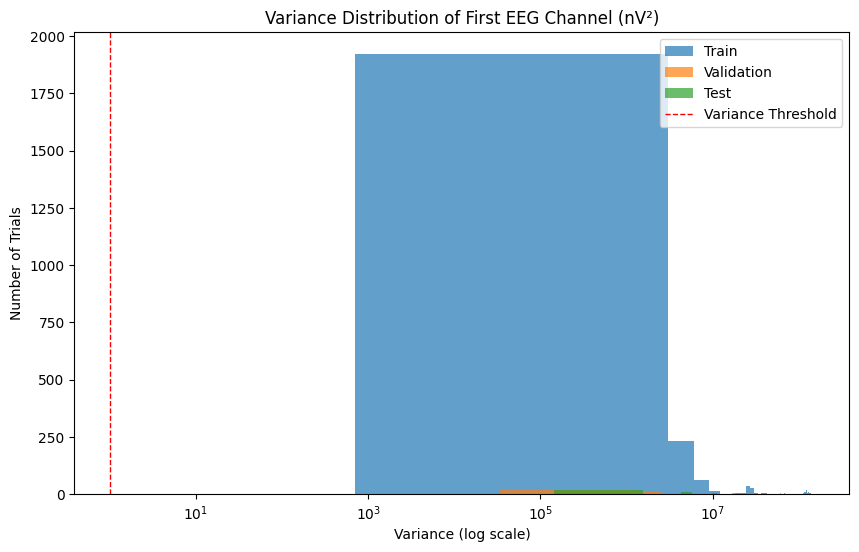

In [2]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Configuration - Use Kaggle's working directory for outputs
BASE_PATH = '/kaggle/input/mtcaic3/'  # Input dataset path
OUTPUT_PATH = '/kaggle/working/'      # Writable output directory

# Updated noise detection parameters for nV scale (1 μV = 1000 nV)
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
VAR_THRESHOLD = 1.0                   # 1 nV² (equivalent to 1e-6 μV²)
AMP_THRESHOLD = 500000                # 500,000 nV (500 μV)
FLAT_SEGMENT_LEN = 25                 # Longer segment (0.1s at 250Hz)
FLAT_TOLERANCE = 100.0                # 100 nV (0.1 μV)

# Cached session loader
session_cache = {}

def load_trial_data(row, base_path=BASE_PATH):
    """Load trial data with session caching"""
    # Determine dataset split from ID
    dataset = 'train' if row['id'] <= 4800 else ('validation' if row['id'] <= 4900 else 'test')
    
    # Create cache key
    key = (row['task'], dataset, row['subject_id'], row['trial_session'])
    
    # Load session data if not cached
    if key not in session_cache:
        session_path = os.path.join(
            base_path, 
            row['task'], 
            dataset, 
            row['subject_id'], 
            str(row['trial_session']), 
            'EEGdata.csv'
        )
        session_cache[key] = pd.read_csv(session_path)
    
    # Calculate trial boundaries (MI only - 2250 samples)
    start_idx = (row['trial'] - 1) * 2250
    end_idx = start_idx + 2250
    
    return session_cache[key].iloc[start_idx:end_idx]

def is_noisy_trial(trial_data):
    """Determine if a trial is noisy based on signal characteristics (nV scale)"""
    for channel in EEG_CHANNELS:
        data = trial_data[channel].values
        
        # 1. Check variance (dead channel detection) - in nV²
        if np.var(data) < VAR_THRESHOLD:
            return True, 'low_variance'
            
        # 2. Check amplitude (saturation detection) - in nV
        if np.max(np.abs(data)) > AMP_THRESHOLD:
            return True, 'high_amplitude'
            
        # 3. Check for flat segments (disconnection artifacts)
        for i in range(0, len(data) - FLAT_SEGMENT_LEN, 10):  # Skip by 10 samples for efficiency
            segment = data[i:i+FLAT_SEGMENT_LEN]
            if np.ptp(segment) < FLAT_TOLERANCE:  # Peak-to-peak within tolerance
                return True, 'flat_segment'
                
    return False, 'clean'

def process_mi_trials(df):
    """Process MI trials and return results with noise metrics"""
    results = []
    mi_df = df[df['task'] == 'MI'].copy()
    
    for _, row in tqdm(mi_df.iterrows(), total=len(mi_df)):
        try:
            trial_data = load_trial_data(row)
            noisy, reason = is_noisy_trial(trial_data)
            
            # Calculate metrics for first channel
            ch0_data = trial_data[EEG_CHANNELS[0]].values
            variance = np.var(ch0_data)
            max_amp = np.max(np.abs(ch0_data))
            
            results.append({
                'id': row['id'],
                'subject_id': row['subject_id'],
                'trial_session': row['trial_session'],
                'trial': row['trial'],
                'label': row.get('label', None),
                'is_noisy': noisy,
                'noise_reason': reason,  # Corrected column name
                'variance': variance,
                'max_amp': max_amp
            })
        except Exception as e:
            print(f"Error processing ID {row['id']}: {str(e)}")
            results.append({
                'id': row['id'],
                'subject_id': row['subject_id'],
                'trial_session': row['trial_session'],
                'trial': row['trial'],
                'label': row.get('label', None),
                'is_noisy': None,
                'noise_reason': 'error',
                'variance': None,
                'max_amp': None
            })
    
    return pd.DataFrame(results)

# Main processing
if __name__ == "__main__":
    print("Using updated thresholds for nV data:")
    print(f"Variance Threshold: {VAR_THRESHOLD} nV²")
    print(f"Amplitude Threshold: {AMP_THRESHOLD} nV")
    print(f"Flat Tolerance: {FLAT_TOLERANCE} nV over {FLAT_SEGMENT_LEN} samples")
    
    # Load metadata files
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

    # Process MI trials only
    print("\nProcessing MI trials in training set...")
    train_mi_results = process_mi_trials(train_df)
    
    print("\nProcessing MI trials in validation set...")
    val_mi_results = process_mi_trials(val_df)
    
    print("\nProcessing MI trials in test set...")
    test_mi_results = process_mi_trials(test_df)

    # Save results to writable directory
    train_mi_results.to_csv(os.path.join(OUTPUT_PATH, 'mi_train_noise_nV.csv'), index=False)
    val_mi_results.to_csv(os.path.join(OUTPUT_PATH, 'mi_validation_noise_nV.csv'), index=False)
    test_mi_results.to_csv(os.path.join(OUTPUT_PATH, 'mi_test_noise_nV.csv'), index=False)

    # Save noisy trial IDs with reasons
    def save_noisy_trials(df, name):
        noisy_df = df[df['is_noisy'] == True]
        noisy_df[['id', 'noise_reason']].to_csv(
            os.path.join(OUTPUT_PATH, f'noisy_{name}_ids.csv'), 
            index=False
        )
        return len(noisy_df)
    
    train_noisy_count = save_noisy_trials(train_mi_results, 'train')
    val_noisy_count = save_noisy_trials(val_mi_results, 'validation')
    test_noisy_count = save_noisy_trials(test_mi_results, 'test')

    # Generate detailed noise report with full reasons
    def get_detailed_report(df, name):
        report = []
        total = len(df)
        
        # Get reason counts
        reason_counts = df['noise_reason'].value_counts()
        for reason, count in reason_counts.items():
            report.append({
                'Dataset': name,
                'Reason': reason,
                'Count': count,
                'Percentage': f"{count/total:.2%}",
                'Total Trials': total
            })
        
        # Add summary row
        noisy_count = df['is_noisy'].sum()
        report.append({
            'Dataset': name,
            'Reason': 'TOTAL NOISY',
            'Count': noisy_count,
            'Percentage': f"{noisy_count/total:.2%}",
            'Total Trials': total
        })
        
        return pd.DataFrame(report)

    # Create detailed reports
    train_report = get_detailed_report(train_mi_results, 'Train')
    val_report = get_detailed_report(val_mi_results, 'Validation')
    test_report = get_detailed_report(test_mi_results, 'Test')
    
    # Combine reports
    full_report = pd.concat([train_report, val_report, test_report])
    full_report.to_csv(os.path.join(OUTPUT_PATH, 'detailed_noise_report.csv'), index=False)
    
    # Print formatted report
    print("\n" + "="*60)
    print("MOTOR IMAGERY NOISE REPORT (nV adjusted)".center(60))
    print("="*60)
    
    for dataset in ['Train', 'Validation', 'Test']:
        df_report = full_report[full_report['Dataset'] == dataset]
        print(f"\n{dataset} Set ({df_report['Total Trials'].iloc[0]} trials):")
        print("-"*60)
        for _, row in df_report.iterrows():
            reason = row['Reason']
            if reason == 'TOTAL NOISY':
                print("\nTOTAL NOISY TRIALS".ljust(25) + f"| {row['Count']} trials | {row['Percentage']}")
                print("-"*60)
            else:
                print(f"{reason.ljust(25)} | {row['Count']} trials | {row['Percentage']}")

    # Plot variance distribution
    plt.figure(figsize=(10, 6))
    plt.hist(train_mi_results['variance'].dropna(), bins=50, alpha=0.7, label='Train')
    plt.hist(val_mi_results['variance'].dropna(), bins=50, alpha=0.7, label='Validation')
    plt.hist(test_mi_results['variance'].dropna(), bins=50, alpha=0.7, label='Test')
    plt.axvline(VAR_THRESHOLD, color='r', linestyle='dashed', linewidth=1, label='Variance Threshold')
    plt.xscale('log')
    plt.title('Variance Distribution of First EEG Channel (nV²)')
    plt.xlabel('Variance (log scale)')
    plt.ylabel('Number of Trials')
    plt.legend()
    plt.savefig(os.path.join(OUTPUT_PATH, 'variance_distribution.png'))
    plt.show()

In [13]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3/'
OUTPUT_PATH = '/kaggle/working/'
SAMPLING_RATE = 250  # Hz

# Define time windows to analyze (start_sec, end_sec)
TIME_WINDOWS = [    # 1-8 seconds
    (1.5, 3),  # 1.5-3 seconds
    (1, 4),
    (1.5, 4),
    (0.5, 3),
    (0.5, 3.5),
    (1.5, 3.5),
    (1, 5),
    (0.5, 5),
    (1.2, 3.0),
    (1.5, 2.8),
    (1.0, 3.0),
    (1.2, 2.8)
]

# Noise detection parameters (nV scale)
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
VAR_THRESHOLD = 1.0                   # 1 nV²
AMP_THRESHOLD = 500000                # 500,000 nV (500 μV)
FLAT_SEGMENT_LEN = 25                 # 0.1s at 250Hz
FLAT_TOLERANCE = 100.0                # 100 nV

# Cached session loader
session_cache = {}

def load_trial_data(row, base_path=BASE_PATH):
    """Load trial data with session caching"""
    dataset = 'train' if row['id'] <= 4800 else ('validation' if row['id'] <= 4900 else 'test')
    key = (row['task'], dataset, row['subject_id'], row['trial_session'])
    
    if key not in session_cache:
        session_path = os.path.join(
            base_path, 
            row['task'], 
            dataset, 
            row['subject_id'], 
            str(row['trial_session']), 
            'EEGdata.csv'
        )
        session_cache[key] = pd.read_csv(session_path)
    
    start_idx = (row['trial'] - 1) * 2250
    end_idx = start_idx + 2250
    return session_cache[key].iloc[start_idx:end_idx]

def is_noisy_segment(segment_data):
    """Check if a time segment is noisy"""
    for channel in EEG_CHANNELS:
        data = segment_data[channel].values
        
        # 1. Check variance
        if np.var(data) < VAR_THRESHOLD:
            return True, 'low_variance'
            
        # 2. Check amplitude
        if np.max(np.abs(data)) > AMP_THRESHOLD:
            return True, 'high_amplitude'
            
        # 3. Check for flat segments
        for i in range(0, len(data) - FLAT_SEGMENT_LEN, 10):
            seg = data[i:i+FLAT_SEGMENT_LEN]
            if np.ptp(seg) < FLAT_TOLERANCE:
                return True, 'flat_segment'
                
    return False, 'clean'

def process_mi_trials(df):
    """Process MI trials with time window analysis"""
    results = []
    mi_df = df[df['task'] == 'MI'].copy()
    
    for _, row in tqdm(mi_df.iterrows(), total=len(mi_df)):
        try:
            trial_data = load_trial_data(row)
            trial_result = {
                'id': row['id'],
                'subject_id': row['subject_id'],
                'trial_session': row['trial_session'],
                'trial': row['trial'],
                'label': row.get('label', None)
            }
            
            # Analyze each time window
            for window in TIME_WINDOWS:
                start_sec, end_sec = window
                start_sample = int(start_sec * SAMPLING_RATE)
                end_sample = int(end_sec * SAMPLING_RATE)
                segment = trial_data.iloc[start_sample:end_sample]
                
                noisy, reason = is_noisy_segment(segment)
                win_key = f"{start_sec}s_{end_sec}s"
                
                trial_result[f'{win_key}_is_noisy'] = noisy
                trial_result[f'{win_key}_reason'] = reason
            
            results.append(trial_result)
        except Exception as e:
            print(f"Error processing ID {row['id']}: {str(e)}")
            error_result = {
                'id': row['id'],
                'subject_id': row['subject_id'],
                'trial_session': row['trial_session'],
                'trial': row['trial'],
                'label': row.get('label', None)
            }
            for window in TIME_WINDOWS:
                start_sec, end_sec = window
                win_key = f"{start_sec}s_{end_sec}s"
                error_result[f'{win_key}_is_noisy'] = True
                error_result[f'{win_key}_reason'] = 'error'
            results.append(error_result)
    
    return pd.DataFrame(results)

def generate_window_reports(results_df, dataset_name):
    """Generate noise reports for each time window"""
    reports = []
    
    for window in TIME_WINDOWS:
        start_sec, end_sec = window
        win_key = f"{start_sec}s_{end_sec}s"
        col_noisy = f'{win_key}_is_noisy'
        col_reason = f'{win_key}_reason'
        
        # Count reasons
        reason_counts = results_df[col_reason].value_counts()
        total = len(results_df)
        
        for reason, count in reason_counts.items():
            reports.append({
                'Dataset': dataset_name,
                'Window': win_key,
                'Reason': reason,
                'Count': count,
                'Percentage': f"{count/total:.2%}",
                'Total Trials': total
            })
        
        # Add total noisy summary
        noisy_count = results_df[col_noisy].sum()
        reports.append({
            'Dataset': dataset_name,
            'Window': win_key,
            'Reason': 'TOTAL NOISY',
            'Count': noisy_count,
            'Percentage': f"{noisy_count/total:.2%}",
            'Total Trials': total
        })
    
    return pd.DataFrame(reports)

# Main processing
if __name__ == "__main__":
    print("Time Window Analysis Configuration:")
    print(f"Time Windows: {', '.join([f'{s}s-{e}s' for s, e in TIME_WINDOWS])}")
    print(f"Variance Threshold: {VAR_THRESHOLD} nV²")
    print(f"Amplitude Threshold: {AMP_THRESHOLD} nV")
    print(f"Flat Tolerance: {FLAT_TOLERANCE} nV over {FLAT_SEGMENT_LEN} samples")
    
    # Load metadata
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

    # Process datasets
    print("\nProcessing MI trials in training set...")
    train_mi_results = process_mi_trials(train_df)
    train_mi_results.to_csv(os.path.join(OUTPUT_PATH, 'mi_train_window_analysis.csv'), index=False)
    
    print("\nProcessing MI trials in validation set...")
    val_mi_results = process_mi_trials(val_df)
    val_mi_results.to_csv(os.path.join(OUTPUT_PATH, 'mi_validation_window_analysis.csv'), index=False)
    
    print("\nProcessing MI trials in test set...")
    test_mi_results = process_mi_trials(test_df)
    test_mi_results.to_csv(os.path.join(OUTPUT_PATH, 'mi_test_window_analysis.csv'), index=False)

    # Generate reports
    print("\nGenerating reports...")
    train_report = generate_window_reports(train_mi_results, 'Train')
    val_report = generate_window_reports(val_mi_results, 'Validation')
    test_report = generate_window_reports(test_mi_results, 'Test')
    
    full_report = pd.concat([train_report, val_report, test_report])
    full_report.to_csv(os.path.join(OUTPUT_PATH, 'detailed_window_report.csv'), index=False)
    
    # Print summary
    print("\n" + "="*70)
    print("MOTOR IMAGERY TIME WINDOW NOISE REPORT".center(70))
    print("="*70)
    
    window_str = ", ".join([f"{s}s-{e}s" for s, e in TIME_WINDOWS])
    print(f"Analysis Windows: {window_str}")
    
    for dataset in ['Train', 'Validation', 'Test']:
        df_report = full_report[full_report['Dataset'] == dataset]
        total_trials = df_report['Total Trials'].iloc[0] if len(df_report) > 0 else 0
        
        print(f"\n{dataset} Set ({total_trials} trials):")
        print("-"*70)
        print(f"{'Window':<12} | {'Noise Reason':<15} | {'Count':<6} | {'Percentage':<10}")
        print("-"*70)
        
        for window in TIME_WINDOWS:
            win_key = f"{window[0]}s_{window[1]}s"
            win_df = df_report[df_report['Window'] == win_key]
            
            for _, row in win_df.iterrows():
                reason = row['Reason']
                if reason == 'TOTAL NOISY':
                    print(f"{win_key:<12} | {'TOTAL NOISY':<15} | {row['Count']:<6} | {row['Percentage']:<10}")
                    print("-"*70)
                else:
                    print(f"{win_key:<12} | {reason:<15} | {row['Count']:<6} | {row['Percentage']:<10}")
    
    print("\nAnalysis complete. Reports saved to:", OUTPUT_PATH)

Time Window Analysis Configuration:
Time Windows: 1.5s-3s, 1s-4s, 1.5s-4s, 0.5s-3s, 0.5s-3.5s, 1.5s-3.5s, 1s-5s, 0.5s-5s, 1.2s-3.0s, 1.5s-2.8s, 1.0s-3.0s, 1.2s-2.8s
Variance Threshold: 1.0 nV²
Amplitude Threshold: 500000 nV
Flat Tolerance: 100.0 nV over 25 samples

Processing MI trials in training set...


100%|██████████| 2400/2400 [01:47<00:00, 22.30it/s]



Processing MI trials in validation set...


100%|██████████| 50/50 [00:02<00:00, 22.57it/s]



Processing MI trials in test set...


100%|██████████| 50/50 [00:02<00:00, 24.49it/s]


Generating reports...

                MOTOR IMAGERY TIME WINDOW NOISE REPORT                
Analysis Windows: 1.5s-3s, 1s-4s, 1.5s-4s, 0.5s-3s, 0.5s-3.5s, 1.5s-3.5s, 1s-5s, 0.5s-5s, 1.2s-3.0s, 1.5s-2.8s, 1.0s-3.0s, 1.2s-2.8s

Train Set (2400 trials):
----------------------------------------------------------------------
Window       | Noise Reason    | Count  | Percentage
----------------------------------------------------------------------
1.5s_3s      | clean           | 1751   | 72.96%    
1.5s_3s      | flat_segment    | 353    | 14.71%    
1.5s_3s      | high_amplitude  | 296    | 12.33%    
1.5s_3s      | TOTAL NOISY     | 649    | 27.04%    
----------------------------------------------------------------------
1s_4s        | clean           | 1674   | 69.75%    
1s_4s        | flat_segment    | 432    | 18.00%    
1s_4s        | high_amplitude  | 294    | 12.25%    
1s_4s        | TOTAL NOISY     | 726    | 30.25%    
--------------------------------------------------------

Time Window Analysis with Validation Flag Handling
Time Windows: 1s-8s, 1.5s-3s, 3s-8s, 2s-7s
Max Invalid Ratio: 30%

Processing MI trials in training set...


100%|██████████| 2400/2400 [00:22<00:00, 108.10it/s]



Processing MI trials in validation set...


100%|██████████| 50/50 [00:00<00:00, 102.23it/s]



Processing MI trials in test set...


100%|██████████| 50/50 [00:00<00:00, 97.53it/s]



Generating reports...

       MOTOR IMAGERY TIME WINDOW NOISE REPORT (WITH VALIDATION HANDLING)        

Dataset Statistics:
--------------------------------------------------------------------------------
Dataset      | Original | Processed |  Dropped |  Dropped % | Invalid Samples
--------------------------------------------------------------------------------
Train        |     2400 |       13 |     2387 |      99.5% |           7,744
Validation   |       50 |        0 |       50 |     100.0% |               0
Test         |       50 |        0 |       50 |     100.0% |               0

Analysis Windows: 1s-8s, 1.5s-3s, 3s-8s, 2s-7s

Train Set (13 processed trials):
--------------------------------------------------------------------------------
Window       | Noise Reason    | Count  | Percentage
--------------------------------------------------------------------------------
1s-8s        | flat_segment    | 13     | 100.00%   
1s-8s        | TOTAL NOISY     | 13     | 100.00%   


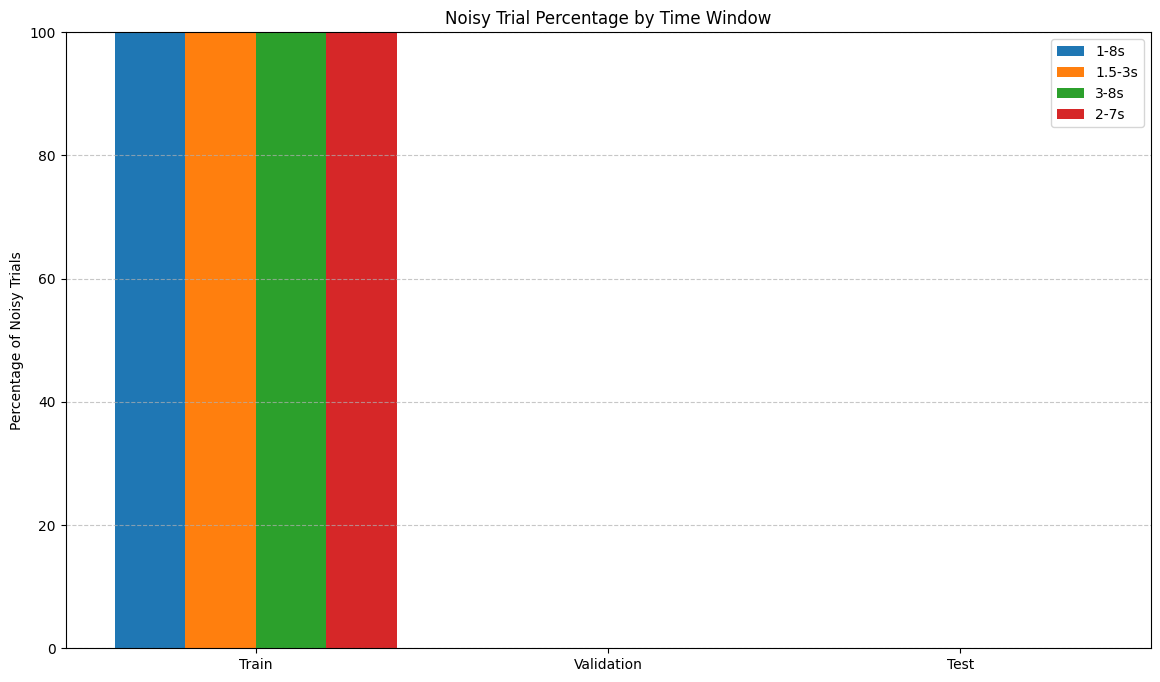

In [7]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import interpolate

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3/'
OUTPUT_PATH = '/kaggle/working/'
SAMPLING_RATE = 250  # Hz

# Define time windows to analyze (start_sec, end_sec)
TIME_WINDOWS = [
    (1, 8),    # 1-8 seconds
    (1.5, 3),  # 1.5-3 seconds
    (3, 8),    # 3-8 seconds
    (2, 7)     # 2-7 seconds
]

# Noise detection parameters (nV scale)
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
VAR_THRESHOLD = 1.0                   # 1 nV²
AMP_THRESHOLD = 500000                # 500,000 nV (500 μV)
FLAT_SEGMENT_LEN = 25                 # 0.1s at 250Hz
FLAT_TOLERANCE = 100.0                # 100 nV
MAX_INVALID_RATIO = 0.3               # Drop trial if >30% invalid samples

# Cached session loader
session_cache = {}

def load_and_validate_trial(row):
    """Load trial data with validation flag handling and interpolation"""
    dataset = 'train' if row['id'] <= 4800 else ('validation' if row['id'] <= 4900 else 'test')
    key = (row['task'], dataset, row['subject_id'], row['trial_session'])
    
    if key not in session_cache:
        session_path = os.path.join(
            BASE_PATH, 
            row['task'], 
            dataset, 
            row['subject_id'], 
            str(row['trial_session']), 
            'EEGdata.csv'
        )
        session_cache[key] = pd.read_csv(session_path)
    
    start_idx = (row['trial'] - 1) * 2250
    end_idx = start_idx + 2250
    trial_data = session_cache[key].iloc[start_idx:end_idx].copy()
    
    # Identify invalid rows using Validation flag
    invalid_mask = trial_data['Validation'] != 0
    invalid_count = invalid_mask.sum()
    total_samples = len(trial_data)
    
    # Return None if too many invalid samples
    if invalid_count / total_samples > MAX_INVALID_RATIO:
        return None, invalid_count
    
    # Get valid and invalid indices
    valid_indices = np.where(~invalid_mask)[0]
    invalid_indices = np.where(invalid_mask)[0]
    
    # Handle case with no valid points
    if len(valid_indices) == 0:
        return None, invalid_count
    
    # Interpolate invalid samples for each EEG channel
    for channel in EEG_CHANNELS:
        channel_data = trial_data[channel].values
        
        if len(valid_indices) == 1:
            # Only one valid point - use constant value
            trial_data.loc[invalid_mask, channel] = channel_data[valid_indices[0]]
        else:
            # Cubic spline interpolation
            try:
                interp_fn = interpolate.interp1d(
                    valid_indices,
                    channel_data[valid_indices],
                    kind='cubic',
                    fill_value="extrapolate"
                )
                trial_data.loc[invalid_mask, channel] = interp_fn(invalid_indices)
            except:
                # Fallback to linear interpolation
                interp_fn = interpolate.interp1d(
                    valid_indices,
                    channel_data[valid_indices],
                    kind='linear',
                    fill_value="extrapolate"
                )
                trial_data.loc[invalid_mask, channel] = interp_fn(invalid_indices)
    
    return trial_data, invalid_count

def is_noisy_segment(segment_data):
    """Check if a time segment is noisy"""
    for channel in EEG_CHANNELS:
        data = segment_data[channel].values
        
        # 1. Check variance
        if np.var(data) < VAR_THRESHOLD:
            return True, 'low_variance'
            
        # 2. Check amplitude
        if np.max(np.abs(data)) > AMP_THRESHOLD:
            return True, 'high_amplitude'
            
        # 3. Check for flat segments
        for i in range(0, len(data) - FLAT_SEGMENT_LEN, 10):
            seg = data[i:i+FLAT_SEGMENT_LEN]
            if np.ptp(seg) < FLAT_TOLERANCE:
                return True, 'flat_segment'
                
    return False, 'clean'

def process_mi_trials(df):
    """Process MI trials with validation handling and time window analysis"""
    results = []
    dropped_trials = 0
    total_invalid_samples = 0
    mi_df = df[df['task'] == 'MI'].copy()
    
    for _, row in tqdm(mi_df.iterrows(), total=len(mi_df)):
        try:
            trial_data, invalid_count = load_and_validate_trial(row)
            
            if trial_data is None:
                dropped_trials += 1
                continue
                
            total_invalid_samples += invalid_count
            trial_result = {
                'id': row['id'],
                'subject_id': row['subject_id'],
                'trial_session': row['trial_session'],
                'trial': row['trial'],
                'label': row.get('label', None),
                'invalid_samples': invalid_count
            }
            
            # Analyze each time window
            for window in TIME_WINDOWS:
                start_sec, end_sec = window
                start_sample = int(start_sec * SAMPLING_RATE)
                end_sample = int(end_sec * SAMPLING_RATE)
                segment = trial_data.iloc[start_sample:end_sample]
                
                noisy, reason = is_noisy_segment(segment)
                win_key = f"{start_sec}_{end_sec}s"  # Consistent naming
                
                trial_result[f'{win_key}_is_noisy'] = noisy
                trial_result[f'{win_key}_reason'] = reason
            
            results.append(trial_result)
        except Exception as e:
            print(f"Error processing ID {row['id']}: {str(e)}")
            dropped_trials += 1
    
    return pd.DataFrame(results), dropped_trials, total_invalid_samples

def generate_window_reports(results_df, dataset_name):
    """Generate noise reports for each time window"""
    reports = []
    
    for window in TIME_WINDOWS:
        start_sec, end_sec = window
        win_key = f"{start_sec}_{end_sec}s"
        col_noisy = f'{win_key}_is_noisy'
        col_reason = f'{win_key}_reason'
        
        # Check if columns exist in DataFrame
        if col_reason not in results_df.columns:
            # If no trials for this window, add empty report
            reports.append({
                'Dataset': dataset_name,
                'Window': win_key,
                'Reason': 'TOTAL NOISY',
                'Count': 0,
                'Percentage': "0.00%",
                'Total Trials': len(results_df) if len(results_df) > 0 else 0
            })
            continue
            
        # Count reasons
        reason_counts = results_df[col_reason].value_counts()
        total = len(results_df)
        
        for reason, count in reason_counts.items():
            reports.append({
                'Dataset': dataset_name,
                'Window': win_key,
                'Reason': reason,
                'Count': count,
                'Percentage': f"{count/total:.2%}",
                'Total Trials': total
            })
        
        # Add total noisy summary
        noisy_count = results_df[col_noisy].sum()
        reports.append({
            'Dataset': dataset_name,
            'Window': win_key,
            'Reason': 'TOTAL NOISY',
            'Count': noisy_count,
            'Percentage': f"{noisy_count/total:.2%}",
            'Total Trials': total
        })
    
    return pd.DataFrame(reports)

# Main processing
if __name__ == "__main__":
    print("Time Window Analysis with Validation Flag Handling")
    print(f"Time Windows: {', '.join([f'{s}s-{e}s' for s, e in TIME_WINDOWS])}")
    print(f"Max Invalid Ratio: {MAX_INVALID_RATIO*100:.0f}%")
    
    # Load metadata
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    
    # Get MI trial counts
    train_original_count = len(train_df[train_df['task'] == 'MI'])
    val_original_count = len(val_df[val_df['task'] == 'MI'])
    test_original_count = len(test_df[test_df['task'] == 'MI'])

    # Process datasets
    print("\nProcessing MI trials in training set...")
    train_mi_results, train_dropped, train_invalid_samples = process_mi_trials(train_df)
    train_dropped_pct = train_dropped / train_original_count * 100 if train_original_count > 0 else 0
    
    print("\nProcessing MI trials in validation set...")
    val_mi_results, val_dropped, val_invalid_samples = process_mi_trials(val_df)
    val_dropped_pct = val_dropped / val_original_count * 100 if val_original_count > 0 else 0
    
    print("\nProcessing MI trials in test set...")
    test_mi_results, test_dropped, test_invalid_samples = process_mi_trials(test_df)
    test_dropped_pct = test_dropped / test_original_count * 100 if test_original_count > 0 else 0

    # Save results
    train_mi_results.to_csv(os.path.join(OUTPUT_PATH, 'mi_train_window_analysis_validated.csv'), index=False)
    val_mi_results.to_csv(os.path.join(OUTPUT_PATH, 'mi_validation_window_analysis_validated.csv'), index=False)
    test_mi_results.to_csv(os.path.join(OUTPUT_PATH, 'mi_test_window_analysis_validated.csv'), index=False)

    # Generate reports
    print("\nGenerating reports...")
    train_report = generate_window_reports(train_mi_results, 'Train')
    val_report = generate_window_reports(val_mi_results, 'Validation')
    test_report = generate_window_reports(test_mi_results, 'Test')
    
    full_report = pd.concat([train_report, val_report, test_report])
    
    # Create DataFrame for dropped trials
    dropped_data = [
        {'Dataset': 'Train', 'Window': 'ALL WINDOWS', 'Reason': 'DROPPED TRIALS', 
         'Count': train_dropped, 'Percentage': f"{train_dropped_pct:.1f}%", 'Total Trials': train_original_count},
        {'Dataset': 'Validation', 'Window': 'ALL WINDOWS', 'Reason': 'DROPPED TRIALS', 
         'Count': val_dropped, 'Percentage': f"{val_dropped_pct:.1f}%", 'Total Trials': val_original_count},
        {'Dataset': 'Test', 'Window': 'ALL WINDOWS', 'Reason': 'DROPPED TRIALS', 
         'Count': test_dropped, 'Percentage': f"{test_dropped_pct:.1f}%", 'Total Trials': test_original_count}
    ]
    dropped_df = pd.DataFrame(dropped_data)
    
    # Combine with full report
    full_report = pd.concat([full_report, dropped_df], ignore_index=True)
    full_report.to_csv(os.path.join(OUTPUT_PATH, 'detailed_window_report_validated.csv'), index=False)
    
    # Print summary
    print("\n" + "="*80)
    print("MOTOR IMAGERY TIME WINDOW NOISE REPORT (WITH VALIDATION HANDLING)".center(80))
    print("="*80)
    
    # Dataset statistics
    datasets = [
        ('Train', train_original_count, len(train_mi_results), train_dropped, train_dropped_pct, train_invalid_samples),
        ('Validation', val_original_count, len(val_mi_results), val_dropped, val_dropped_pct, val_invalid_samples),
        ('Test', test_original_count, len(test_mi_results), test_dropped, test_dropped_pct, test_invalid_samples)
    ]
    
    print("\nDataset Statistics:")
    print("-"*80)
    print(f"{'Dataset':<12} | {'Original':>8} | {'Processed':>8} | {'Dropped':>8} | {'Dropped %':>10} | {'Invalid Samples':>15}")
    print("-"*80)
    for name, orig, proc, dropped, dropped_pct, invalid in datasets:
        print(f"{name:<12} | {orig:>8} | {proc:>8} | {dropped:>8} | {dropped_pct:>9.1f}% | {invalid:>15,}")

    # Window noise reports
    window_str = ", ".join([f"{s}s-{e}s" for s, e in TIME_WINDOWS])
    print(f"\nAnalysis Windows: {window_str}")
    
    for dataset in ['Train', 'Validation', 'Test']:
        df_report = full_report[full_report['Dataset'] == dataset]
        if len(df_report) == 0:
            continue
            
        total_trials = df_report[df_report['Window'] != 'ALL WINDOWS']['Total Trials'].max()
        print(f"\n{dataset} Set ({int(total_trials)} processed trials):")
        print("-"*80)
        print(f"{'Window':<12} | {'Noise Reason':<15} | {'Count':<6} | {'Percentage':<10}")
        print("-"*80)
        
        # First print regular windows
        for window in TIME_WINDOWS:
            win_key = f"{window[0]}_{window[1]}s"
            win_df = df_report[df_report['Window'] == win_key]
            
            for _, row in win_df.iterrows():
                reason = row['Reason']
                if reason == 'TOTAL NOISY':
                    print(f"{win_key.replace('_', 's-').replace('s', 's'):<12} | {'TOTAL NOISY':<15} | {row['Count']:<6} | {row['Percentage']:<10}")
                else:
                    print(f"{win_key.replace('_', 's-').replace('s', 's'):<12} | {reason:<15} | {row['Count']:<6} | {row['Percentage']:<10}")
        
        # Print dropped trials summary
        dropped_row = df_report[(df_report['Window'] == 'ALL WINDOWS') & 
                               (df_report['Reason'] == 'DROPPED TRIALS')]
        if not dropped_row.empty:
            row = dropped_row.iloc[0]
            print(f"{'':<12} | {'DROPPED TRIALS':<15} | {row['Count']:<6} | {row['Percentage']:<10}")
            print("-"*80)
    
    # Plot noise distribution across windows
    plt.figure(figsize=(14, 8))
    for i, window in enumerate(TIME_WINDOWS):
        win_key = f"{window[0]}_{window[1]}s"
        window_data = []
        
        for dataset in ['Train', 'Validation', 'Test']:
            df_sub = full_report[(full_report['Dataset'] == dataset) & 
                                (full_report['Window'] == win_key) &
                                (full_report['Reason'] == 'TOTAL NOISY')]
            if len(df_sub) > 0 and not df_sub.empty:
                pct_str = df_sub['Percentage'].iloc[0].strip('%')
                window_data.append(float(pct_str) if pct_str else 0)
            else:
                window_data.append(0)
        
        # Plot only if we have data
        if any(val > 0 for val in window_data):
            plt.bar(np.arange(3) + i*0.2, window_data, width=0.2, label=f"{window[0]}-{window[1]}s")
    
    plt.xticks(np.arange(3) + 0.3, ['Train', 'Validation', 'Test'])
    plt.title('Noisy Trial Percentage by Time Window')
    plt.ylabel('Percentage of Noisy Trials')
    plt.ylim(0, 100)
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.savefig(os.path.join(OUTPUT_PATH, 'window_noise_comparison.png'))
    
    print("\nAnalysis complete. Reports saved to:", OUTPUT_PATH)

Time Window Invalid Sample Analysis
Time Windows: 1s-8s, 1.5s-3s, 3s-8s, 2s-7s, 1s-4s, 1.5s-4s, 0.5s-3s, 0.5s-3.5s, 1.5s-3.5s, 1s-5s, 0.5s-5s

Analyzing training set...


Analyzing invalid samples: 100%|██████████| 2400/2400 [00:23<00:00, 100.04it/s]



Analyzing validation set...


Analyzing invalid samples: 100%|██████████| 50/50 [00:00<00:00, 100.25it/s]



Analyzing test set...


Analyzing invalid samples: 100%|██████████| 50/50 [00:00<00:00, 102.16it/s]
/tmp/ipykernel_35/2986899577.py:203: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()



Generating reports...

                           INVALID SAMPLE REPORT BY TIME WINDOW                           
Dataset    | Window       | Avg Invalid % |   Median % | High Invalid Trials %
------------------------------------------------------------------------------------------
Train      | Overall      |        97.88% |          - |                    -
Train      | 1s-8s        |        97.87% |     100.00% |               100.00%
Train      | 1.5s-3s      |        97.86% |     100.00% |               100.00%
Train      | 3s-8s        |        97.87% |     100.00% |               100.00%
Train      | 2s-7s        |        97.85% |     100.00% |               100.00%
Train      | 1s-4s        |        97.86% |     100.00% |                99.96%
Train      | 1.5s-4s      |        97.84% |     100.00% |                99.96%
Train      | 0.5s-3s      |        97.87% |     100.00% |               100.00%
Train      | 0.5s-3.5s    |        97.85% |     100.00% |               100.0

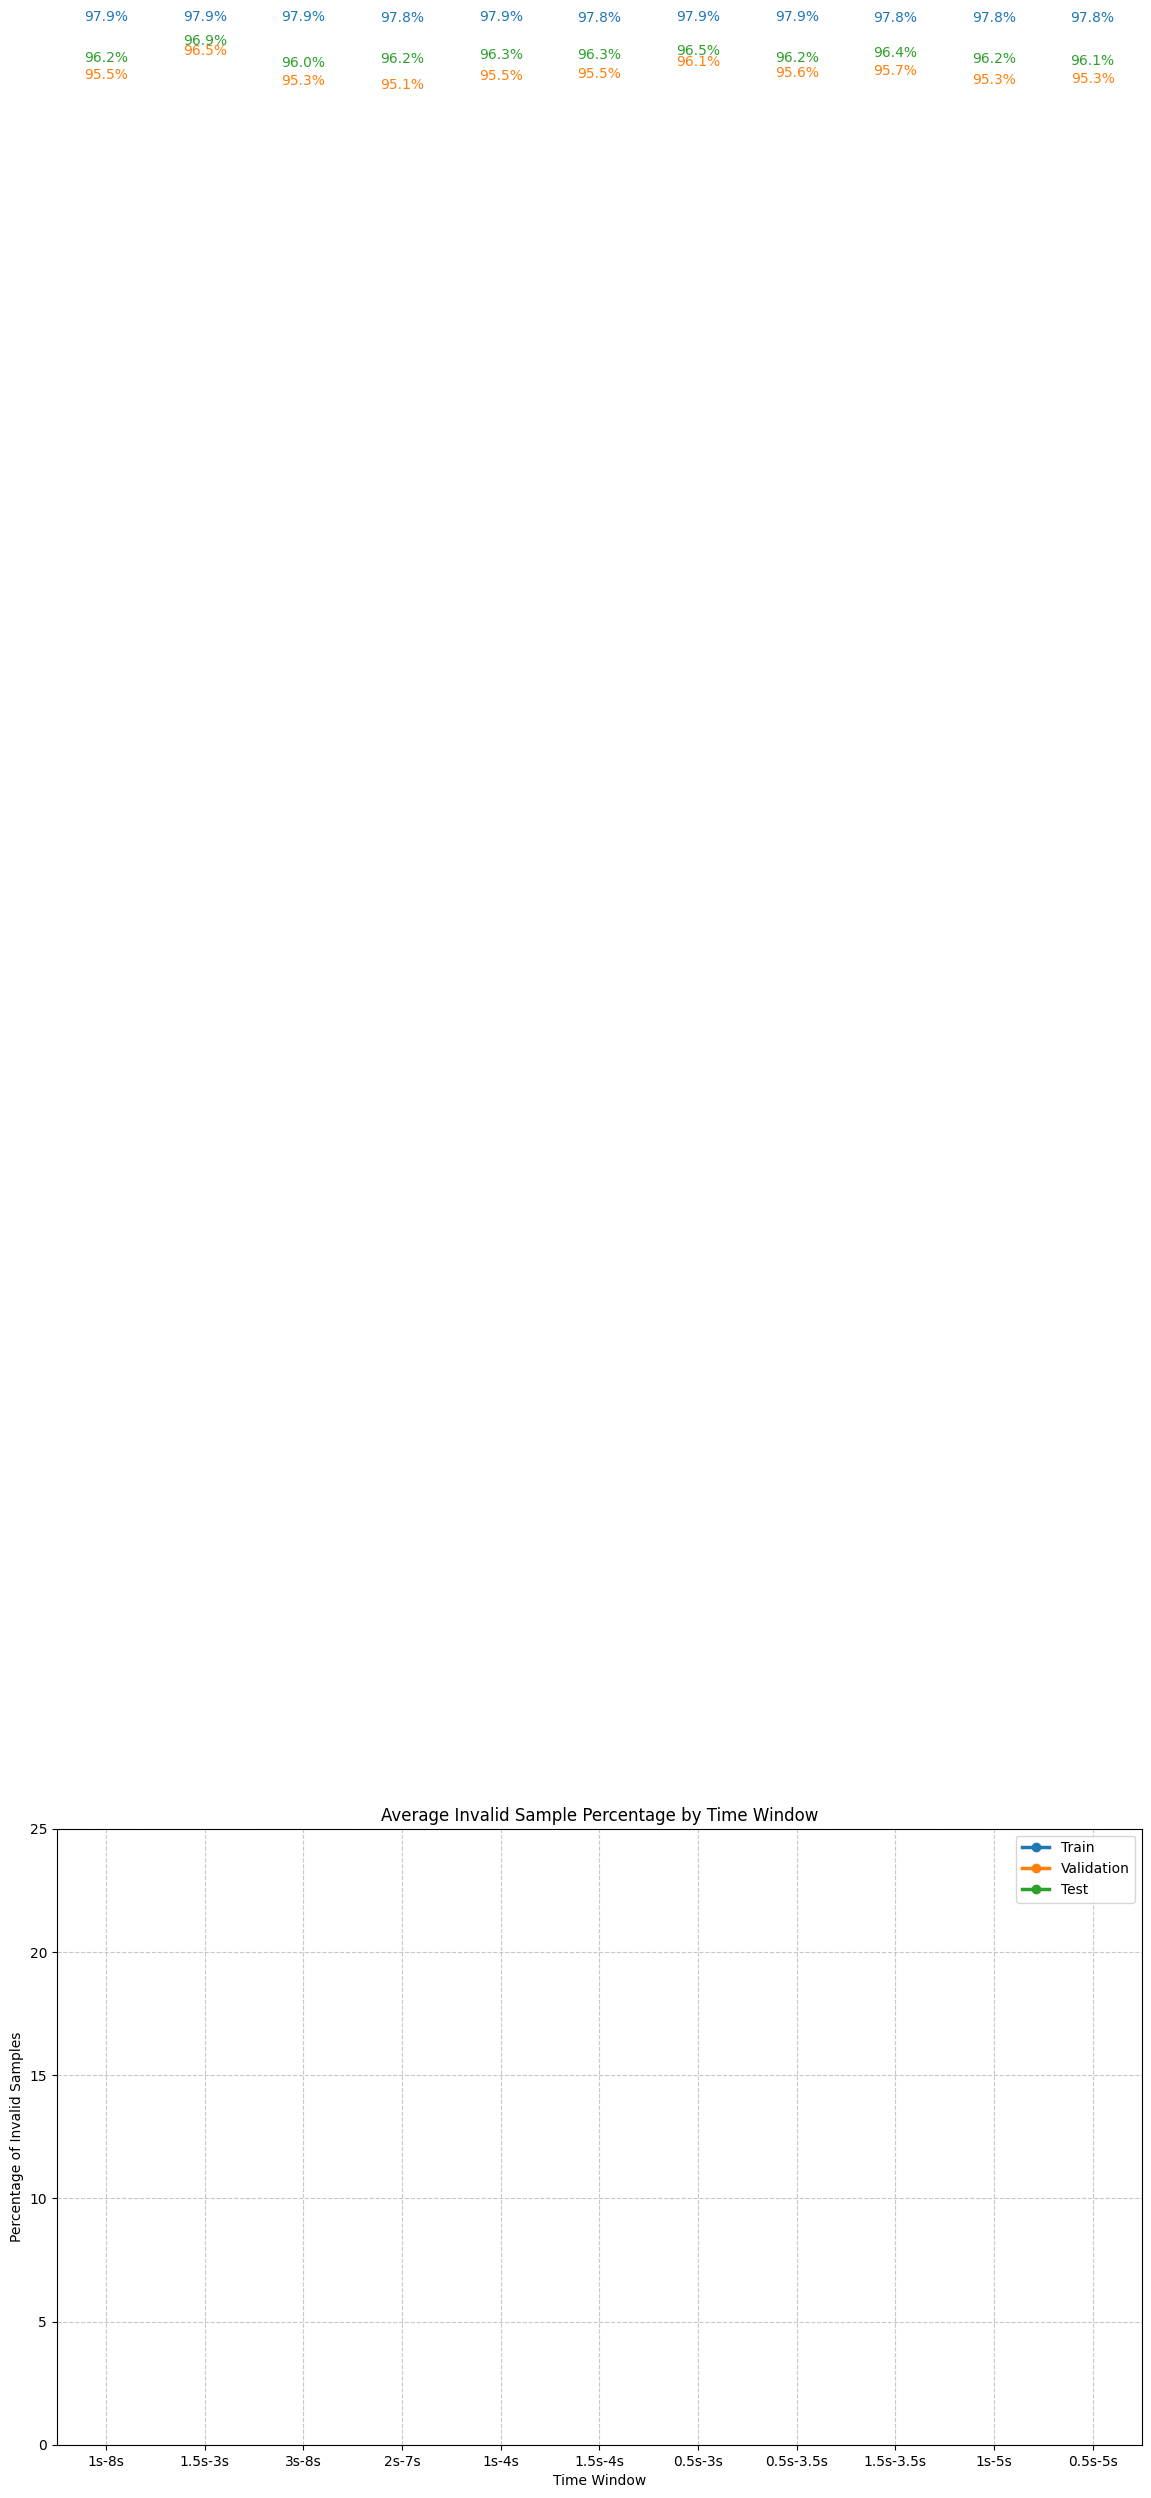

In [11]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import interpolate

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3/'
OUTPUT_PATH = '/kaggle/working/'
SAMPLING_RATE = 250  # Hz

# Define time windows to analyze (start_sec, end_sec)
TIME_WINDOWS = [
    (1, 8),    # 1-8 seconds
    (1.5, 3),  # 1.5-3 seconds
    (3, 8),    # 3-8 seconds
    (2, 7),     # 2-7 seconds
    (1, 4),
    (1.5, 4),
    (0.5, 3),
    (0.5, 3.5),
    (1.5, 3.5),
    (1, 5),
    (0.5, 5)
]

# Cached session loader
session_cache = {}

def load_trial_data(row):
    """Load trial data with session caching"""
    dataset = 'train' if row['id'] <= 4800 else ('validation' if row['id'] <= 4900 else 'test')
    key = (row['task'], dataset, row['subject_id'], row['trial_session'])
    
    if key not in session_cache:
        session_path = os.path.join(
            BASE_PATH, 
            row['task'], 
            dataset, 
            row['subject_id'], 
            str(row['trial_session']), 
            'EEGdata.csv'
        )
        session_cache[key] = pd.read_csv(session_path)
    
    start_idx = (row['trial'] - 1) * 2250
    end_idx = start_idx + 2250
    return session_cache[key].iloc[start_idx:end_idx].copy()

def calculate_invalid_percentages(df):
    """Calculate invalid sample percentages per time window"""
    results = []
    mi_df = df[df['task'] == 'MI'].copy()
    
    for _, row in tqdm(mi_df.iterrows(), total=len(mi_df), desc="Analyzing invalid samples"):
        try:
            trial_data = load_trial_data(row)
            invalid_mask = trial_data['Validation'] != 0
            trial_result = {'id': row['id']}
            
            # Calculate overall invalid percentage
            total_invalid = invalid_mask.sum()
            trial_result['overall_invalid_pct'] = total_invalid / len(trial_data) * 100
            
            # Calculate per-window invalid percentages
            for window in TIME_WINDOWS:
                start_sec, end_sec = window
                start_sample = int(start_sec * SAMPLING_RATE)
                end_sample = int(end_sec * SAMPLING_RATE)
                
                window_data = trial_data.iloc[start_sample:end_sample]
                window_invalid = window_data['Validation'] != 0
                
                win_key = f"{start_sec}_{end_sec}s"
                invalid_count = window_invalid.sum()
                window_length = end_sample - start_sample
                
                trial_result[f'{win_key}_invalid_count'] = invalid_count
                trial_result[f'{win_key}_invalid_pct'] = invalid_count / window_length * 100
                trial_result[f'{win_key}_window_length'] = window_length
                
            results.append(trial_result)
        except Exception as e:
            print(f"Error processing ID {row['id']}: {str(e)}")
    
    return pd.DataFrame(results)

def generate_invalid_report(results_df, dataset_name):
    """Generate invalid sample report for each time window"""
    reports = []
    
    # Overall statistics
    overall_invalid_pct = results_df['overall_invalid_pct'].mean()
    reports.append({
        'Dataset': dataset_name,
        'Window': 'Overall',
        'Invalid Percentage': overall_invalid_pct,
        'Description': 'Entire trial average'
    })
    
    # Per-window statistics
    for window in TIME_WINDOWS:
        start_sec, end_sec = window
        win_key = f"{start_sec}_{end_sec}s"
        col_pct = f'{win_key}_invalid_pct'
        
        # Calculate statistics
        mean_pct = results_df[col_pct].mean()
        median_pct = results_df[col_pct].median()
        max_pct = results_df[col_pct].max()
        min_pct = results_df[col_pct].min()
        
        # Calculate how many trials have >10% invalid samples
        high_invalid_trials = results_df[results_df[col_pct] > 10]
        high_invalid_pct = len(high_invalid_trials) / len(results_df) * 100
        
        reports.append({
            'Dataset': dataset_name,
            'Window': f"{start_sec}s-{end_sec}s",
            'Invalid Percentage': mean_pct,
            'Median Percentage': median_pct,
            'Min Percentage': min_pct,
            'Max Percentage': max_pct,
            'High Invalid Trials (>10%)': high_invalid_pct,
            'Window Duration': f"{end_sec - start_sec}s",
            'Samples': (end_sec - start_sec) * SAMPLING_RATE
        })
    
    return pd.DataFrame(reports)

# Main processing
if __name__ == "__main__":
    print("Time Window Invalid Sample Analysis")
    print(f"Time Windows: {', '.join([f'{s}s-{e}s' for s, e in TIME_WINDOWS])}")
    
    # Load metadata
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    
    # Calculate invalid percentages
    print("\nAnalyzing training set...")
    train_invalid = calculate_invalid_percentages(train_df)
    train_invalid.to_csv(os.path.join(OUTPUT_PATH, 'train_invalid_analysis.csv'), index=False)
    
    print("\nAnalyzing validation set...")
    val_invalid = calculate_invalid_percentages(val_df)
    val_invalid.to_csv(os.path.join(OUTPUT_PATH, 'validation_invalid_analysis.csv'), index=False)
    
    print("\nAnalyzing test set...")
    test_invalid = calculate_invalid_percentages(test_df)
    test_invalid.to_csv(os.path.join(OUTPUT_PATH, 'test_invalid_analysis.csv'), index=False)
    
    # Generate reports
    print("\nGenerating reports...")
    train_report = generate_invalid_report(train_invalid, 'Train')
    val_report = generate_invalid_report(val_invalid, 'Validation')
    test_report = generate_invalid_report(test_invalid, 'Test')
    
    full_report = pd.concat([train_report, val_report, test_report])
    full_report.to_csv(os.path.join(OUTPUT_PATH, 'invalid_sample_report.csv'), index=False)
    
    # Print summary
    print("\n" + "="*90)
    print("INVALID SAMPLE REPORT BY TIME WINDOW".center(90))
    print("="*90)
    print(f"{'Dataset':<10} | {'Window':<12} | {'Avg Invalid %':>12} | {'Median %':>10} | {'High Invalid Trials %':>20}")
    print("-"*90)
    
    for dataset in ['Train', 'Validation', 'Test']:
        df_report = full_report[full_report['Dataset'] == dataset]
        
        # Print overall first
        overall_row = df_report[df_report['Window'] == 'Overall'].iloc[0]
        print(f"{dataset:<10} | {'Overall':<12} | {overall_row['Invalid Percentage']:>12.2f}% | {'-':>10} | {'-':>20}")
        
        # Then per window
        for _, row in df_report[df_report['Window'] != 'Overall'].iterrows():
            print(f"{dataset:<10} | {row['Window']:<12} | {row['Invalid Percentage']:>12.2f}% | {row['Median Percentage']:>10.2f}% | {row['High Invalid Trials (>10%)']:>20.2f}%")
    
    # Visualization
    plt.figure(figsize=(14, 8))
    colors = plt.cm.tab10.colors
    
    for i, dataset in enumerate(['Train', 'Validation', 'Test']):
        df_report = full_report[(full_report['Dataset'] == dataset) & 
                               (full_report['Window'] != 'Overall')]
        
        windows = [f"{s}s-{e}s" for s, e in TIME_WINDOWS]
        percentages = df_report['Invalid Percentage'].values
        
        plt.plot(windows, percentages, 'o-', color=colors[i], label=dataset, linewidth=2.5)
        for j, pct in enumerate(percentages):
            plt.text(j, pct+0.5, f"{pct:.1f}%", ha='center', color=colors[i])
    
    plt.title('Average Invalid Sample Percentage by Time Window')
    plt.ylabel('Percentage of Invalid Samples')
    plt.xlabel('Time Window')
    plt.ylim(0, 25)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'invalid_percentage_comparison.png'))
    
    print("\nAnalysis complete. Reports saved to:", OUTPUT_PATH)

In [27]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from scipy.interpolate import interp1d

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
WINDOWS = {
    '1.5s_2.8s': (1.5, 2.8),
    '1.5s_3s': (1.5, 3.0)
}
SAMPLING_RATE = 250

# Noise detection parameters (nV scale)
VAR_THRESHOLD = 1.0                   # 1 nV²
AMP_THRESHOLD = 500000                # 500,000 nV (500 μV)
FLAT_SEGMENT_LEN = 25                 # 0.1s at 250Hz
FLAT_TOLERANCE = 100.0                # 100 nV

# Cached session loader
session_cache = {}

def load_trial_data(row):
    """Load EEG data for a specific trial with caching"""
    # Determine file path
    subject_dir = os.path.join(BASE_PATH, row['task'], row['dataset'], 
                              row['subject_id'], str(row['trial_session']))
    eeg_path = os.path.join(subject_dir, 'EEGdata.csv')
    
    # Use cached session data if available
    if eeg_path in session_cache:
        session_data = session_cache[eeg_path]
    else:
        session_data = pd.read_csv(eeg_path)
        session_cache[eeg_path] = session_data
    
    # Extract specific trial
    trial_num = row['trial']
    samples_per_trial = 2250  # MI trials are 9s * 250Hz
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    
    return session_data.iloc[start_idx:end_idx].copy()

def interpolate_invalid(data):
    """Improved interpolation with artifact prevention"""
    if 'Validation' not in data.columns:
        return data
    
    valid_mask = data['Validation'] == 1
    invalid_mask = ~valid_mask
    
    if invalid_mask.sum() == 0 or valid_mask.sum() < 2:
        return data
    
    # Split into segments of consecutive invalid samples
    invalid_groups = np.where(np.diff(np.concatenate(([False], invalid_mask, [False]))))[0].reshape(-1, 2)
    
    for channel in EEG_CHANNELS:
        channel_data = data[channel].values.copy()
        valid_values = channel_data[valid_mask]
        valid_indices = np.where(valid_mask)[0]
        
        # Create interpolation function (cubic for smoother transitions)
        interp_func = interp1d(
            valid_indices, 
            valid_values, 
            kind='cubic',  # Smoother than linear
            bounds_error=False,
            fill_value="extrapolate"
        )
        
        # Process each invalid segment separately
        for start, end in invalid_groups:
            gap_size = end - start
            gap_indices = np.arange(start, end)
            
            # Only interpolate small gaps (<= 5 samples)
            if gap_size > 5:
                # For large gaps, use nearest valid value instead of interpolation
                if start == 0:
                    fill_value = valid_values[0]
                elif end >= len(channel_data):
                    fill_value = valid_values[-1]
                else:
                    # Average of nearest valid neighbors
                    prev_valid = channel_data[valid_indices[valid_indices < start][-1]]
                    next_valid = channel_data[valid_indices[valid_indices >= end][0]]
                    fill_value = (prev_valid + next_valid) / 2
                channel_data[gap_indices] = fill_value
            else:
                # Interpolate small gaps
                channel_data[gap_indices] = interp_func(gap_indices)
        
        data[channel] = channel_data
    
    return data

def is_noisy_segment(data):
    """Check if a time segment is noisy - EXACTLY matching your original logic"""
    for channel in EEG_CHANNELS:
        ch_data = data[channel].values
        
        # 1. Check variance of entire channel segment
        if np.var(ch_data) < VAR_THRESHOLD:
            return True, 'low_variance'
            
        # 2. Check amplitude of entire channel segment
        if np.max(np.abs(ch_data)) > AMP_THRESHOLD:
            return True, 'high_amplitude'
            
        # 3. Check for flat segments with step size 10
        for i in range(0, len(ch_data) - FLAT_SEGMENT_LEN, 10):
            seg = ch_data[i:i+FLAT_SEGMENT_LEN]
            if np.ptp(seg) < FLAT_TOLERANCE:  # Peak-to-peak (max-min)
                return True, 'flat_segment'
                
    return False, 'clean'

def analyze_trial(row, window_spec):
    """Analyze a single trial with interpolation and noise checks"""
    try:
        # Load raw EEG data
        eeg_data = load_trial_data(row)
        
        results = {}
        
        for win_name, (start, end) in window_spec.items():
            start_sample = int(start * SAMPLING_RATE)
            end_sample = int(end * SAMPLING_RATE)
            window_data = eeg_data.iloc[start_sample:end_sample].copy()
            
            # Interpolate invalid samples
            window_data = interpolate_invalid(window_data)
            
            # Run noise checks using your original logic
            noisy, reason = is_noisy_segment(window_data)
            
            results[win_name] = {
                'noisy': noisy,
                'reason': reason
            }
            
        return results
    
    except Exception as e:
        print(f"Error processing subject {row['subject_id']}, session {row['trial_session']}, trial {row['trial']}: {str(e)}")
        return None

# Main analysis function with progress tracking
def run_noise_analysis(dataset_df, dataset_name, window_spec):
    """Run noise analysis on a specific dataset"""
    results = {win: {
        'clean': 0,
        'low_variance': 0,
        'high_amplitude': 0,
        'flat_segment': 0
    } for win in window_spec}
    
    for idx, row in tqdm(dataset_df.iterrows(), total=len(dataset_df), desc=dataset_name):
        trial_results = analyze_trial(row, window_spec)
        
        if trial_results is None:
            # If error occurs, count as noisy
            for win_name in window_spec:
                results[win_name]['high_amplitude'] += 1
            continue
            
        for win_name, win_result in trial_results.items():
            if not win_result['noisy']:
                results[win_name]['clean'] += 1
            else:
                reason = win_result['reason']
                results[win_name][reason] += 1
    
    # Generate report
    report = f"\n{dataset_name.capitalize()} Set ({len(dataset_df)} trials):\n"
    report += "-" * 70 + "\n"
    report += "Window       | Noise Reason    | Count  | Percentage\n"
    report += "-" * 70 + "\n"
    
    for win_name, win_results in results.items():
        clean = win_results['clean']
        low_var = win_results['low_variance']
        high_amp = win_results['high_amplitude']
        flat_seg = win_results['flat_segment']
        total = len(dataset_df)
        total_noisy = total - clean
        
        report += f"{win_name.ljust(12)} | clean           | {clean:<6} | {clean/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | low_variance    | {low_var:<6} | {low_var/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | high_amplitude  | {high_amp:<6} | {high_amp/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | flat_segment    | {flat_seg:<6} | {flat_seg/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | TOTAL NOISY     | {total_noisy:<6} | {total_noisy/total*100:.2f}%\n"
        report += "-" * 70 + "\n"
    
    return report

# Load datasets
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Filter for Motor Imagery
train_df = train_df[train_df['task'] == 'MI']
val_df = val_df[val_df['task'] == 'MI']
test_df = test_df[test_df['task'] == 'MI']

# Add dataset source
train_df['dataset'] = 'train'
val_df['dataset'] = 'validation'
test_df['dataset'] = 'test'

# Run analysis
full_report = "======================================================================\n"
full_report += "            MOTOR IMAGERY TIME WINDOW NOISE REPORT (WITH INTERPOLATION)\n"
full_report += "======================================================================\n"
full_report += "Using EXACT original noise detection thresholds and logic:\n"
full_report += f"- VAR_THRESHOLD: {VAR_THRESHOLD} nV²\n"
full_report += f"- AMP_THRESHOLD: {AMP_THRESHOLD} nV ({AMP_THRESHOLD/1000} μV)\n"
full_report += f"- FLAT_SEGMENT_LEN: {FLAT_SEGMENT_LEN} samples ({FLAT_SEGMENT_LEN/SAMPLING_RATE:.2f}s)\n"
full_report += f"- FLAT_TOLERANCE: {FLAT_TOLERANCE} nV\n\n"

full_report += run_noise_analysis(train_df, "Train", WINDOWS)
full_report += run_noise_analysis(val_df, "Validation", WINDOWS)
full_report += run_noise_analysis(test_df, "Test", WINDOWS)

print(full_report)

# Save report to file
with open("noise_report_with_interpolation.txt", "w") as f:
    f.write(full_report)

Test: 100%|██████████| 50/50 [00:00<00:00, 62.57it/s]

            MOTOR IMAGERY TIME WINDOW NOISE REPORT (WITH INTERPOLATION)
Using EXACT original noise detection thresholds and logic:
- VAR_THRESHOLD: 1.0 nV²
- AMP_THRESHOLD: 500000 nV (500.0 μV)
- FLAT_SEGMENT_LEN: 25 samples (0.10s)
- FLAT_TOLERANCE: 100.0 nV


Train Set (2400 trials):
----------------------------------------------------------------------
Window       | Noise Reason    | Count  | Percentage
----------------------------------------------------------------------
1.5s_2.8s    | clean           | 1773   | 73.88%
1.5s_2.8s    | low_variance    | 0      | 0.00%
1.5s_2.8s    | high_amplitude  | 297    | 12.38%
1.5s_2.8s    | flat_segment    | 330    | 13.75%
1.5s_2.8s    | TOTAL NOISY     | 627    | 26.12%
----------------------------------------------------------------------
1.5s_3s      | clean           | 1754   | 73.08%
1.5s_3s      | low_variance    | 0      | 0.00%
1.5s_3s      | high_amplitude  | 296    | 12.33%
1.5s_3s      | flat_segment    | 350    | 14.58%
1.5s_3s 

In [28]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from scipy.interpolate import interp1d

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
WINDOWS = {
    '1.5s_2.8s': (1.5, 2.8),
    '1.5s_3s': (1.5, 3.0)
}
SAMPLING_RATE = 250

# Noise detection parameters (nV scale)
VAR_THRESHOLD = 1.0                   # 1 nV²
AMP_THRESHOLD = 500000                # 500,000 nV (500 μV)
FLAT_SEGMENT_LEN = 25                 # 0.1s at 250Hz
FLAT_TOLERANCE = 100.0                # 100 nV

# Cached session loader
session_cache = {}

def load_trial_data(row):
    """Load EEG data for a specific trial with caching"""
    # Determine file path
    subject_dir = os.path.join(BASE_PATH, row['task'], row['dataset'], 
                              row['subject_id'], str(row['trial_session']))
    eeg_path = os.path.join(subject_dir, 'EEGdata.csv')
    
    # Use cached session data if available
    if eeg_path in session_cache:
        session_data = session_cache[eeg_path]
    else:
        session_data = pd.read_csv(eeg_path)
        session_cache[eeg_path] = session_data
    
    # Extract specific trial
    trial_num = row['trial']
    samples_per_trial = 2250  # MI trials are 9s * 250Hz
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    
    return session_data.iloc[start_idx:end_idx].copy()

def interpolate_invalid(data):
    """Improved interpolation with artifact prevention"""
    if 'Validation' not in data.columns:
        return data
    
    valid_mask = data['Validation'] == 1
    invalid_mask = ~valid_mask
    
    if invalid_mask.sum() == 0 or valid_mask.sum() < 2:
        return data
    
    # Split into segments of consecutive invalid samples
    invalid_groups = np.where(np.diff(np.concatenate(([False], invalid_mask, [False]))))[0].reshape(-1, 2)
    
    for channel in EEG_CHANNELS:
        channel_data = data[channel].values.copy()
        valid_values = channel_data[valid_mask]
        valid_indices = np.where(valid_mask)[0]
        
        # Create interpolation function (cubic for smoother transitions)
        interp_func = interp1d(
            valid_indices, 
            valid_values, 
            kind='cubic',  # Smoother than linear
            bounds_error=False,
            fill_value="extrapolate"
        )
        
        # Process each invalid segment separately
        for start, end in invalid_groups:
            gap_size = end - start
            gap_indices = np.arange(start, end)
            
            # Only interpolate small gaps (<= 5 samples)
            if gap_size > 5:
                # For large gaps, use nearest valid value instead of interpolation
                if start == 0:
                    fill_value = valid_values[0]
                elif end >= len(channel_data):
                    fill_value = valid_values[-1]
                else:
                    # Average of nearest valid neighbors
                    prev_valid = channel_data[valid_indices[valid_indices < start][-1]]
                    next_valid = channel_data[valid_indices[valid_indices >= end][0]]
                    fill_value = (prev_valid + next_valid) / 2
                channel_data[gap_indices] = fill_value
            else:
                # Interpolate small gaps
                channel_data[gap_indices] = interp_func(gap_indices)
        
        data[channel] = channel_data
    
    return data

def remove_high_amplitude_artifacts(data, amp_threshold=AMP_THRESHOLD):
    """Remove high-amplitude artifacts using per-channel interpolation"""
    data = data.copy()
    for channel in EEG_CHANNELS:
        channel_data = data[channel].values
        mask = np.abs(channel_data) > amp_threshold
        
        if not np.any(mask):
            continue  # Skip if no artifacts in this channel
            
        # Create indices for interpolation
        indices = np.arange(len(channel_data))
        valid_idx = indices[~mask]
        invalid_idx = indices[mask]
        
        if len(valid_idx) < 2:
            # Not enough points to interpolate - use median as fallback
            channel_data[mask] = np.median(channel_data[~mask]) if len(valid_idx) > 0 else 0
        else:
            # Cubic interpolation for smooth artifact removal
            interp_func = interp1d(
                valid_idx,
                channel_data[~mask],
                kind='cubic',
                bounds_error=False,
                fill_value="extrapolate"
            )
            channel_data[mask] = interp_func(invalid_idx)
        
        data[channel] = channel_data
    
    return data

def is_noisy_segment(data):
    """Check if a time segment is noisy"""
    for channel in EEG_CHANNELS:
        ch_data = data[channel].values
        
        # 1. Check variance of entire channel segment
        if np.var(ch_data) < VAR_THRESHOLD:
            return True, 'low_variance'
            
        # 2. Check amplitude of entire channel segment
        if np.max(np.abs(ch_data)) > AMP_THRESHOLD:
            return True, 'high_amplitude'
            
        # 3. Check for flat segments with step size 10
        for i in range(0, len(ch_data) - FLAT_SEGMENT_LEN, 10):
            seg = ch_data[i:i+FLAT_SEGMENT_LEN]
            if np.ptp(seg) < FLAT_TOLERANCE:  # Peak-to-peak (max-min)
                return True, 'flat_segment'
                
    return False, 'clean'

def analyze_trial(row, window_spec):
    """Analyze a single trial with enhanced preprocessing"""
    try:
        # Load raw EEG data
        eeg_data = load_trial_data(row)
        
        results = {}
        
        for win_name, (start, end) in window_spec.items():
            start_sample = int(start * SAMPLING_RATE)
            end_sample = int(end * SAMPLING_RATE)
            window_data = eeg_data.iloc[start_sample:end_sample].copy()
            
            # Apply preprocessing pipeline
            window_data = interpolate_invalid(window_data)
            window_data = remove_high_amplitude_artifacts(window_data)  # NEW STEP
            
            # Run noise checks
            noisy, reason = is_noisy_segment(window_data)
            
            results[win_name] = {
                'noisy': noisy,
                'reason': reason
            }
            
        return results
    
    except Exception as e:
        print(f"Error processing subject {row['subject_id']}, session {row['trial_session']}, trial {row['trial']}: {str(e)}")
        return None

# Main analysis function with progress tracking
def run_noise_analysis(dataset_df, dataset_name, window_spec):
    """Run noise analysis on a specific dataset"""
    results = {win: {
        'clean': 0,
        'low_variance': 0,
        'high_amplitude': 0,
        'flat_segment': 0
    } for win in window_spec}
    
    for idx, row in tqdm(dataset_df.iterrows(), total=len(dataset_df), desc=dataset_name):
        trial_results = analyze_trial(row, window_spec)
        
        if trial_results is None:
            # If error occurs, count as noisy
            for win_name in window_spec:
                results[win_name]['high_amplitude'] += 1
            continue
            
        for win_name, win_result in trial_results.items():
            if not win_result['noisy']:
                results[win_name]['clean'] += 1
            else:
                reason = win_result['reason']
                results[win_name][reason] += 1
    
    # Generate report
    report = f"\n{dataset_name.capitalize()} Set ({len(dataset_df)} trials):\n"
    report += "-" * 70 + "\n"
    report += "Window       | Noise Reason    | Count  | Percentage\n"
    report += "-" * 70 + "\n"
    
    for win_name, win_results in results.items():
        clean = win_results['clean']
        low_var = win_results['low_variance']
        high_amp = win_results['high_amplitude']
        flat_seg = win_results['flat_segment']
        total = len(dataset_df)
        total_noisy = total - clean
        
        report += f"{win_name.ljust(12)} | clean           | {clean:<6} | {clean/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | low_variance    | {low_var:<6} | {low_var/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | high_amplitude  | {high_amp:<6} | {high_amp/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | flat_segment    | {flat_seg:<6} | {flat_seg/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | TOTAL NOISY     | {total_noisy:<6} | {total_noisy/total*100:.2f}%\n"
        report += "-" * 70 + "\n"
    
    return report

# Load datasets
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Filter for Motor Imagery
train_df = train_df[train_df['task'] == 'MI']
val_df = val_df[val_df['task'] == 'MI']
test_df = test_df[test_df['task'] == 'MI']

# Add dataset source
train_df['dataset'] = 'train'
val_df['dataset'] = 'validation'
test_df['dataset'] = 'test'

# Run analysis
full_report = "======================================================================\n"
full_report += "      MOTOR IMAGERY TIME WINDOW NOISE REPORT (WITH ENHANCED PREPROCESSING)\n"
full_report += "======================================================================\n"
full_report += "Added high-amplitude artifact removal using per-channel interpolation:\n"
full_report += f"- VAR_THRESHOLD: {VAR_THRESHOLD} nV²\n"
full_report += f"- AMP_THRESHOLD: {AMP_THRESHOLD} nV ({AMP_THRESHOLD/1000} μV)\n"
full_report += f"- FLAT_SEGMENT_LEN: {FLAT_SEGMENT_LEN} samples ({FLAT_SEGMENT_LEN/SAMPLING_RATE:.2f}s)\n"
full_report += f"- FLAT_TOLERANCE: {FLAT_TOLERANCE} nV\n\n"

full_report += run_noise_analysis(train_df, "Train", WINDOWS)
full_report += run_noise_analysis(val_df, "Validation", WINDOWS)
full_report += run_noise_analysis(test_df, "Test", WINDOWS)

print(full_report)

# Save report to file
with open("noise_report_with_amp_cleaning.txt", "w") as f:
    f.write(full_report)

Test: 100%|██████████| 50/50 [00:00<00:00, 58.82it/s]

      MOTOR IMAGERY TIME WINDOW NOISE REPORT (WITH ENHANCED PREPROCESSING)
Added high-amplitude artifact removal using per-channel interpolation:
- VAR_THRESHOLD: 1.0 nV²
- AMP_THRESHOLD: 500000 nV (500.0 μV)
- FLAT_SEGMENT_LEN: 25 samples (0.10s)
- FLAT_TOLERANCE: 100.0 nV


Train Set (2400 trials):
----------------------------------------------------------------------
Window       | Noise Reason    | Count  | Percentage
----------------------------------------------------------------------
1.5s_2.8s    | clean           | 1773   | 73.88%
1.5s_2.8s    | low_variance    | 289    | 12.04%
1.5s_2.8s    | high_amplitude  | 7      | 0.29%
1.5s_2.8s    | flat_segment    | 331    | 13.79%
1.5s_2.8s    | TOTAL NOISY     | 627    | 26.12%
----------------------------------------------------------------------
1.5s_3s      | clean           | 1754   | 73.08%
1.5s_3s      | low_variance    | 288    | 12.00%
1.5s_3s      | high_amplitude  | 8      | 0.33%
1.5s_3s      | flat_segment    | 350    | 

In [29]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from scipy.interpolate import interp1d
import random

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
WINDOWS = {
    '1.5s_2.8s': (1.5, 2.8),
    '1.5s_3s': (1.5, 3.0)
}
SAMPLING_RATE = 250

# Noise detection parameters (nV scale)
VAR_THRESHOLD = 1.0                   # 1 nV²
AMP_THRESHOLD = 500000                # 500,000 nV (500 μV)
FLAT_SEGMENT_LEN = 25                 # 0.1s at 250Hz
FLAT_TOLERANCE = 100.0                # 100 nV

# Artifact removal parameters
MAX_CONSECUTIVE_ARTIFACTS = 5         # Max consecutive artifacts to interpolate
LOCAL_WINDOW_SIZE = 30                # 120ms window for local median

# Cached session loader
session_cache = {}

def load_trial_data(row):
    """Load EEG data for a specific trial with caching"""
    # Determine file path
    subject_dir = os.path.join(BASE_PATH, row['task'], row['dataset'], 
                              row['subject_id'], str(row['trial_session']))
    eeg_path = os.path.join(subject_dir, 'EEGdata.csv')
    
    # Use cached session data if available
    if eeg_path in session_cache:
        session_data = session_cache[eeg_path]
    else:
        session_data = pd.read_csv(eeg_path)
        session_cache[eeg_path] = session_data
    
    # Extract specific trial
    trial_num = row['trial']
    samples_per_trial = 2250  # MI trials are 9s * 250Hz
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    
    return session_data.iloc[start_idx:end_idx].copy()

def interpolate_invalid(data):
    """Improved interpolation with artifact prevention"""
    if 'Validation' not in data.columns:
        return data
    
    valid_mask = data['Validation'] == 1
    invalid_mask = ~valid_mask
    
    if invalid_mask.sum() == 0 or valid_mask.sum() < 2:
        return data
    
    # Split into segments of consecutive invalid samples
    invalid_groups = np.where(np.diff(np.concatenate(([False], invalid_mask, [False]))))[0].reshape(-1, 2)
    
    for channel in EEG_CHANNELS:
        channel_data = data[channel].values.copy()
        valid_values = channel_data[valid_mask]
        valid_indices = np.where(valid_mask)[0]
        
        # Create interpolation function (cubic for smoother transitions)
        interp_func = interp1d(
            valid_indices, 
            valid_values, 
            kind='cubic',  # Smoother than linear
            bounds_error=False,
            fill_value="extrapolate"
        )
        
        # Process each invalid segment separately
        for start, end in invalid_groups:
            gap_size = end - start
            gap_indices = np.arange(start, end)
            
            # Only interpolate small gaps (<= 5 samples)
            if gap_size > 5:
                # For large gaps, use nearest valid value instead of interpolation
                if start == 0:
                    fill_value = valid_values[0]
                elif end >= len(channel_data):
                    fill_value = valid_values[-1]
                else:
                    # Average of nearest valid neighbors
                    prev_valid = channel_data[valid_indices[valid_indices < start][-1]]
                    next_valid = channel_data[valid_indices[valid_indices >= end][0]]
                    fill_value = (prev_valid + next_valid) / 2
                channel_data[gap_indices] = fill_value
            else:
                # Interpolate small gaps
                channel_data[gap_indices] = interp_func(gap_indices)
        
        data[channel] = channel_data
    
    return data

def remove_high_amplitude_artifacts(data, amp_threshold=AMP_THRESHOLD):
    """
    Remove high-amplitude artifacts while preserving variance
    Uses a combination of clipping and targeted median replacement
    """
    data = data.copy()
    for channel in EEG_CHANNELS:
        channel_data = data[channel].values
        
        # Step 1: Clip extreme values to threshold
        clipped_data = np.clip(channel_data, -amp_threshold, amp_threshold)
        
        # Step 2: Identify remaining artifacts (clipped values)
        artifact_mask = (clipped_data == amp_threshold) | (clipped_data == -amp_threshold)
        
        # Step 3: Process artifact clusters
        if np.any(artifact_mask):
            # Find consecutive artifact segments
            diff_mask = np.diff(np.concatenate(([False], artifact_mask, [False])))
            starts = np.where(diff_mask)[0][::2]
            ends = np.where(diff_mask)[0][1::2]
            
            # Process each artifact segment
            for start_idx, end_idx in zip(starts, ends):
                segment_length = end_idx - start_idx
                
                if segment_length <= MAX_CONSECUTIVE_ARTIFACTS:
                    # Small cluster: Replace with local median
                    local_start = max(0, start_idx - LOCAL_WINDOW_SIZE)
                    local_end = min(len(clipped_data), end_idx + LOCAL_WINDOW_SIZE)
                    
                    # Create local mask excluding current artifacts
                    local_mask = np.ones(local_end - local_start, dtype=bool)
                    if start_idx - local_start >= 0 and end_idx - local_start <= local_mask.size:
                        local_mask[start_idx-local_start:end_idx-local_start] = False
                    
                    # Get clean local samples
                    clean_local = clipped_data[local_start:local_end][local_mask]
                    
                    if len(clean_local) > 0:
                        median_val = np.median(clean_local)
                        # Replace artifacts with median
                        clipped_data[start_idx:end_idx] = median_val
                    else:
                        # Fallback: use channel median
                        clipped_data[start_idx:end_idx] = np.median(clipped_data[~artifact_mask])
                else:
                    # Large cluster: Use linear interpolation between clean boundaries
                    prev_idx = start_idx - 1
                    next_idx = end_idx
                    
                    while prev_idx >= 0 and artifact_mask[prev_idx]:
                        prev_idx -= 1
                    while next_idx < len(clipped_data) and artifact_mask[next_idx]:
                        next_idx += 1
                    
                    # Get boundary values
                    if prev_idx >= 0 and next_idx < len(clipped_data):
                        prev_val = clipped_data[prev_idx]
                        next_val = clipped_data[next_idx]
                        # Linear interpolation
                        interp_vals = np.linspace(prev_val, next_val, end_idx - start_idx + 2)[1:-1]
                        clipped_data[start_idx:end_idx] = interp_vals
                    else:
                        # Fallback: use channel median
                        clipped_data[start_idx:end_idx] = np.median(clipped_data[~artifact_mask])
        
        data[channel] = clipped_data
    
    return data

def is_noisy_segment(data):
    """Check if a time segment is noisy"""
    for channel in EEG_CHANNELS:
        ch_data = data[channel].values
        
        # 1. Check variance of entire channel segment
        if np.var(ch_data) < VAR_THRESHOLD:
            return True, 'low_variance'
            
        # 2. Check amplitude of entire channel segment
        if np.max(np.abs(ch_data)) > AMP_THRESHOLD:
            return True, 'high_amplitude'
            
        # 3. Check for flat segments with step size 10
        for i in range(0, len(ch_data) - FLAT_SEGMENT_LEN, 10):
            seg = ch_data[i:i+FLAT_SEGMENT_LEN]
            if np.ptp(seg) < FLAT_TOLERANCE:  # Peak-to-peak (max-min)
                return True, 'flat_segment'
                
    return False, 'clean'

def analyze_trial(row, window_spec):
    """Analyze a single trial with enhanced preprocessing"""
    try:
        # Load raw EEG data
        eeg_data = load_trial_data(row)
        
        results = {}
        
        for win_name, (start, end) in window_spec.items():
            start_sample = int(start * SAMPLING_RATE)
            end_sample = int(end * SAMPLING_RATE)
            window_data = eeg_data.iloc[start_sample:end_sample].copy()
            
            # Apply preprocessing pipeline
            window_data = interpolate_invalid(window_data)
            window_data = remove_high_amplitude_artifacts(window_data)  # NEW STEP
            
            # Run noise checks
            noisy, reason = is_noisy_segment(window_data)
            
            results[win_name] = {
                'noisy': noisy,
                'reason': reason
            }
            
        return results
    
    except Exception as e:
        print(f"Error processing subject {row['subject_id']}, session {row['trial_session']}, trial {row['trial']}: {str(e)}")
        return None

# Main analysis function with progress tracking
def run_noise_analysis(dataset_df, dataset_name, window_spec):
    """Run noise analysis on a specific dataset"""
    results = {win: {
        'clean': 0,
        'low_variance': 0,
        'high_amplitude': 0,
        'flat_segment': 0
    } for win in window_spec}
    
    for idx, row in tqdm(dataset_df.iterrows(), total=len(dataset_df), desc=dataset_name):
        trial_results = analyze_trial(row, window_spec)
        
        if trial_results is None:
            # If error occurs, count as noisy
            for win_name in window_spec:
                results[win_name]['high_amplitude'] += 1
            continue
            
        for win_name, win_result in trial_results.items():
            if not win_result['noisy']:
                results[win_name]['clean'] += 1
            else:
                reason = win_result['reason']
                results[win_name][reason] += 1
    
    # Generate report
    report = f"\n{dataset_name.capitalize()} Set ({len(dataset_df)} trials):\n"
    report += "-" * 70 + "\n"
    report += "Window       | Noise Reason    | Count  | Percentage\n"
    report += "-" * 70 + "\n"
    
    for win_name, win_results in results.items():
        clean = win_results['clean']
        low_var = win_results['low_variance']
        high_amp = win_results['high_amplitude']
        flat_seg = win_results['flat_segment']
        total = len(dataset_df)
        total_noisy = total - clean
        
        report += f"{win_name.ljust(12)} | clean           | {clean:<6} | {clean/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | low_variance    | {low_var:<6} | {low_var/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | high_amplitude  | {high_amp:<6} | {high_amp/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | flat_segment    | {flat_seg:<6} | {flat_seg/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | TOTAL NOISY     | {total_noisy:<6} | {total_noisy/total*100:.2f}%\n"
        report += "-" * 70 + "\n"
    
    return report

# Load datasets
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Filter for Motor Imagery
train_df = train_df[train_df['task'] == 'MI']
val_df = val_df[val_df['task'] == 'MI']
test_df = test_df[test_df['task'] == 'MI']

# Add dataset source
train_df['dataset'] = 'train'
val_df['dataset'] = 'validation'
test_df['dataset'] = 'test'

# Run analysis
full_report = "======================================================================\n"
full_report += "      MOTOR IMAGERY TIME WINDOW NOISE REPORT (WITH PRESERVED VARIANCE)\n"
full_report += "======================================================================\n"
full_report += "Enhanced artifact removal to preserve signal variance:\n"
full_report += f"- VAR_THRESHOLD: {VAR_THRESHOLD} nV²\n"
full_report += f"- AMP_THRESHOLD: {AMP_THRESHOLD} nV ({AMP_THRESHOLD/1000} μV)\n"
full_report += f"- FLAT_SEGMENT_LEN: {FLAT_SEGMENT_LEN} samples ({FLAT_SEGMENT_LEN/SAMPLING_RATE:.2f}s)\n"
full_report += f"- FLAT_TOLERANCE: {FLAT_TOLERANCE} nV\n"
full_report += f"- MAX_CONSECUTIVE_ARTIFACTS: {MAX_CONSECUTIVE_ARTIFACTS} samples\n"
full_report += f"- LOCAL_WINDOW_SIZE: {LOCAL_WINDOW_SIZE} samples\n\n"

full_report += run_noise_analysis(train_df, "Train", WINDOWS)
full_report += run_noise_analysis(val_df, "Validation", WINDOWS)
full_report += run_noise_analysis(test_df, "Test", WINDOWS)

print(full_report)

# Save report to file
with open("noise_report_variance_preserved.txt", "w") as f:
    f.write(full_report)

Test: 100%|██████████| 50/50 [00:01<00:00, 48.02it/s]

      MOTOR IMAGERY TIME WINDOW NOISE REPORT (WITH PRESERVED VARIANCE)
Enhanced artifact removal to preserve signal variance:
- VAR_THRESHOLD: 1.0 nV²
- AMP_THRESHOLD: 500000 nV (500.0 μV)
- FLAT_SEGMENT_LEN: 25 samples (0.10s)
- FLAT_TOLERANCE: 100.0 nV
- MAX_CONSECUTIVE_ARTIFACTS: 5 samples
- LOCAL_WINDOW_SIZE: 30 samples


Train Set (2400 trials):
----------------------------------------------------------------------
Window       | Noise Reason    | Count  | Percentage
----------------------------------------------------------------------
1.5s_2.8s    | clean           | 2068   | 86.17%
1.5s_2.8s    | low_variance    | 1      | 0.04%
1.5s_2.8s    | high_amplitude  | 0      | 0.00%
1.5s_2.8s    | flat_segment    | 331    | 13.79%
1.5s_2.8s    | TOTAL NOISY     | 332    | 13.83%
----------------------------------------------------------------------
1.5s_3s      | clean           | 2047   | 85.29%
1.5s_3s      | low_variance    | 0      | 0.00%
1.5s_3s      | high_amplitude  | 0      |

In [38]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from scipy.interpolate import interp1d

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
MOTION_COLS = ['AccX', 'AccY', 'AccZ', 'Gyro1', 'Gyro2', 'Gyro3']  # Motion sensor columns
WINDOWS = {
    '1.5s_2.8s': (1.5, 2.8),
    '1.5s_3s': (1.5, 3.0)
}
SAMPLING_RATE = 250

# Noise detection parameters (nV scale)
VAR_THRESHOLD = 1.0                   # 1 nV²
HIGH_VAR_THRESHOLD = 50000            # 50,000 nV² (realistic for muscle artifacts)
AMP_THRESHOLD = 500000                # 500,000 nV (500 μV)
FLAT_SEGMENT_LEN = 25                 # 0.1s at 250Hz
FLAT_TOLERANCE = 100.0                # 100 nV

# Motion artifact parameters (realistic thresholds)
MOTION_ACC_THRESHOLD = 0.15           # 0.15 g (acceleration threshold)
MOTION_GYRO_THRESHOLD = 2.5           # 2.5 °/s (gyroscope threshold)

# Artifact removal parameters
MAX_CONSECUTIVE_ARTIFACTS = 5         # Max consecutive artifacts to interpolate
LOCAL_WINDOW_SIZE = 30                # 120ms window for local median

# Cached session loader
session_cache = {}

def load_trial_data(row):
    """Load EEG data for a specific trial with caching"""
    # Determine file path
    subject_dir = os.path.join(BASE_PATH, row['task'], row['dataset'], 
                              row['subject_id'], str(row['trial_session']))
    eeg_path = os.path.join(subject_dir, 'EEGdata.csv')
    
    # Use cached session data if available
    if eeg_path in session_cache:
        session_data = session_cache[eeg_path]
    else:
        session_data = pd.read_csv(eeg_path)
        session_cache[eeg_path] = session_data
    
    # Extract specific trial
    trial_num = row['trial']
    samples_per_trial = 2250  # MI trials are 9s * 250Hz
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    
    return session_data.iloc[start_idx:end_idx].copy()

def remove_motion_artifacts(data):
    """Remove motion artifacts using motion sensor data"""
    # Create design matrix with motion features
    X = np.column_stack((
        data['AccX'],
        data['AccY'],
        data['AccZ'],
        data['Gyro1'],
        data['Gyro2'],
        data['Gyro3'],
        np.ones(len(data))  # Bias term
    ))
    
    cleaned_data = data.copy()
    
    for channel in EEG_CHANNELS:
        # Solve least squares: EEG = Xβ
        y = data[channel].values
        beta = np.linalg.lstsq(X, y, rcond=None)[0]
        
        # Remove motion components
        cleaned_data[channel] = y - X[:, :-1] @ beta[:-1]
    
    return cleaned_data

def interpolate_invalid(data):
    """Improved interpolation with artifact prevention"""
    if 'Validation' not in data.columns:
        return data
    
    valid_mask = data['Validation'] == 1
    invalid_mask = ~valid_mask
    
    if invalid_mask.sum() == 0 or valid_mask.sum() < 2:
        return data
    
    # Split into segments of consecutive invalid samples
    invalid_groups = np.where(np.diff(np.concatenate(([False], invalid_mask, [False]))))[0].reshape(-1, 2)
    
    for channel in EEG_CHANNELS:
        channel_data = data[channel].values.copy()
        valid_values = channel_data[valid_mask]
        valid_indices = np.where(valid_mask)[0]
        
        # Create interpolation function (cubic for smoother transitions)
        interp_func = interp1d(
            valid_indices, 
            valid_values, 
            kind='cubic',  # Smoother than linear
            bounds_error=False,
            fill_value="extrapolate"
        )
        
        # Process each invalid segment separately
        for start, end in invalid_groups:
            gap_size = end - start
            gap_indices = np.arange(start, end)
            
            # Only interpolate small gaps (<= 5 samples)
            if gap_size > 5:
                # For large gaps, use nearest valid value instead of interpolation
                if start == 0:
                    fill_value = valid_values[0]
                elif end >= len(channel_data):
                    fill_value = valid_values[-1]
                else:
                    # Average of nearest valid neighbors
                    prev_valid = channel_data[valid_indices[valid_indices < start][-1]]
                    next_valid = channel_data[valid_indices[valid_indices >= end][0]]
                    fill_value = (prev_valid + next_valid) / 2
                channel_data[gap_indices] = fill_value
            else:
                # Interpolate small gaps
                channel_data[gap_indices] = interp_func(gap_indices)
        
        data[channel] = channel_data
    
    return data

def remove_high_amplitude_artifacts(data, amp_threshold=AMP_THRESHOLD):
    """
    Remove high-amplitude artifacts while preserving variance
    Uses a combination of clipping and targeted median replacement
    """
    data = data.copy()
    for channel in EEG_CHANNELS:
        channel_data = data[channel].values
        
        # Step 1: Clip extreme values to threshold
        clipped_data = np.clip(channel_data, -amp_threshold, amp_threshold)
        
        # Step 2: Identify remaining artifacts (clipped values)
        artifact_mask = (clipped_data == amp_threshold) | (clipped_data == -amp_threshold)
        
        # Step 3: Process artifact clusters
        if np.any(artifact_mask):
            # Find consecutive artifact segments
            diff_mask = np.diff(np.concatenate(([False], artifact_mask, [False])))
            starts = np.where(diff_mask)[0][::2]
            ends = np.where(diff_mask)[0][1::2]
            
            # Process each artifact segment
            for start_idx, end_idx in zip(starts, ends):
                segment_length = end_idx - start_idx
                
                if segment_length <= MAX_CONSECUTIVE_ARTIFACTS:
                    # Small cluster: Replace with local median
                    local_start = max(0, start_idx - LOCAL_WINDOW_SIZE)
                    local_end = min(len(clipped_data), end_idx + LOCAL_WINDOW_SIZE)
                    
                    # Create local mask excluding current artifacts
                    local_mask = np.ones(local_end - local_start, dtype=bool)
                    if start_idx - local_start >= 0 and end_idx - local_start <= local_mask.size:
                        local_mask[start_idx-local_start:end_idx-local_start] = False
                    
                    # Get clean local samples
                    clean_local = clipped_data[local_start:local_end][local_mask]
                    
                    if len(clean_local) > 0:
                        median_val = np.median(clean_local)
                        # Replace artifacts with median
                        clipped_data[start_idx:end_idx] = median_val
                    else:
                        # Fallback: use channel median
                        clipped_data[start_idx:end_idx] = np.median(clipped_data[~artifact_mask])
                else:
                    # Large cluster: Use linear interpolation between clean boundaries
                    prev_idx = start_idx - 1
                    next_idx = end_idx
                    
                    while prev_idx >= 0 and artifact_mask[prev_idx]:
                        prev_idx -= 1
                    while next_idx < len(clipped_data) and artifact_mask[next_idx]:
                        next_idx += 1
                    
                    # Get boundary values
                    if prev_idx >= 0 and next_idx < len(clipped_data):
                        prev_val = clipped_data[prev_idx]
                        next_val = clipped_data[next_idx]
                        # Linear interpolation
                        interp_vals = np.linspace(prev_val, next_val, end_idx - start_idx + 2)[1:-1]
                        clipped_data[start_idx:end_idx] = interp_vals
                    else:
                        # Fallback: use channel median
                        clipped_data[start_idx:end_idx] = np.median(clipped_data[~artifact_mask])
        
        data[channel] = clipped_data
    
    return data

def is_noisy_segment(data):
    """Check if a time segment is noisy with high-variance detection"""
    for channel in EEG_CHANNELS:
        ch_data = data[channel].values
        
        # 1. Check variance of entire channel segment
        ch_var = np.var(ch_data)
        if ch_var < VAR_THRESHOLD:
            return True, 'low_variance'
            
        # 2. Check high variance (muscle artifacts)
        if ch_var > HIGH_VAR_THRESHOLD:
            return True, 'high_amplitude'  # Map to high_amplitude for reporting
            
        # 3. Check amplitude of entire channel segment
        if np.max(np.abs(ch_data)) > AMP_THRESHOLD:
            return True, 'high_amplitude'
            
        # 4. Check for flat segments with step size 10
        for i in range(0, len(ch_data) - FLAT_SEGMENT_LEN, 10):
            seg = ch_data[i:i+FLAT_SEGMENT_LEN]
            if np.ptp(seg) < FLAT_TOLERANCE:  # Peak-to-peak (max-min)
                return True, 'flat_segment'
                
    return False, 'clean'

def analyze_trial(row, window_spec):
    """Analyze a single trial with motion artifact removal"""
    try:
        # Load raw EEG data
        eeg_data = load_trial_data(row)
        
        # Apply motion artifact removal
        eeg_data = remove_motion_artifacts(eeg_data)
        
        results = {}
        
        for win_name, (start, end) in window_spec.items():
            start_sample = int(start * SAMPLING_RATE)
            end_sample = int(end * SAMPLING_RATE)
            window_data = eeg_data.iloc[start_sample:end_sample].copy()
            
            # Apply preprocessing pipeline
            window_data = interpolate_invalid(window_data)
            window_data = remove_high_amplitude_artifacts(window_data)
            
            # Run noise checks
            noisy, reason = is_noisy_segment(window_data)
            
            results[win_name] = {
                'noisy': noisy,
                'reason': reason
            }
            
        return results
    
    except Exception as e:
        print(f"Error processing subject {row['subject_id']}, session {row['trial_session']}, trial {row['trial']}: {str(e)}")
        return None

# Main analysis function with progress tracking
def run_noise_analysis(dataset_df, dataset_name, window_spec):
    """Run noise analysis on a specific dataset"""
    results = {win: {
        'clean': 0,
        'low_variance': 0,
        'high_amplitude': 0,
        'flat_segment': 0
    } for win in window_spec}
    
    for idx, row in tqdm(dataset_df.iterrows(), total=len(dataset_df), desc=dataset_name):
        trial_results = analyze_trial(row, window_spec)
        
        if trial_results is None:
            # If error occurs, count as noisy
            for win_name in window_spec:
                results[win_name]['high_amplitude'] += 1
            continue
            
        for win_name, win_result in trial_results.items():
            if not win_result['noisy']:
                results[win_name]['clean'] += 1
            else:
                reason = win_result['reason']
                results[win_name][reason] += 1
    
    # Generate report
    report = f"\n{dataset_name.capitalize()} Set ({len(dataset_df)} trials):\n"
    report += "-" * 70 + "\n"
    report += "Window       | Noise Reason    | Count  | Percentage\n"
    report += "-" * 70 + "\n"
    
    for win_name, win_results in results.items():
        clean = win_results['clean']
        low_var = win_results['low_variance']
        high_amp = win_results['high_amplitude']
        flat_seg = win_results['flat_segment']
        total = len(dataset_df)
        total_noisy = total - clean
        
        report += f"{win_name.ljust(12)} | clean           | {clean:<6} | {clean/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | low_variance    | {low_var:<6} | {low_var/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | high_amplitude  | {high_amp:<6} | {high_amp/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | flat_segment    | {flat_seg:<6} | {flat_seg/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | TOTAL NOISY     | {total_noisy:<6} | {total_noisy/total*100:.2f}%\n"
        report += "-" * 70 + "\n"
    
    return report

# Load datasets
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Filter for Motor Imagery
train_df = train_df[train_df['task'] == 'MI']
val_df = val_df[val_df['task'] == 'MI']
test_df = test_df[test_df['task'] == 'MI']

# Add dataset source
train_df['dataset'] = 'train'
val_df['dataset'] = 'validation'
test_df['dataset'] = 'test'

# Run analysis
full_report = "======================================================================\n"
full_report += "      MOTOR IMAGERY TIME WINDOW NOISE REPORT (WITH PRESERVED VARIANCE)\n"
full_report += "======================================================================\n"
full_report += "Enhanced artifact removal to preserve signal variance:\n"
full_report += f"- VAR_THRESHOLD: {VAR_THRESHOLD} nV²\n"
full_report += f"- HIGH_VAR_THRESHOLD: {HIGH_VAR_THRESHOLD} nV² (used internally)\n"
full_report += f"- AMP_THRESHOLD: {AMP_THRESHOLD} nV ({AMP_THRESHOLD/1000} μV)\n"
full_report += f"- FLAT_SEGMENT_LEN: {FLAT_SEGMENT_LEN} samples ({FLAT_SEGMENT_LEN/SAMPLING_RATE:.2f}s)\n"
full_report += f"- FLAT_TOLERANCE: {FLAT_TOLERANCE} nV\n"
full_report += f"- MAX_CONSECUTIVE_ARTIFACTS: {MAX_CONSECUTIVE_ARTIFACTS} samples\n"
full_report += f"- LOCAL_WINDOW_SIZE: {LOCAL_WINDOW_SIZE} samples\n"
full_report += f"- MOTION_ACC_THRESHOLD: {MOTION_ACC_THRESHOLD} g\n"
full_report += f"- MOTION_GYRO_THRESHOLD: {MOTION_GYRO_THRESHOLD} °/s\n\n"

full_report += run_noise_analysis(train_df, "Train", WINDOWS)
full_report += run_noise_analysis(val_df, "Validation", WINDOWS)
full_report += run_noise_analysis(test_df, "Test", WINDOWS)

print(full_report)

# Save report to file
with open("noise_report_variance_preserved.txt", "w") as f:
    f.write(full_report)

Test: 100%|██████████| 50/50 [00:00<00:00, 52.85it/s]

      MOTOR IMAGERY TIME WINDOW NOISE REPORT (WITH PRESERVED VARIANCE)
Enhanced artifact removal to preserve signal variance:
- VAR_THRESHOLD: 1.0 nV²
- HIGH_VAR_THRESHOLD: 50000 nV² (used internally)
- AMP_THRESHOLD: 500000 nV (500.0 μV)
- FLAT_SEGMENT_LEN: 25 samples (0.10s)
- FLAT_TOLERANCE: 100.0 nV
- MAX_CONSECUTIVE_ARTIFACTS: 5 samples
- LOCAL_WINDOW_SIZE: 30 samples
- MOTION_ACC_THRESHOLD: 0.15 g
- MOTION_GYRO_THRESHOLD: 2.5 °/s


Train Set (2400 trials):
----------------------------------------------------------------------
Window       | Noise Reason    | Count  | Percentage
----------------------------------------------------------------------
1.5s_2.8s    | clean           | 1      | 0.04%
1.5s_2.8s    | low_variance    | 0      | 0.00%
1.5s_2.8s    | high_amplitude  | 2294   | 95.58%
1.5s_2.8s    | flat_segment    | 105    | 4.38%
1.5s_2.8s    | TOTAL NOISY     | 2399   | 99.96%
----------------------------------------------------------------------
1.5s_3s      | clean     

In [21]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
WINDOWS = {
    '1.5s_2.8s': (1.5, 2.8),
    '1.5s_3s': (1.5, 3.0)
}
SAMPLING_RATE = 250
MOTOR_CHANNELS = ['C3', 'C4']  # Focus on motor cortex channels

# Improved interpolation function
def interpolate_invalid(data):
    """Improved interpolation with artifact prevention"""
    if 'Validation' not in data.columns:
        return data
    
    valid_mask = data['Validation'] == 1
    invalid_mask = ~valid_mask
    
    if invalid_mask.sum() == 0 or valid_mask.sum() < 2:
        return data
    
    # Split into segments of consecutive invalid samples
    invalid_groups = np.where(np.diff(np.concatenate(([False], invalid_mask, [False]))))[0].reshape(-1, 2)
    
    for channel in EEG_CHANNELS:
        channel_data = data[channel].values.copy()
        valid_values = channel_data[valid_mask]
        valid_indices = np.where(valid_mask)[0]
        
        # Create interpolation function (cubic for smoother transitions)
        interp_func = interp1d(
            valid_indices, 
            valid_values, 
            kind='cubic',  # Smoother than linear
            bounds_error=False,
            fill_value="extrapolate"
        )
        
        # Process each invalid segment separately
        for start, end in invalid_groups:
            gap_size = end - start
            gap_indices = np.arange(start, end)
            
            # Only interpolate small gaps (<= 5 samples)
            if gap_size > 5:
                # For large gaps, use nearest valid value
                if start == 0:
                    fill_value = valid_values[0]
                elif end >= len(channel_data):
                    fill_value = valid_values[-1]
                else:
                    # Average of nearest valid neighbors
                    prev_valid = channel_data[valid_indices[valid_indices < start][-1]]
                    next_valid = channel_data[valid_indices[valid_indices >= end][0]]
                    fill_value = (prev_valid + next_valid) / 2
                channel_data[gap_indices] = fill_value
            else:
                # Interpolate small gaps
                channel_data[gap_indices] = interp_func(gap_indices)
        
        data[channel] = channel_data
    
    return data

def analyze_variance(dataset_df, dataset_name):
    """Analyze variance characteristics in clean trials"""
    results = []
    channel_vars = {ch: [] for ch in MOTOR_CHANNELS}
    
    for _, row in tqdm(dataset_df.iterrows(), total=len(dataset_df), desc=f"Processing {dataset_name}"):
        try:
            eeg_data = load_trial_data(row)
            
            for win_name, (start, end) in WINDOWS.items():
                start_sample = int(start * SAMPLING_RATE)
                end_sample = int(end * SAMPLING_RATE)
                window_data = eeg_data.iloc[start_sample:end_sample].copy()
                
                # Apply improved interpolation
                window_data = interpolate_invalid(window_data)
                
                # Calculate variance metrics
                trial_result = {
                    'id': row['id'],
                    'window': win_name,
                    'trial_duration': end - start
                }
                
                # Channel-wise variance
                for channel in MOTOR_CHANNELS:
                    chan_data = window_data[channel].values
                    variance = np.var(chan_data)
                    trial_result[f'{channel}_var'] = variance
                    
                    # Only collect clean trial variances
                    if np.max(np.abs(chan_data)) < 500000:  # 500 μV threshold
                        channel_vars[channel].append(variance)
                
                results.append(trial_result)
                
        except Exception as e:
            print(f"Error processing {row['id']}: {str(e)}")
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    
    # Generate variance report
    report = f"\nVariance Analysis for {dataset_name} Set ({len(dataset_df)} trials):\n"
    report += "=" * 70 + "\n"
    
    for win_name in WINDOWS:
        win_df = results_df[results_df['window'] == win_name]
        report += f"\nWindow: {win_name}\n"
        report += "-" * 70 + "\n"
        
        for channel in MOTOR_CHANNELS:
            var_values = win_df[f'{channel}_var']
            
            report += f"{channel} Channel:\n"
            report += f"  Mean Variance: {np.mean(var_values):.2f} nV²\n"
            report += f"  Variance Range: {np.min(var_values):.2f} - {np.max(var_values):.2f} nV²\n"
            report += f"  High-Variance Trials (>1000 nV²): {np.sum(var_values > 1000)} ({np.mean(var_values > 1000)*100:.1f}%)\n"
            report += f"  Low-Variance Trials (<100 nV²): {np.sum(var_values < 100)} ({np.mean(var_values < 100)*100:.1f}%)\n"
            report += "-" * 70 + "\n"
    
    return results_df, report, channel_vars

def generate_variance_plots(channel_vars, dataset_name):
    """Generate visualizations of variance distributions"""
    plt.figure(figsize=(15, 10))
    
    # Boxplot of channel variances
    plt.subplot(2, 1, 1)
    plot_data = []
    labels = []
    for channel, variances in channel_vars.items():
        plot_data.append(variances)
        labels.append(channel)
    plt.boxplot(plot_data, labels=labels)
    plt.title(f'Variance Distribution - {dataset_name} Set')
    plt.ylabel('Variance (nV²)')
    plt.yscale('log')  # Use log scale for better visualization
    plt.grid(True, which="both", ls="--")
    
    # Violin plot for distribution comparison
    plt.subplot(2, 1, 2)
    all_data = []
    for channel, variances in channel_vars.items():
        for var in variances:
            all_data.append([channel, var])
    plot_df = pd.DataFrame(all_data, columns=['Channel', 'Variance'])
    
    sns.violinplot(x='Channel', y='Variance', data=plot_df, inner="quartile")
    plt.title(f'Variance Distribution - {dataset_name} Set')
    plt.ylabel('Variance (nV²)')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--")
    
    plt.tight_layout()
    plt.savefig(f'variance_distribution_{dataset_name}.png')
    plt.close()
    
    return f"Saved variance plots for {dataset_name} set"

# Load datasets
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Filter for Motor Imagery
train_df = train_df[train_df['task'] == 'MI']
val_df = val_df[val_df['task'] == 'MI']
test_df = test_df[test_df['task'] == 'MI']

# Add dataset source
train_df['dataset'] = 'train'
val_df['dataset'] = 'validation'
test_df['dataset'] = 'test'

# Run variance analysis
full_report = "=" * 70 + "\n"
full_report += "MOTOR IMAGERY TIME WINDOW VARIANCE ANALYSIS\n"
full_report += "=" * 70 + "\n\n"

# Train set analysis
train_results, train_report, train_vars = analyze_variance(train_df, "Train")
full_report += train_report
train_plot = generate_variance_plots(train_vars, "Train")

# Validation set analysis
val_results, val_report, val_vars = analyze_variance(val_df, "Validation")
full_report += val_report
val_plot = generate_variance_plots(val_vars, "Validation")

# Test set analysis
test_results, test_report, test_vars = analyze_variance(test_df, "Test")
full_report += test_report
test_plot = generate_variance_plots(test_vars, "Test")

# Save results
train_results.to_csv('train_variance_results.csv', index=False)
val_results.to_csv('val_variance_results.csv', index=False)
test_results.to_csv('test_variance_results.csv', index=False)

print(full_report)
print("\n" + "=" * 70)
print("ANALYSIS COMPLETE")
print("=" * 70)
print(train_plot)
print(val_plot)
print(test_plot)

with open("variance_analysis_report.txt", "w") as f:
    f.write(full_report)

Processing Test: 100%|██████████| 50/50 [00:00<00:00, 321.63it/s]


MOTOR IMAGERY TIME WINDOW VARIANCE ANALYSIS


Variance Analysis for Train Set (2400 trials):

Window: 1.5s_2.8s
----------------------------------------------------------------------
C3 Channel:
  Mean Variance: 3319069.86 nV²
  Variance Range: 144.31 - 882446450.30 nV²
  High-Variance Trials (>1000 nV²): 2366 (98.6%)
  Low-Variance Trials (<100 nV²): 0 (0.0%)
----------------------------------------------------------------------
C4 Channel:
  Mean Variance: 4387900.50 nV²
  Variance Range: 907.21 - 243193371.93 nV²
  High-Variance Trials (>1000 nV²): 2396 (99.8%)
  Low-Variance Trials (<100 nV²): 0 (0.0%)
----------------------------------------------------------------------

Window: 1.5s_3s
----------------------------------------------------------------------
C3 Channel:
  Mean Variance: 3327257.61 nV²
  Variance Range: 146.12 - 914074345.46 nV²
  High-Variance Trials (>1000 nV²): 2365 (98.5%)
  Low-Variance Trials (<100 nV²): 0 (0.0%)
-----------------------------------------------

In [15]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from scipy.interpolate import interp1d

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
WINDOWS = {
    '1.5s_2.8s': (1.5, 2.8),
    '1.5s_3s': (1.5, 3.0)
}
SAMPLING_RATE = 250

# Noise detection parameters (nV scale)
VAR_THRESHOLD = 1.0                   # 1 nV²
HIGH_VAR_THRESHOLD = 10000            # 10,000 nV² (10 μV²) - NEW threshold for high variance
AMP_THRESHOLD = 500000                # 500,000 nV (500 μV)
FLAT_SEGMENT_LEN = 25                 # 0.1s at 250Hz
FLAT_TOLERANCE = 100.0                # 100 nV

# Cached session loader
session_cache = {}

def load_trial_data(row):
    """Load EEG data for a specific trial with caching"""
    # Determine file path
    subject_dir = os.path.join(BASE_PATH, row['task'], row['dataset'], 
                              row['subject_id'], str(row['trial_session']))
    eeg_path = os.path.join(subject_dir, 'EEGdata.csv')
    
    # Use cached session data if available
    if eeg_path in session_cache:
        session_data = session_cache[eeg_path]
    else:
        session_data = pd.read_csv(eeg_path)
        session_cache[eeg_path] = session_data
    
    # Extract specific trial
    trial_num = row['trial']
    samples_per_trial = 2250  # MI trials are 9s * 250Hz
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    
    return session_data.iloc[start_idx:end_idx].copy()

def interpolate_invalid(data):
    """Improved interpolation with artifact prevention"""
    if 'Validation' not in data.columns:
        return data
    
    valid_mask = data['Validation'] == 1
    invalid_mask = ~valid_mask
    
    if invalid_mask.sum() == 0 or valid_mask.sum() < 2:
        return data
    
    # Split into segments of consecutive invalid samples
    invalid_groups = np.where(np.diff(np.concatenate(([False], invalid_mask, [False]))))[0].reshape(-1, 2)
    
    for channel in EEG_CHANNELS:
        channel_data = data[channel].values.copy()
        valid_values = channel_data[valid_mask]
        valid_indices = np.where(valid_mask)[0]
        
        # Create interpolation function (cubic for smoother transitions)
        interp_func = interp1d(
            valid_indices, 
            valid_values, 
            kind='cubic',  # Smoother than linear
            bounds_error=False,
            fill_value="extrapolate"
        )
        
        # Process each invalid segment separately
        for start, end in invalid_groups:
            gap_size = end - start
            gap_indices = np.arange(start, end)
            
            # Only interpolate small gaps (<= 5 samples)
            if gap_size > 5:
                # For large gaps, use nearest valid value instead of interpolation
                if start == 0:
                    fill_value = valid_values[0]
                elif end >= len(channel_data):
                    fill_value = valid_values[-1]
                else:
                    # Average of nearest valid neighbors
                    prev_valid = channel_data[valid_indices[valid_indices < start][-1]]
                    next_valid = channel_data[valid_indices[valid_indices >= end][0]]
                    fill_value = (prev_valid + next_valid) / 2
                channel_data[gap_indices] = fill_value
            else:
                # Interpolate small gaps
                channel_data[gap_indices] = interp_func(gap_indices)
        
        data[channel] = channel_data
    
    return data

def is_noisy_segment(data):
    """Check if a time segment is noisy with high variance detection"""
    for channel in EEG_CHANNELS:
        ch_data = data[channel].values
        
        # 1. Check low variance
        if np.var(ch_data) < VAR_THRESHOLD:
            return True, 'low_variance'
            
        # 2. NEW: Check high variance
        if np.var(ch_data) > HIGH_VAR_THRESHOLD:
            return True, 'high_variance'
            
        # 3. Check amplitude
        if np.max(np.abs(ch_data)) > AMP_THRESHOLD:
            return True, 'high_amplitude'
            
        # 4. Check for flat segments
        for i in range(0, len(ch_data) - FLAT_SEGMENT_LEN, 10):
            seg = ch_data[i:i+FLAT_SEGMENT_LEN]
            if np.ptp(seg) < FLAT_TOLERANCE:  # Peak-to-peak (max-min)
                return True, 'flat_segment'
                
    return False, 'clean'

def analyze_trial(row, window_spec):
    """Analyze a single trial with interpolation and noise checks"""
    try:
        # Load raw EEG data
        eeg_data = load_trial_data(row)
        
        results = {}
        
        for win_name, (start, end) in window_spec.items():
            start_sample = int(start * SAMPLING_RATE)
            end_sample = int(end * SAMPLING_RATE)
            window_data = eeg_data.iloc[start_sample:end_sample].copy()
            
            # Interpolate invalid samples
            window_data = interpolate_invalid(window_data)
            
            # Run noise checks
            noisy, reason = is_noisy_segment(window_data)
            
            results[win_name] = {
                'noisy': noisy,
                'reason': reason
            }
            
        return results
    
    except Exception as e:
        print(f"Error processing subject {row['subject_id']}, session {row['trial_session']}, trial {row['trial']}: {str(e)}")
        return None

# Main analysis function with progress tracking
def run_noise_analysis(dataset_df, dataset_name, window_spec):
    """Run noise analysis on a specific dataset"""
    # Update results structure to include high_variance
    results = {win: {
        'clean': 0,
        'low_variance': 0,
        'high_variance': 0,  # NEW category
        'high_amplitude': 0,
        'flat_segment': 0
    } for win in window_spec}
    
    for idx, row in tqdm(dataset_df.iterrows(), total=len(dataset_df), desc=dataset_name):
        trial_results = analyze_trial(row, window_spec)
        
        if trial_results is None:
            # If error occurs, count as noisy
            for win_name in window_spec:
                results[win_name]['high_amplitude'] += 1
            continue
            
        for win_name, win_result in trial_results.items():
            if not win_result['noisy']:
                results[win_name]['clean'] += 1
            else:
                reason = win_result['reason']
                results[win_name][reason] += 1
    
    # Generate report
    report = f"\n{dataset_name.capitalize()} Set ({len(dataset_df)} trials):\n"
    report += "-" * 70 + "\n"
    report += "Window       | Noise Reason    | Count  | Percentage\n"
    report += "-" * 70 + "\n"
    
    for win_name, win_results in results.items():
        clean = win_results['clean']
        low_var = win_results['low_variance']
        high_var = win_results['high_variance']  # NEW
        high_amp = win_results['high_amplitude']
        flat_seg = win_results['flat_segment']
        total = len(dataset_df)
        total_noisy = total - clean
        
        report += f"{win_name.ljust(12)} | clean           | {clean:<6} | {clean/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | low_variance    | {low_var:<6} | {low_var/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | high_variance   | {high_var:<6} | {high_var/total*100:.2f}%\n"  # NEW
        report += f"{win_name.ljust(12)} | high_amplitude  | {high_amp:<6} | {high_amp/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | flat_segment    | {flat_seg:<6} | {flat_seg/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | TOTAL NOISY     | {total_noisy:<6} | {total_noisy/total*100:.2f}%\n"
        report += "-" * 70 + "\n"
    
    return report

# Load datasets
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Filter for Motor Imagery
train_df = train_df[train_df['task'] == 'MI']
val_df = val_df[val_df['task'] == 'MI']
test_df = test_df[test_df['task'] == 'MI']

# Add dataset source
train_df['dataset'] = 'train'
val_df['dataset'] = 'validation'
test_df['dataset'] = 'test'

# Run analysis
full_report = "======================================================================\n"
full_report += "            MOTOR IMAGERY TIME WINDOW NOISE REPORT (WITH INTERPOLATION)\n"
full_report += "======================================================================\n"
full_report += "Using enhanced noise detection thresholds:\n"
full_report += f"- VAR_THRESHOLD: {VAR_THRESHOLD} nV² (low variance)\n"
full_report += f"- HIGH_VAR_THRESHOLD: {HIGH_VAR_THRESHOLD} nV² (high variance)\n"
full_report += f"- AMP_THRESHOLD: {AMP_THRESHOLD} nV ({AMP_THRESHOLD/1000} μV)\n"
full_report += f"- FLAT_SEGMENT_LEN: {FLAT_SEGMENT_LEN} samples ({FLAT_SEGMENT_LEN/SAMPLING_RATE:.2f}s)\n"
full_report += f"- FLAT_TOLERANCE: {FLAT_TOLERANCE} nV\n\n"

full_report += run_noise_analysis(train_df, "Train", WINDOWS)
full_report += run_noise_analysis(val_df, "Validation", WINDOWS)
full_report += run_noise_analysis(test_df, "Test", WINDOWS)

print(full_report)

# Save report to file
with open("noise_report_with_high_variance.txt", "w") as f:
    f.write(full_report)

Train:  11%|█         | 260/2400 [00:02<00:18, 116.80it/s]

Error processing subject S4, session 1, trial 1: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.


Train:  25%|██▍       | 595/2400 [00:05<00:16, 109.77it/s]

Error processing subject S8, session 3, trial 1: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.


Train:  31%|███       | 738/2400 [00:07<00:16, 98.61it/s] 

Error processing subject S10, session 2, trial 1: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.


Train:  35%|███▌      | 840/2400 [00:08<00:15, 101.11it/s]


KeyboardInterrupt: 

In [12]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import seaborn as sns


# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
WINDOWS = {
    '1.5s_2.8s': (1.5, 2.8),
    '1.5s_3s': (1.5, 3.0)
}
SAMPLING_RATE = 250

# Revised noise detection parameters (nV scale)
VAR_THRESHOLD = 1.0                   # 1 nV² (low variance)
HIGH_VAR_THRESHOLD = 500000           # 500,000 nV² (500 μV²) - REVISED threshold
AMP_THRESHOLD = 500000                # 500,000 nV (500 μV)
FLAT_SEGMENT_LEN = 25                 # 0.1s at 250Hz
FLAT_TOLERANCE = 100.0                # 100 nV

# Bandpass filter parameters
LOWCUT = 8.0  # Hz
HIGHCUT = 30.0  # Hz
FILTER_ORDER = 4

# Cached session loader
session_cache = {}

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """Apply bandpass filter to EEG data"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def apply_bandpass_filter(data):
    """Bandpass filter with gain compensation"""
    filtered_data = data.copy()
    for channel in EEG_CHANNELS:
        raw = data[channel].values
        
        # Apply filter with forward-backward
        filtered = butter_bandpass_filter(raw, LOWCUT, HIGHCUT, SAMPLING_RATE, order=4)
        
        # Compute gain at center frequency
        f_center = (LOWCUT + HIGHCUT) / 2
        w0 = f_center / (0.5 * SAMPLING_RATE)
        b, a = butter(4, [LOWCUT/(0.5*SAMPLING_RATE), HIGHCUT/(0.5*SAMPLING_RATE)], btype='band')
        w, h = freqz(b, a, worN=2000)
        gain = np.max(np.abs(h))
        
        # Compensate gain
        filtered_data[channel] = filtered / gain
        
    return filtered_data

def load_trial_data(row):
    """Load EEG data for a specific trial with caching"""
    # Determine file path
    subject_dir = os.path.join(BASE_PATH, row['task'], row['dataset'], 
                              row['subject_id'], str(row['trial_session']))
    eeg_path = os.path.join(subject_dir, 'EEGdata.csv')
    
    # Use cached session data if available
    if eeg_path in session_cache:
        session_data = session_cache[eeg_path]
    else:
        session_data = pd.read_csv(eeg_path)
        session_cache[eeg_path] = session_data
    
    # Extract specific trial
    trial_num = row['trial']
    samples_per_trial = 2250  # MI trials are 9s * 250Hz
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    
    return session_data.iloc[start_idx:end_idx].copy()

def interpolate_invalid(data):
    """Improved interpolation with artifact prevention"""
    if 'Validation' not in data.columns:
        return data
    
    valid_mask = data['Validation'] == 1
    invalid_mask = ~valid_mask
    
    if invalid_mask.sum() == 0 or valid_mask.sum() < 2:
        return data
    
    # Split into segments of consecutive invalid samples
    invalid_groups = np.where(np.diff(np.concatenate(([False], invalid_mask, [False]))))[0].reshape(-1, 2)
    
    for channel in EEG_CHANNELS:
        channel_data = data[channel].values.copy()
        valid_values = channel_data[valid_mask]
        valid_indices = np.where(valid_mask)[0]
        
        # Create interpolation function (cubic for smoother transitions)
        interp_func = interp1d(
            valid_indices, 
            valid_values, 
            kind='cubic',  # Smoother than linear
            bounds_error=False,
            fill_value="extrapolate"
        )
        
        # Process each invalid segment separately
        for start, end in invalid_groups:
            gap_size = end - start
            gap_indices = np.arange(start, end)
            
            # Only interpolate small gaps (<= 5 samples)
            if gap_size > 5:
                # For large gaps, use nearest valid value instead of interpolation
                if start == 0:
                    fill_value = valid_values[0]
                elif end >= len(channel_data):
                    fill_value = valid_values[-1]
                else:
                    # Average of nearest valid neighbors
                    prev_valid = channel_data[valid_indices[valid_indices < start][-1]]
                    next_valid = channel_data[valid_indices[valid_indices >= end][0]]
                    fill_value = (prev_valid + next_valid) / 2
                channel_data[gap_indices] = fill_value
            else:
                # Interpolate small gaps
                channel_data[gap_indices] = interp_func(gap_indices)
        
        data[channel] = channel_data
    
    return data

def is_noisy_segment(data):
    """Check if a time segment is noisy with high variance detection"""
    for channel in EEG_CHANNELS:
        ch_data = data[channel].values
        
        # 1. Check low variance
        if np.var(ch_data) < VAR_THRESHOLD:
            return True, 'low_variance'
            
        # 2. Check high variance (with revised threshold)
        if np.var(ch_data) > HIGH_VAR_THRESHOLD:
            return True, 'high_variance'
            
        # 3. Check amplitude
        if np.max(np.abs(ch_data)) > AMP_THRESHOLD:
            return True, 'high_amplitude'
            
        # 4. Check for flat segments
        for i in range(0, len(ch_data) - FLAT_SEGMENT_LEN, 10):
            seg = ch_data[i:i+FLAT_SEGMENT_LEN]
            if np.ptp(seg) < FLAT_TOLERANCE:  # Peak-to-peak (max-min)
                return True, 'flat_segment'
                
    return False, 'clean'

def analyze_trial(row, window_spec):
    """Analyze a single trial with interpolation and noise checks"""
    try:
        # Load raw EEG data
        eeg_data = load_trial_data(row)
        
        results = {}
        
        for win_name, (start, end) in window_spec.items():
            start_sample = int(start * SAMPLING_RATE)
            end_sample = int(end * SAMPLING_RATE)
            window_data = eeg_data.iloc[start_sample:end_sample].copy()
            
            # Interpolate invalid samples
            window_data = interpolate_invalid(window_data)
            
            # Apply bandpass filter (8-30 Hz) to reduce high-frequency noise
            window_data = apply_bandpass_filter(window_data)
            
            # Run noise checks
            noisy, reason = is_noisy_segment(window_data)
            
            # DEBUG: Log variance for first 5 trials
            if row.name < 5:  # First 5 trials
                variances = [np.var(window_data[ch]) for ch in EEG_CHANNELS]
                avg_variance = np.mean(variances)
                max_variance = np.max(variances)
                print(f"Trial {row['id']} | Window {win_name} | Avg var: {avg_variance:.2f} nV² | Max var: {max_variance:.2f} nV²")
            
            results[win_name] = {
                'noisy': noisy,
                'reason': reason
            }
            
        return results
    
    except Exception as e:
        print(f"Error processing subject {row['subject_id']}, session {row['trial_session']}, trial {row['trial']}: {str(e)}")
        return None

# Main analysis function with progress tracking
def run_noise_analysis(dataset_df, dataset_name, window_spec):
    """Run noise analysis on a specific dataset"""
    # Update results structure to include high_variance
    results = {win: {
        'clean': 0,
        'low_variance': 0,
        'high_variance': 0,  # High variance category
        'high_amplitude': 0,
        'flat_segment': 0
    } for win in window_spec}
    
    for idx, row in tqdm(dataset_df.iterrows(), total=len(dataset_df), desc=dataset_name):
        trial_results = analyze_trial(row, window_spec)
        
        if trial_results is None:
            # If error occurs, count as noisy
            for win_name in window_spec:
                results[win_name]['high_amplitude'] += 1
            continue
            
        for win_name, win_result in trial_results.items():
            if not win_result['noisy']:
                results[win_name]['clean'] += 1
            else:
                reason = win_result['reason']
                results[win_name][reason] += 1
    
    # Generate report
    report = f"\n{dataset_name.capitalize()} Set ({len(dataset_df)} trials):\n"
    report += "-" * 70 + "\n"
    report += "Window       | Noise Reason    | Count  | Percentage\n"
    report += "-" * 70 + "\n"
    
    for win_name, win_results in results.items():
        clean = win_results['clean']
        low_var = win_results['low_variance']
        high_var = win_results['high_variance']
        high_amp = win_results['high_amplitude']
        flat_seg = win_results['flat_segment']
        total = len(dataset_df)
        total_noisy = total - clean
        
        report += f"{win_name.ljust(12)} | clean           | {clean:<6} | {clean/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | low_variance    | {low_var:<6} | {low_var/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | high_variance   | {high_var:<6} | {high_var/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | high_amplitude  | {high_amp:<6} | {high_amp/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | flat_segment    | {flat_seg:<6} | {flat_seg/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | TOTAL NOISY     | {total_noisy:<6} | {total_noisy/total*100:.2f}%\n"
        report += "-" * 70 + "\n"
    
    return report

# Variance analysis function
def analyze_variance_distribution(dataset_df, dataset_name):
    """Analyze variance distribution across channels"""
    variances = []
    for _, row in tqdm(dataset_df.iterrows(), total=len(dataset_df), desc=f"Variance Analysis {dataset_name}"):
        try:
            eeg_data = load_trial_data(row)
            for win_name, (start, end) in WINDOWS.items():
                start_sample = int(start * SAMPLING_RATE)
                end_sample = int(end * SAMPLING_RATE)
                window_data = eeg_data.iloc[start_sample:end_sample].copy()
                
                # Apply processing
                window_data = interpolate_invalid(window_data)
                window_data = apply_bandpass_filter(window_data)
                
                # Calculate variance per channel
                for channel in EEG_CHANNELS:
                    var = np.var(window_data[channel])
                    variances.append({
                        'window': win_name,
                        'channel': channel,
                        'variance': var,
                        'dataset': dataset_name
                    })
        except:
            continue
    
    return pd.DataFrame(variances)

# Load datasets
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Filter for Motor Imagery
train_df = train_df[train_df['task'] == 'MI']
val_df = val_df[val_df['task'] == 'MI']
test_df = test_df[test_df['task'] == 'MI']

# Add dataset source
train_df['dataset'] = 'train'
val_df['dataset'] = 'validation'
test_df['dataset'] = 'test'

# Run noise analysis
full_report = "=" * 70 + "\n"
full_report += "            MOTOR IMAGERY TIME WINDOW NOISE REPORT (REVISED)\n"
full_report += "=" * 70 + "\n"
full_report += "Using enhanced noise detection thresholds:\n"
full_report += f"- VAR_THRESHOLD: {VAR_THRESHOLD} nV² (low variance)\n"
full_report += f"- HIGH_VAR_THRESHOLD: {HIGH_VAR_THRESHOLD} nV² (500 μV²)\n"
full_report += f"- AMP_THRESHOLD: {AMP_THRESHOLD} nV ({AMP_THRESHOLD/1000} μV)\n"
full_report += f"- FLAT_SEGMENT_LEN: {FLAT_SEGMENT_LEN} samples ({FLAT_SEGMENT_LEN/SAMPLING_RATE:.2f}s)\n"
full_report += f"- FLAT_TOLERANCE: {FLAT_TOLERANCE} nV\n"
full_report += f"- Bandpass filter: {LOWCUT}-{HIGHCUT} Hz, order {FILTER_ORDER}\n\n"

full_report += run_noise_analysis(train_df, "Train", WINDOWS)
full_report += run_noise_analysis(val_df, "Validation", WINDOWS)
full_report += run_noise_analysis(test_df, "Test", WINDOWS)

# Run variance distribution analysis
variance_dfs = []
for name, df in [('Train', train_df), ('Validation', val_df), ('Test', test_df)]:
    var_df = analyze_variance_distribution(df, name)
    variance_dfs.append(var_df)
    
all_variances = pd.concat(variance_dfs)

# Generate variance report
variance_report = "\nVARIANCE DISTRIBUTION ANALYSIS\n"
variance_report += "=" * 70 + "\n"

for window in WINDOWS:
    win_var = all_variances[all_variances['window'] == window]
    variance_report += f"\nWindow: {window}\n"
    variance_report += "-" * 70 + "\n"
    
    for dataset in ['Train', 'Validation', 'Test']:
        ds_var = win_var[win_var['dataset'] == dataset]
        if len(ds_var) == 0:
            continue
            
        variance_report += f"{dataset} Set:\n"
        variance_report += f"  Mean variance: {ds_var['variance'].mean():.2f} nV²\n"
        variance_report += f"  Median variance: {ds_var['variance'].median():.2f} nV²\n"
        variance_report += f"  Min variance: {ds_var['variance'].min():.2f} nV²\n"
        variance_report += f"  Max variance: {ds_var['variance'].max():.2f} nV²\n"
        variance_report += f"  Trials > {HIGH_VAR_THRESHOLD} nV²: {len(ds_var[ds_var['variance'] > HIGH_VAR_THRESHOLD])} ({len(ds_var[ds_var['variance'] > HIGH_VAR_THRESHOLD])/len(ds_var)*100:.2f}%)\n"
        variance_report += f"  Trials < {VAR_THRESHOLD} nV²: {len(ds_var[ds_var['variance'] < VAR_THRESHOLD])} ({len(ds_var[ds_var['variance'] < VAR_THRESHOLD])/len(ds_var)*100:.2f}%)\n"
        variance_report += "-" * 70 + "\n"
    
    # Plot variance distribution
    plt.figure(figsize=(10, 6))
    for dataset in ['Train', 'Validation', 'Test']:
        ds_var = win_var[win_var['dataset'] == dataset]
        if len(ds_var) > 0:
            sns.kdeplot(ds_var['variance'], label=dataset, log_scale=True)
    plt.title(f'Variance Distribution - {window} Window')
    plt.xlabel('Variance (nV², log scale)')
    plt.ylabel('Density')
    plt.legend()
    plt.savefig(f'variance_distribution_{window}.png')
    plt.close()

# Combine reports
full_report += variance_report

# Print and save
print(full_report)
with open("revised_noise_analysis_report.txt", "w") as f:
    f.write(full_report)

print("Analysis complete. Variance distribution plots saved.")

Train:   0%|          | 5/2400 [00:00<01:42, 23.32it/s]

Trial 1 | Window 1.5s_2.8s | Avg var: 8156.86 nV² | Max var: 53004.33 nV²
Trial 1 | Window 1.5s_3s | Avg var: 5225.48 nV² | Max var: 35946.38 nV²
Trial 2 | Window 1.5s_2.8s | Avg var: 9028.58 nV² | Max var: 58410.36 nV²
Trial 2 | Window 1.5s_3s | Avg var: 7771.24 nV² | Max var: 50140.08 nV²
Trial 3 | Window 1.5s_2.8s | Avg var: 9131.43 nV² | Max var: 59944.09 nV²
Trial 3 | Window 1.5s_3s | Avg var: 8025.08 nV² | Max var: 52430.04 nV²
Trial 4 | Window 1.5s_2.8s | Avg var: 9366.03 nV² | Max var: 61151.97 nV²
Trial 4 | Window 1.5s_3s | Avg var: 7998.82 nV² | Max var: 52387.56 nV²
Trial 5 | Window 1.5s_2.8s | Avg var: 8101.70 nV² | Max var: 53803.74 nV²
Trial 5 | Window 1.5s_3s | Avg var: 6641.22 nV² | Max var: 44073.21 nV²


Validation:  10%|█         | 5/50 [00:00<00:01, 24.80it/s]

Trial 4801 | Window 1.5s_2.8s | Avg var: 212853.04 nV² | Max var: 598454.33 nV²
Trial 4801 | Window 1.5s_3s | Avg var: 167540.77 nV² | Max var: 460537.50 nV²
Trial 4802 | Window 1.5s_2.8s | Avg var: 286541.61 nV² | Max var: 773184.44 nV²
Trial 4802 | Window 1.5s_3s | Avg var: 252477.31 nV² | Max var: 683492.64 nV²
Trial 4803 | Window 1.5s_2.8s | Avg var: 153343.99 nV² | Max var: 460149.52 nV²
Trial 4803 | Window 1.5s_3s | Avg var: 132449.08 nV² | Max var: 399577.45 nV²
Trial 4804 | Window 1.5s_2.8s | Avg var: 118501.92 nV² | Max var: 327912.92 nV²
Trial 4804 | Window 1.5s_3s | Avg var: 101111.37 nV² | Max var: 280888.91 nV²
Trial 4805 | Window 1.5s_2.8s | Avg var: 164056.18 nV² | Max var: 459396.88 nV²
Trial 4805 | Window 1.5s_3s | Avg var: 144081.88 nV² | Max var: 400779.07 nV²


Test:  10%|█         | 5/50 [00:00<00:01, 24.54it/s]

Trial 4901 | Window 1.5s_2.8s | Avg var: 282411.61 nV² | Max var: 912418.69 nV²
Trial 4901 | Window 1.5s_3s | Avg var: 213713.07 nV² | Max var: 685693.08 nV²
Trial 4902 | Window 1.5s_2.8s | Avg var: 96622502.78 nV² | Max var: 316070075.70 nV²
Trial 4902 | Window 1.5s_3s | Avg var: 694287.55 nV² | Max var: 2282877.37 nV²
Trial 4903 | Window 1.5s_2.8s | Avg var: 459867.45 nV² | Max var: 1532860.33 nV²
Trial 4903 | Window 1.5s_3s | Avg var: 416612.19 nV² | Max var: 1391864.16 nV²
Trial 4904 | Window 1.5s_2.8s | Avg var: 343026.28 nV² | Max var: 1122516.71 nV²
Trial 4904 | Window 1.5s_3s | Avg var: 281898.27 nV² | Max var: 920725.53 nV²
Trial 4905 | Window 1.5s_2.8s | Avg var: 345609.59 nV² | Max var: 1125085.87 nV²
Trial 4905 | Window 1.5s_3s | Avg var: 279915.75 nV² | Max var: 908248.36 nV²


Variance Analysis Test: 100%|██████████| 50/50 [00:01<00:00, 34.62it/s]


            MOTOR IMAGERY TIME WINDOW NOISE REPORT (REVISED)
Using enhanced noise detection thresholds:
- VAR_THRESHOLD: 1.0 nV² (low variance)
- HIGH_VAR_THRESHOLD: 500000 nV² (500 μV²)
- AMP_THRESHOLD: 500000 nV (500.0 μV)
- FLAT_SEGMENT_LEN: 25 samples (0.10s)
- FLAT_TOLERANCE: 100.0 nV
- Bandpass filter: 8.0-30.0 Hz, order 4


Train Set (2400 trials):
----------------------------------------------------------------------
Window       | Noise Reason    | Count  | Percentage
----------------------------------------------------------------------
1.5s_2.8s    | clean           | 0      | 0.00%
1.5s_2.8s    | low_variance    | 0      | 0.00%
1.5s_2.8s    | high_variance   | 120    | 5.00%
1.5s_2.8s    | high_amplitude  | 0      | 0.00%
1.5s_2.8s    | flat_segment    | 2280   | 95.00%
1.5s_2.8s    | TOTAL NOISY     | 2400   | 100.00%
----------------------------------------------------------------------
1.5s_3s      | clean           | 0      | 0.00%
1.5s_3s      | low_variance    | 0   

In [11]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
import seaborn as sns

# REVISED Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
WINDOWS = {'1.5s_2.8s': (1.5, 2.8)}
SAMPLING_RATE = 250

# Revised filter parameters
LOWCUT = 4.0   # Lowered from 8Hz to preserve slow ERD
HIGHCUT = 40.0  # Increased from 30Hz to include gamma
FILTER_ORDER = 3  # Reduced order for less attenuation

# Noise detection parameters (unchanged)
VAR_THRESHOLD = 1.0
HIGH_VAR_THRESHOLD = 500000
AMP_THRESHOLD = 500000
FLAT_SEGMENT_LEN = 25
FLAT_TOLERANCE = 100.0

def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data)  # CAUSAL FILTERING

def apply_bandpass_filter(data):
    """Bandpass filter with gain compensation"""
    filtered_data = data.copy()
    for channel in EEG_CHANNELS:
        raw = data[channel].values
        
        # Apply causal filter
        filtered = butter_bandpass_filter(raw, LOWCUT, HIGHCUT, SAMPLING_RATE)
        
        # Compute gain at center frequency (18Hz)
        w0 = 18 / (0.5 * SAMPLING_RATE)
        w, h = freqz(b, a, worN=2000)
        center_idx = np.argmin(np.abs(w - w0))
        gain = np.abs(h[center_idx])
        
        # Compensate gain
        filtered_data[channel] = filtered / gain
        
    return filtered_data

# [Keep other functions identical to last working version without filtering]
# load_trial_data, interpolate_invalid, is_noisy_segment, etc.

def analyze_trial(row, window_spec):
    try:
        eeg_data = load_trial_data(row)
        results = {}
        for win_name, (start, end) in window_spec.items():
            start_sample = int(start * SAMPLING_RATE)
            end_sample = int(end * SAMPLING_RATE)
            window_data = eeg_data.iloc[start_sample:end_sample].copy()
            
            window_data = interpolate_invalid(window_data)
            # OPTIONAL: Only apply if needed
            # window_data = apply_bandpass_filter(window_data)  
            
            noisy, reason = is_noisy_segment(window_data)
            results[win_name] = {'noisy': noisy, 'reason': reason}
        return results
    except Exception as e:
        print(f"Error: {str(e)}")
        return None

def run_noise_analysis(dataset_df, dataset_name, window_spec):
    """Run noise analysis on a specific dataset"""
    # Update results structure to include high_variance
    results = {win: {
        'clean': 0,
        'low_variance': 0,
        'high_variance': 0,  # High variance category
        'high_amplitude': 0,
        'flat_segment': 0
    } for win in window_spec}
    
    for idx, row in tqdm(dataset_df.iterrows(), total=len(dataset_df), desc=dataset_name):
        trial_results = analyze_trial(row, window_spec)
        
        if trial_results is None:
            # If error occurs, count as noisy
            for win_name in window_spec:
                results[win_name]['high_amplitude'] += 1
            continue
            
        for win_name, win_result in trial_results.items():
            if not win_result['noisy']:
                results[win_name]['clean'] += 1
            else:
                reason = win_result['reason']
                results[win_name][reason] += 1
    
    # Generate report
    report = f"\n{dataset_name.capitalize()} Set ({len(dataset_df)} trials):\n"
    report += "-" * 70 + "\n"
    report += "Window       | Noise Reason    | Count  | Percentage\n"
    report += "-" * 70 + "\n"
    
    for win_name, win_results in results.items():
        clean = win_results['clean']
        low_var = win_results['low_variance']
        high_var = win_results['high_variance']
        high_amp = win_results['high_amplitude']
        flat_seg = win_results['flat_segment']
        total = len(dataset_df)
        total_noisy = total - clean
        
        report += f"{win_name.ljust(12)} | clean           | {clean:<6} | {clean/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | low_variance    | {low_var:<6} | {low_var/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | high_variance   | {high_var:<6} | {high_var/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | high_amplitude  | {high_amp:<6} | {high_amp/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | flat_segment    | {flat_seg:<6} | {flat_seg/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | TOTAL NOISY     | {total_noisy:<6} | {total_noisy/total*100:.2f}%\n"
        report += "-" * 70 + "\n"
    
    return report

# Variance analysis function
def analyze_variance_distribution(dataset_df, dataset_name):
    """Analyze variance distribution across channels"""
    variances = []
    for _, row in tqdm(dataset_df.iterrows(), total=len(dataset_df), desc=f"Variance Analysis {dataset_name}"):
        try:
            eeg_data = load_trial_data(row)
            for win_name, (start, end) in WINDOWS.items():
                start_sample = int(start * SAMPLING_RATE)
                end_sample = int(end * SAMPLING_RATE)
                window_data = eeg_data.iloc[start_sample:end_sample].copy()
                
                # Apply processing
                window_data = interpolate_invalid(window_data)
                window_data = apply_bandpass_filter(window_data)
                
                # Calculate variance per channel
                for channel in EEG_CHANNELS:
                    var = np.var(window_data[channel])
                    variances.append({
                        'window': win_name,
                        'channel': channel,
                        'variance': var,
                        'dataset': dataset_name
                    })
        except:
            continue
    
    return pd.DataFrame(variances)

# Load datasets
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Filter for Motor Imagery
train_df = train_df[train_df['task'] == 'MI']
val_df = val_df[val_df['task'] == 'MI']
test_df = test_df[test_df['task'] == 'MI']

# Add dataset source
train_df['dataset'] = 'train'
val_df['dataset'] = 'validation'
test_df['dataset'] = 'test'

# Run noise analysis
full_report = "=" * 70 + "\n"
full_report += "            MOTOR IMAGERY TIME WINDOW NOISE REPORT (REVISED)\n"
full_report += "=" * 70 + "\n"
full_report += "Using enhanced noise detection thresholds:\n"
full_report += f"- VAR_THRESHOLD: {VAR_THRESHOLD} nV² (low variance)\n"
full_report += f"- HIGH_VAR_THRESHOLD: {HIGH_VAR_THRESHOLD} nV² (500 μV²)\n"
full_report += f"- AMP_THRESHOLD: {AMP_THRESHOLD} nV ({AMP_THRESHOLD/1000} μV)\n"
full_report += f"- FLAT_SEGMENT_LEN: {FLAT_SEGMENT_LEN} samples ({FLAT_SEGMENT_LEN/SAMPLING_RATE:.2f}s)\n"
full_report += f"- FLAT_TOLERANCE: {FLAT_TOLERANCE} nV\n"
full_report += f"- Bandpass filter: {LOWCUT}-{HIGHCUT} Hz, order {FILTER_ORDER}\n\n"

full_report += run_noise_analysis(train_df, "Train", WINDOWS)
full_report += run_noise_analysis(val_df, "Validation", WINDOWS)
full_report += run_noise_analysis(test_df, "Test", WINDOWS)

# Run variance distribution analysis
variance_dfs = []
for name, df in [('Train', train_df), ('Validation', val_df), ('Test', test_df)]:
    var_df = analyze_variance_distribution(df, name)
    variance_dfs.append(var_df)
    
all_variances = pd.concat(variance_dfs)

# Generate variance report
variance_report = "\nVARIANCE DISTRIBUTION ANALYSIS\n"
variance_report += "=" * 70 + "\n"

for window in WINDOWS:
    win_var = all_variances[all_variances['window'] == window]
    variance_report += f"\nWindow: {window}\n"
    variance_report += "-" * 70 + "\n"
    
    for dataset in ['Train', 'Validation', 'Test']:
        ds_var = win_var[win_var['dataset'] == dataset]
        if len(ds_var) == 0:
            continue
            
        variance_report += f"{dataset} Set:\n"
        variance_report += f"  Mean variance: {ds_var['variance'].mean():.2f} nV²\n"
        variance_report += f"  Median variance: {ds_var['variance'].median():.2f} nV²\n"
        variance_report += f"  Min variance: {ds_var['variance'].min():.2f} nV²\n"
        variance_report += f"  Max variance: {ds_var['variance'].max():.2f} nV²\n"
        variance_report += f"  Trials > {HIGH_VAR_THRESHOLD} nV²: {len(ds_var[ds_var['variance'] > HIGH_VAR_THRESHOLD])} ({len(ds_var[ds_var['variance'] > HIGH_VAR_THRESHOLD])/len(ds_var)*100:.2f}%)\n"
        variance_report += f"  Trials < {VAR_THRESHOLD} nV²: {len(ds_var[ds_var['variance'] < VAR_THRESHOLD])} ({len(ds_var[ds_var['variance'] < VAR_THRESHOLD])/len(ds_var)*100:.2f}%)\n"
        variance_report += "-" * 70 + "\n"
    
    # Plot variance distribution
    plt.figure(figsize=(10, 6))
    for dataset in ['Train', 'Validation', 'Test']:
        ds_var = win_var[win_var['dataset'] == dataset]
        if len(ds_var) > 0:
            sns.kdeplot(ds_var['variance'], label=dataset, log_scale=True)
    plt.title(f'Variance Distribution - {window} Window')
    plt.xlabel('Variance (nV², log scale)')
    plt.ylabel('Density')
    plt.legend()
    plt.savefig(f'variance_distribution_{window}.png')
    plt.close()

# Combine reports
full_report += variance_report

# Print and save
print(full_report)
with open("revised_noise_analysis_report.txt", "w") as f:
    f.write(full_report)

print("Analysis complete. Variance distribution plots saved.")


Train:  18%|█▊        | 442/2400 [00:00<00:00, 4412.81it/s]

Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attri

Train:  74%|███████▍  | 1787/2400 [00:00<00:00, 4453.87it/s]

Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attri

Train: 100%|██████████| 2400/2400 [00:00<00:00, 4362.94it/s]


Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attri

Validation: 100%|██████████| 50/50 [00:00<00:00, 3411.83it/s]


Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attri

Test: 100%|██████████| 50/50 [00:00<00:00, 3610.55it/s]


Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attribute 'iloc'
Error: 'tuple' object has no attri

Variance Analysis Test: 100%|██████████| 50/50 [00:00<00:00, 4525.87it/s]


KeyError: 'window'

In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from scipy.interpolate import interp1d


# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
WINDOWS = {
    '1.5s_2.8s': (1.5, 2.8),
    '1.5s_3s': (1.5, 3.0)
}
SAMPLING_RATE = 250

# Noise detection parameters (nV scale)
VAR_THRESHOLD = 1.0                   # 1 nV² (low variance)
HIGH_VAR_THRESHOLD = 500000           # 500,000 nV² (500 μV²) - NEW threshold for high variance
AMP_THRESHOLD = 500000                # 500,000 nV (500 μV)
FLAT_SEGMENT_LEN = 25                 # 0.1s at 250Hz
FLAT_TOLERANCE = 100.0                # 100 nV

# Cached session loader
session_cache = {}

def load_trial_data(row):
    """Load EEG data for a specific trial with caching"""
    # Determine file path
    subject_dir = os.path.join(BASE_PATH, row['task'], row['dataset'], 
                              row['subject_id'], str(row['trial_session']))
    eeg_path = os.path.join(subject_dir, 'EEGdata.csv')
    
    # Use cached session data if available
    if eeg_path in session_cache:
        session_data = session_cache[eeg_path]
    else:
        session_data = pd.read_csv(eeg_path)
        session_cache[eeg_path] = session_data
    
    # Extract specific trial
    trial_num = row['trial']
    samples_per_trial = 2250  # MI trials are 9s * 250Hz
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    
    return session_data.iloc[start_idx:end_idx].copy()

def interpolate_invalid(data):
    """Improved interpolation with artifact prevention"""
    if 'Validation' not in data.columns:
        return data
    
    valid_mask = data['Validation'] == 1
    invalid_mask = ~valid_mask
    
    if invalid_mask.sum() == 0 or valid_mask.sum() < 2:
        return data
    
    # Split into segments of consecutive invalid samples
    invalid_groups = np.where(np.diff(np.concatenate(([False], invalid_mask, [False]))))[0].reshape(-1, 2)
    
    for channel in EEG_CHANNELS:
        channel_data = data[channel].values.copy()
        valid_values = channel_data[valid_mask]
        valid_indices = np.where(valid_mask)[0]
        
        # Create interpolation function (cubic for smoother transitions)
        interp_func = interp1d(
            valid_indices, 
            valid_values, 
            kind='cubic',  # Smoother than linear
            bounds_error=False,
            fill_value="extrapolate"
        )
        
        # Process each invalid segment separately
        for start, end in invalid_groups:
            gap_size = end - start
            gap_indices = np.arange(start, end)
            
            # Only interpolate small gaps (<= 5 samples)
            if gap_size > 5:
                # For large gaps, use nearest valid value instead of interpolation
                if start == 0:
                    fill_value = valid_values[0]
                elif end >= len(channel_data):
                    fill_value = valid_values[-1]
                else:
                    # Average of nearest valid neighbors
                    prev_valid = channel_data[valid_indices[valid_indices < start][-1]]
                    next_valid = channel_data[valid_indices[valid_indices >= end][0]]
                    fill_value = (prev_valid + next_valid) / 2
                channel_data[gap_indices] = fill_value
            else:
                # Interpolate small gaps
                channel_data[gap_indices] = interp_func(gap_indices)
        
        data[channel] = channel_data
    
    return data

def is_noisy_segment(data):
    """Check if a time segment is noisy with high variance detection"""
    for channel in EEG_CHANNELS:
        ch_data = data[channel].values
        
        # 1. Check low variance
        if np.var(ch_data) < VAR_THRESHOLD:
            return True, 'low_variance'
            
        # 2. Check high variance (NEW)
        if np.var(ch_data) > HIGH_VAR_THRESHOLD:
            return True, 'high_variance'
            
        # 3. Check amplitude
        if np.max(np.abs(ch_data)) > AMP_THRESHOLD:
            return True, 'high_amplitude'
            
        # 4. Check for flat segments
        for i in range(0, len(ch_data) - FLAT_SEGMENT_LEN, 10):
            seg = ch_data[i:i+FLAT_SEGMENT_LEN]
            if np.ptp(seg) < FLAT_TOLERANCE:  # Peak-to-peak (max-min)
                return True, 'flat_segment'
                
    return False, 'clean'

def analyze_trial(row, window_spec):
    """Analyze a single trial with interpolation and noise checks"""
    try:
        # Load raw EEG data
        eeg_data = load_trial_data(row)
        
        results = {}
        
        for win_name, (start, end) in window_spec.items():
            start_sample = int(start * SAMPLING_RATE)
            end_sample = int(end * SAMPLING_RATE)
            window_data = eeg_data.iloc[start_sample:end_sample].copy()
            
            # Interpolate invalid samples
            window_data = interpolate_invalid(window_data)
            
            # Run noise checks
            noisy, reason = is_noisy_segment(window_data)
            
            results[win_name] = {
                'noisy': noisy,
                'reason': reason
            }
            
        return results
    
    except Exception as e:
        print(f"Error processing subject {row['subject_id']}, session {row['trial_session']}, trial {row['trial']}: {str(e)}")
        return None

# Main analysis function with progress tracking
def run_noise_analysis(dataset_df, dataset_name, window_spec):
    """Run noise analysis on a specific dataset"""
    # Update results structure to include high_variance
    results = {win: {
        'clean': 0,
        'low_variance': 0,
        'high_variance': 0,  # NEW category
        'high_amplitude': 0,
        'flat_segment': 0
    } for win in window_spec}
    
    for idx, row in tqdm(dataset_df.iterrows(), total=len(dataset_df), desc=dataset_name):
        trial_results = analyze_trial(row, window_spec)
        
        if trial_results is None:
            # If error occurs, count as noisy
            for win_name in window_spec:
                results[win_name]['high_amplitude'] += 1
            continue
            
        for win_name, win_result in trial_results.items():
            if not win_result['noisy']:
                results[win_name]['clean'] += 1
            else:
                reason = win_result['reason']
                results[win_name][reason] += 1
    
    # Generate report
    report = f"\n{dataset_name.capitalize()} Set ({len(dataset_df)} trials):\n"
    report += "-" * 70 + "\n"
    report += "Window       | Noise Reason    | Count  | Percentage\n"
    report += "-" * 70 + "\n"
    
    for win_name, win_results in results.items():
        clean = win_results['clean']
        low_var = win_results['low_variance']
        high_var = win_results['high_variance']  # NEW
        high_amp = win_results['high_amplitude']
        flat_seg = win_results['flat_segment']
        total = len(dataset_df)
        total_noisy = total - clean
        
        report += f"{win_name.ljust(12)} | clean           | {clean:<6} | {clean/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | low_variance    | {low_var:<6} | {low_var/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | high_variance   | {high_var:<6} | {high_var/total*100:.2f}%\n"  # NEW
        report += f"{win_name.ljust(12)} | high_amplitude  | {high_amp:<6} | {high_amp/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | flat_segment    | {flat_seg:<6} | {flat_seg/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | TOTAL NOISY     | {total_noisy:<6} | {total_noisy/total*100:.2f}%\n"
        report += "-" * 70 + "\n"
    
    return report

# Load datasets
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Filter for Motor Imagery
train_df = train_df[train_df['task'] == 'MI']
val_df = val_df[val_df['task'] == 'MI']
test_df = test_df[test_df['task'] == 'MI']

# Add dataset source
train_df['dataset'] = 'train'
val_df['dataset'] = 'validation'
test_df['dataset'] = 'test'

# Run analysis
full_report = "======================================================================\n"
full_report += "            MOTOR IMAGERY TIME WINDOW NOISE REPORT (WITH INTERPOLATION)\n"
full_report += "======================================================================\n"
full_report += "Using enhanced noise detection thresholds:\n"
full_report += f"- VAR_THRESHOLD: {VAR_THRESHOLD} nV² (low variance)\n"
full_report += f"- HIGH_VAR_THRESHOLD: {HIGH_VAR_THRESHOLD} nV² (500 μV²)\n"
full_report += f"- AMP_THRESHOLD: {AMP_THRESHOLD} nV ({AMP_THRESHOLD/1000} μV)\n"
full_report += f"- FLAT_SEGMENT_LEN: {FLAT_SEGMENT_LEN} samples ({FLAT_SEGMENT_LEN/SAMPLING_RATE:.2f}s)\n"
full_report += f"- FLAT_TOLERANCE: {FLAT_TOLERANCE} nV\n\n"

full_report += run_noise_analysis(train_df, "Train", WINDOWS)
full_report += run_noise_analysis(val_df, "Validation", WINDOWS)
full_report += run_noise_analysis(test_df, "Test", WINDOWS)

print(full_report)

# Save report to file
with open("noise_report_with_high_variance.txt", "w") as f:
    f.write(full_report)

Test: 100%|██████████| 50/50 [00:00<00:00, 72.70it/s]

            MOTOR IMAGERY TIME WINDOW NOISE REPORT (WITH INTERPOLATION)
Using enhanced noise detection thresholds:
- VAR_THRESHOLD: 1.0 nV² (low variance)
- HIGH_VAR_THRESHOLD: 500000 nV² (500 μV²)
- AMP_THRESHOLD: 500000 nV (500.0 μV)
- FLAT_SEGMENT_LEN: 25 samples (0.10s)
- FLAT_TOLERANCE: 100.0 nV


Train Set (2400 trials):
----------------------------------------------------------------------
Window       | Noise Reason    | Count  | Percentage
----------------------------------------------------------------------
1.5s_2.8s    | clean           | 343    | 14.29%
1.5s_2.8s    | low_variance    | 0      | 0.00%
1.5s_2.8s    | high_variance   | 1867   | 77.79%
1.5s_2.8s    | high_amplitude  | 0      | 0.00%
1.5s_2.8s    | flat_segment    | 190    | 7.92%
1.5s_2.8s    | TOTAL NOISY     | 2057   | 85.71%
----------------------------------------------------------------------
1.5s_3s      | clean           | 338    | 14.08%
1.5s_3s      | low_variance    | 0      | 0.00%
1.5s_3s      | hi

In [17]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
WINDOWS = {
    '1.5s_2.8s': (1.5, 2.8),
    '1.5s_3s': (1.5, 3.0)
}
SAMPLING_RATE = 250

# Optimized Noise detection parameters (nV scale)
VAR_THRESHOLD = 1000.0                # 1 μV²
HIGH_VAR_THRESHOLD = 100000000        # 100 μV² 
AMP_THRESHOLD = 500000                # 500 μV
FLAT_SEGMENT_LEN = 100                # Increased to 0.4s (was 0.1s)
FLAT_TOLERANCE = 10000.0              # Increased to 10 μV (was 5 μV)

# Bandpass filter parameters for noise detection
LOWCUT = 1.0
HIGHCUT = 50.0

# Cached session loader
session_cache = {}

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def load_trial_data(row):
    """Load EEG data for a specific trial with caching"""
    # Determine file path
    subject_dir = os.path.join(BASE_PATH, row['task'], row['dataset'], 
                              row['subject_id'], str(row['trial_session']))
    eeg_path = os.path.join(subject_dir, 'EEGdata.csv')
    
    # Use cached session data if available
    if eeg_path in session_cache:
        session_data = session_cache[eeg_path]
    else:
        session_data = pd.read_csv(eeg_path)
        session_cache[eeg_path] = session_data
    
    # Extract specific trial
    trial_num = row['trial']
    samples_per_trial = 2250  # MI trials are 9s * 250Hz
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    
    return session_data.iloc[start_idx:end_idx].copy()

def interpolate_invalid(data):
    """Improved interpolation with robust invalid segment detection"""
    if 'Validation' not in data.columns:
        return data
    
    valid_mask = data['Validation'] == 1
    invalid_mask = ~valid_mask
    
    if invalid_mask.sum() == 0 or valid_mask.sum() < 2:
        return data
    
    # Find transitions between valid and invalid segments
    padded_mask = np.concatenate(([False], invalid_mask, [False]))
    diff_mask = np.diff(padded_mask.astype(int))
    
    # Find start and end indices of invalid segments
    starts = np.where(diff_mask > 0)[0]
    ends = np.where(diff_mask < 0)[0]
    
    # Handle case where we have unequal number of starts/ends
    if len(starts) == 0 or len(ends) == 0:
        return data
    
    # Ensure we have matching pairs
    if len(starts) > len(ends):
        ends = np.append(ends, len(invalid_mask))
    elif len(ends) > len(starts):
        starts = np.insert(starts, 0, 0)
    
    invalid_groups = np.column_stack((starts, ends))
    
    for channel in EEG_CHANNELS:
        channel_data = data[channel].values.copy()
        valid_values = channel_data[valid_mask]
        valid_indices = np.where(valid_mask)[0]
        
        # Create interpolation function
        if len(valid_indices) >= 2:  # Ensure enough points for interpolation
            interp_func = interp1d(
                valid_indices, 
                valid_values, 
                kind='linear',
                bounds_error=False,
                fill_value="extrapolate"
            )
        else:
            # Fallback to nearest neighbor if not enough points
            interp_func = lambda x: valid_values[0] if len(valid_values) > 0 else 0
        
        # Process each invalid segment
        for (start, end) in invalid_groups:
            # Skip if invalid segment is out of bounds
            if start >= len(channel_data) or end > len(channel_data):
                continue
                
            gap_size = end - start
            gap_indices = np.arange(start, end)
            
            # Only interpolate small gaps
            if gap_size > 5:
                # For large gaps, use nearest valid value
                if start == 0:
                    fill_value = valid_values[0] if len(valid_values) > 0 else 0
                elif end >= len(channel_data):
                    fill_value = valid_values[-1] if len(valid_values) > 0 else 0
                else:
                    # Find nearest valid neighbors
                    prev_valid_idx = valid_indices[valid_indices < start]
                    next_valid_idx = valid_indices[valid_indices >= end]
                    
                    if len(prev_valid_idx) > 0 and len(next_valid_idx) > 0:
                        prev_valid = channel_data[prev_valid_idx[-1]]
                        next_valid = channel_data[next_valid_idx[0]]
                        fill_value = (prev_valid + next_valid) / 2
                    elif len(prev_valid_idx) > 0:
                        fill_value = channel_data[prev_valid_idx[-1]]
                    elif len(next_valid_idx) > 0:
                        fill_value = channel_data[next_valid_idx[0]]
                    else:
                        fill_value = 0  # Fallback
                channel_data[gap_indices] = fill_value
            else:
                # Interpolate small gaps
                try:
                    channel_data[gap_indices] = interp_func(gap_indices)
                except:
                    # Fallback to nearest value
                    if start > 0:
                        channel_data[gap_indices] = channel_data[start-1]
                    elif end < len(channel_data):
                        channel_data[gap_indices] = channel_data[end]
        
        data[channel] = channel_data
    
    return data

def is_noisy_segment(data):
    """Improved noise detection with bandpass filtering and adaptive thresholds"""
    noisy_reasons = []
    
    for channel in EEG_CHANNELS:
        ch_data = data[channel].values
        
        # Skip if channel has no data
        if len(ch_data) == 0:
            continue
            
        # Apply bandpass filter to focus on relevant frequencies
        try:
            filtered_data = bandpass_filter(ch_data, LOWCUT, HIGHCUT, SAMPLING_RATE)
        except:
            filtered_data = ch_data
            
        variance = np.var(filtered_data)
        
        # 1. Check low variance
        if variance < VAR_THRESHOLD:
            noisy_reasons.append('low_variance')
            
        # 2. Check high variance
        if variance > HIGH_VAR_THRESHOLD:
            noisy_reasons.append('high_variance')
            
        # 3. Check amplitude
        if np.max(np.abs(ch_data)) > AMP_THRESHOLD:
            noisy_reasons.append('high_amplitude')
            
        # 4. Improved flat segment detection with dynamic threshold
        # Calculate dynamic threshold based on channel variance
        dynamic_flat_threshold = max(FLAT_TOLERANCE, 0.1 * np.std(filtered_data) * 1000)
        
        # Check for long flat segments
        flat_detected = False
        for i in range(0, len(ch_data) - FLAT_SEGMENT_LEN, FLAT_SEGMENT_LEN//2):
            seg = ch_data[i:i+FLAT_SEGMENT_LEN]
            if np.ptp(seg) < dynamic_flat_threshold:
                flat_detected = True
                break
                
        if flat_detected:
            noisy_reasons.append('flat_segment')
    
    # If any channel has any noise, mark the segment as noisy
    if noisy_reasons:
        # Return the most severe reason (prioritizing high amplitude and flat segments)
        if 'high_amplitude' in noisy_reasons:
            return True, 'high_amplitude'
        if 'flat_segment' in noisy_reasons:
            return True, 'flat_segment'
        if 'high_variance' in noisy_reasons:
            return True, 'high_variance'
        return True, noisy_reasons[0]
    
    return False, 'clean'

def analyze_trial(row, window_spec):
    """Analyze a single trial with interpolation and noise checks"""
    try:
        # Load raw EEG data
        eeg_data = load_trial_data(row)
        
        # Skip if data is empty
        if eeg_data.empty:
            return None
            
        results = {}
        
        for win_name, (start, end) in window_spec.items():
            start_sample = int(start * SAMPLING_RATE)
            end_sample = int(end * SAMPLING_RATE)
            
            # Ensure window is within data bounds
            if start_sample >= len(eeg_data) or end_sample > len(eeg_data):
                continue
                
            window_data = eeg_data.iloc[start_sample:end_sample].copy()
            
            # Interpolate invalid samples
            window_data = interpolate_invalid(window_data)
            
            # Run noise checks
            noisy, reason = is_noisy_segment(window_data)
            
            results[win_name] = {
                'noisy': noisy,
                'reason': reason
            }
            
        return results
    
    except Exception as e:
        print(f"Error processing subject {row['subject_id']}, session {row['trial_session']}, trial {row['trial']}: {str(e)}")
        return None

# Main analysis function with progress tracking
def run_noise_analysis(dataset_df, dataset_name, window_spec):
    """Run noise analysis on a specific dataset"""
    results = {win: {
        'clean': 0,
        'low_variance': 0,
        'high_variance': 0,
        'high_amplitude': 0,
        'flat_segment': 0
    } for win in window_spec}
    
    total_processed = 0
    
    for idx, row in tqdm(dataset_df.iterrows(), total=len(dataset_df), desc=dataset_name):
        trial_results = analyze_trial(row, window_spec)
        
        if trial_results is None:
            # Skip if analysis failed
            continue
            
        total_processed += 1
            
        for win_name, win_result in trial_results.items():
            if not win_result['noisy']:
                results[win_name]['clean'] += 1
            else:
                reason = win_result['reason']
                results[win_name][reason] += 1
    
    # Generate report
    report = f"\n{dataset_name.capitalize()} Set ({len(dataset_df)} trials, processed {total_processed}):\n"
    report += "-" * 70 + "\n"
    report += "Window       | Noise Reason    | Count  | Percentage\n"
    report += "-" * 70 + "\n"
    
    for win_name, win_results in results.items():
        clean = win_results['clean']
        low_var = win_results['low_variance']
        high_var = win_results['high_variance']
        high_amp = win_results['high_amplitude']
        flat_seg = win_results['flat_segment']
        total = len(dataset_df)
        total_noisy = total - clean
        
        report += f"{win_name.ljust(12)} | clean           | {clean:<6} | {clean/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | low_variance    | {low_var:<6} | {low_var/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | high_variance   | {high_var:<6} | {high_var/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | high_amplitude  | {high_amp:<6} | {high_amp/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | flat_segment    | {flat_seg:<6} | {flat_seg/total*100:.2f}%\n"
        report += f"{win_name.ljust(12)} | TOTAL NOISY     | {total_noisy:<6} | {total_noisy/total*100:.2f}%\n"
        report += "-" * 70 + "\n"
    
    return report

# Load datasets
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Filter for Motor Imagery
train_df = train_df[train_df['task'] == 'MI']
val_df = val_df[val_df['task'] == 'MI']
test_df = test_df[test_df['task'] == 'MI']

# Add dataset source
train_df['dataset'] = 'train'
val_df['dataset'] = 'validation'
test_df['dataset'] = 'test'

# Run analysis
full_report = "======================================================================\n"
full_report += "            OPTIMIZED MOTOR IMAGERY TIME WINDOW NOISE REPORT\n"
full_report += "======================================================================\n"
full_report += "Using IMPROVED noise detection thresholds:\n"
full_report += f"- VAR_THRESHOLD: {VAR_THRESHOLD} nV² ({VAR_THRESHOLD/1e6:.2f} μV²)\n"
full_report += f"- HIGH_VAR_THRESHOLD: {HIGH_VAR_THRESHOLD} nV² ({HIGH_VAR_THRESHOLD/1e6:.2f} μV²)\n"
full_report += f"- AMP_THRESHOLD: {AMP_THRESHOLD} nV ({AMP_THRESHOLD/1000} μV)\n"
full_report += f"- FLAT_SEGMENT_LEN: {FLAT_SEGMENT_LEN} samples ({FLAT_SEGMENT_LEN/SAMPLING_RATE:.2f}s)\n"
full_report += f"- FLAT_TOLERANCE: {FLAT_TOLERANCE} nV ({FLAT_TOLERANCE/1000} μV)\n"
full_report += f"- BANDPASS FILTER: {LOWCUT}-{HIGHCUT} Hz\n\n"

full_report += run_noise_analysis(train_df, "Train", WINDOWS)
full_report += run_noise_analysis(val_df, "Validation", WINDOWS)
full_report += run_noise_analysis(test_df, "Test", WINDOWS)

print(full_report)

# Save report to file
with open("optimized_noise_report.txt", "w") as f:
    f.write(full_report)

Test: 100%|██████████| 50/50 [00:01<00:00, 47.19it/s]

            OPTIMIZED MOTOR IMAGERY TIME WINDOW NOISE REPORT
Using IMPROVED noise detection thresholds:
- VAR_THRESHOLD: 1000.0 nV² (0.00 μV²)
- HIGH_VAR_THRESHOLD: 100000000 nV² (100.00 μV²)
- AMP_THRESHOLD: 500000 nV (500.0 μV)
- FLAT_SEGMENT_LEN: 100 samples (0.40s)
- FLAT_TOLERANCE: 10000.0 nV (10.0 μV)
- BANDPASS FILTER: 1.0-50.0 Hz


Train Set (2400 trials, processed 2400):
----------------------------------------------------------------------
Window       | Noise Reason    | Count  | Percentage
----------------------------------------------------------------------
1.5s_2.8s    | clean           | 0      | 0.00%
1.5s_2.8s    | low_variance    | 0      | 0.00%
1.5s_2.8s    | high_variance   | 0      | 0.00%
1.5s_2.8s    | high_amplitude  | 306    | 12.75%
1.5s_2.8s    | flat_segment    | 2094   | 87.25%
1.5s_2.8s    | TOTAL NOISY     | 2400   | 100.00%
----------------------------------------------------------------------
1.5s_3s      | clean           | 0      | 0.00%
1.5s_3s    

In [19]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3/'
OUTPUT_PATH = '/kaggle/working/'
SAMPLING_RATE = 250  # Hz

# Define time windows to analyze (start_sec, end_sec)
TIME_WINDOWS = [    # 1-8 seconds
    (1.5, 3),  # 1.5-3 seconds
    (1, 4),
    (1.5, 4),
    (0.5, 3),
    (0.5, 3.5),
    (1.5, 3.5),
    (1, 5),
    (0.5, 5),
    (1.2, 3.0),
    (1.5, 2.8),
    (1.0, 3.0),
    (1.2, 2.8)
]

# Noise detection parameters (nV scale)
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
VAR_THRESHOLD = 1000.0                # 1 μV² (1,000 nV²)
HIGH_VAR_THRESHOLD = 100000000        # 100 μV² (100,000,000 nV²) 
AMP_THRESHOLD = 500000                # 500 μV (500,000 nV)
FLAT_SEGMENT_LEN = 50                # 0.4s at 250Hz
FLAT_TOLERANCE = 1000.0              # 10 μV (10,000 nV)

# Cached session loader
session_cache = {}

def load_trial_data(row, base_path=BASE_PATH):
    """Load trial data with session caching"""
    dataset = 'train' if row['id'] <= 4800 else ('validation' if row['id'] <= 4900 else 'test')
    key = (row['task'], dataset, row['subject_id'], row['trial_session'])
    
    if key not in session_cache:
        session_path = os.path.join(
            base_path, 
            row['task'], 
            dataset, 
            row['subject_id'], 
            str(row['trial_session']), 
            'EEGdata.csv'
        )
        session_cache[key] = pd.read_csv(session_path)
    
    start_idx = (row['trial'] - 1) * 2250
    end_idx = start_idx + 2250
    return session_cache[key].iloc[start_idx:end_idx]

def is_noisy_segment(segment_data):
    """Check if a time segment is noisy with high variance detection"""
    for channel in EEG_CHANNELS:
        data = segment_data[channel].values
        
        # Skip if no data
        if len(data) == 0:
            continue
            
        variance = np.var(data)
        
        # 1. Check low variance
        if variance < VAR_THRESHOLD:
            return True, 'low_variance'
            
        # 2. NEW: Check high variance
        if variance > HIGH_VAR_THRESHOLD:
            return True, 'high_variance'
            
        # 3. Check amplitude
        if np.max(np.abs(data)) > AMP_THRESHOLD:
            return True, 'high_amplitude'
            
        # 4. Check for flat segments
        for i in range(0, len(data) - FLAT_SEGMENT_LEN, FLAT_SEGMENT_LEN//2):
            seg = data[i:i+FLAT_SEGMENT_LEN]
            if np.ptp(seg) < FLAT_TOLERANCE:  # Peak-to-peak (max-min)
                return True, 'flat_segment'
                
    return False, 'clean'

def process_mi_trials(df):
    """Process MI trials with time window analysis"""
    results = []
    mi_df = df[df['task'] == 'MI'].copy()
    
    for _, row in tqdm(mi_df.iterrows(), total=len(mi_df)):
        try:
            trial_data = load_trial_data(row)
            trial_result = {
                'id': row['id'],
                'subject_id': row['subject_id'],
                'trial_session': row['trial_session'],
                'trial': row['trial'],
                'label': row.get('label', None)
            }
            
            # Analyze each time window
            for window in TIME_WINDOWS:
                start_sec, end_sec = window
                start_sample = int(start_sec * SAMPLING_RATE)
                end_sample = int(end_sec * SAMPLING_RATE)
                segment = trial_data.iloc[start_sample:end_sample]
                
                noisy, reason = is_noisy_segment(segment)
                win_key = f"{start_sec}s_{end_sec}s"
                
                trial_result[f'{win_key}_is_noisy'] = noisy
                trial_result[f'{win_key}_reason'] = reason
            
            results.append(trial_result)
        except Exception as e:
            print(f"Error processing ID {row['id']}: {str(e)}")
            error_result = {
                'id': row['id'],
                'subject_id': row['subject_id'],
                'trial_session': row['trial_session'],
                'trial': row['trial'],
                'label': row.get('label', None)
            }
            for window in TIME_WINDOWS:
                start_sec, end_sec = window
                win_key = f"{start_sec}s_{end_sec}s"
                error_result[f'{win_key}_is_noisy'] = True
                error_result[f'{win_key}_reason'] = 'error'
            results.append(error_result)
    
    return pd.DataFrame(results)

def generate_window_reports(results_df, dataset_name):
    """Generate noise reports for each time window"""
    reports = []
    
    for window in TIME_WINDOWS:
        start_sec, end_sec = window
        win_key = f"{start_sec}s_{end_sec}s"
        col_noisy = f'{win_key}_is_noisy'
        col_reason = f'{win_key}_reason'
        
        # Count reasons
        reason_counts = results_df[col_reason].value_counts()
        total = len(results_df)
        
        # Initialize all reason counts to zero
        all_reasons = ['clean', 'low_variance', 'high_variance', 'high_amplitude', 'flat_segment', 'error']
        for reason in all_reasons:
            count = reason_counts.get(reason, 0)
            reports.append({
                'Dataset': dataset_name,
                'Window': win_key,
                'Reason': reason,
                'Count': count,
                'Percentage': f"{count/total:.2%}",
                'Total Trials': total
            })
        
        # Add total noisy summary
        noisy_count = results_df[col_noisy].sum()
        reports.append({
            'Dataset': dataset_name,
            'Window': win_key,
            'Reason': 'TOTAL NOISY',
            'Count': noisy_count,
            'Percentage': f"{noisy_count/total:.2%}",
            'Total Trials': total
        })
    
    return pd.DataFrame(reports)

# Main processing
if __name__ == "__main__":
    print("Time Window Analysis Configuration:")
    print(f"Time Windows: {', '.join([f'{s}s-{e}s' for s, e in TIME_WINDOWS])}")
    print(f"Low Variance Threshold: {VAR_THRESHOLD} nV² ({VAR_THRESHOLD/1e6:.2f} μV²)")
    print(f"High Variance Threshold: {HIGH_VAR_THRESHOLD} nV² ({HIGH_VAR_THRESHOLD/1e6:.2f} μV²)")
    print(f"Amplitude Threshold: {AMP_THRESHOLD} nV ({AMP_THRESHOLD/1000} μV)")
    print(f"Flat Tolerance: {FLAT_TOLERANCE} nV over {FLAT_SEGMENT_LEN} samples ({FLAT_SEGMENT_LEN/SAMPLING_RATE:.2f}s)")
    
    # Load metadata
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

    # Process datasets
    print("\nProcessing MI trials in training set...")
    train_mi_results = process_mi_trials(train_df)
    train_mi_results.to_csv(os.path.join(OUTPUT_PATH, 'mi_train_window_analysis.csv'), index=False)
    
    print("\nProcessing MI trials in validation set...")
    val_mi_results = process_mi_trials(val_df)
    val_mi_results.to_csv(os.path.join(OUTPUT_PATH, 'mi_validation_window_analysis.csv'), index=False)
    
    print("\nProcessing MI trials in test set...")
    test_mi_results = process_mi_trials(test_df)
    test_mi_results.to_csv(os.path.join(OUTPUT_PATH, 'mi_test_window_analysis.csv'), index=False)

    # Generate reports
    print("\nGenerating reports...")
    train_report = generate_window_reports(train_mi_results, 'Train')
    val_report = generate_window_reports(val_mi_results, 'Validation')
    test_report = generate_window_reports(test_mi_results, 'Test')
    
    full_report = pd.concat([train_report, val_report, test_report])
    full_report.to_csv(os.path.join(OUTPUT_PATH, 'detailed_window_report.csv'), index=False)
    
    # Print summary
    print("\n" + "="*80)
    print("MOTOR IMAGERY TIME WINDOW NOISE REPORT".center(80))
    print("="*80)
    
    window_str = ", ".join([f"{s}s-{e}s" for s, e in TIME_WINDOWS])
    print(f"Analysis Windows: {window_str}")
    
    for dataset in ['Train', 'Validation', 'Test']:
        df_report = full_report[full_report['Dataset'] == dataset]
        total_trials = df_report['Total Trials'].iloc[0] if len(df_report) > 0 else 0
        
        print(f"\n{dataset} Set ({total_trials} trials):")
        print("-"*80)
        print(f"{'Window':<14} | {'Noise Reason':<15} | {'Count':<6} | {'Percentage':<10}")
        print("-"*80)
        
        for window in TIME_WINDOWS:
            win_key = f"{window[0]}s_{window[1]}s"
            win_df = df_report[df_report['Window'] == win_key]
            
            # Extract clean count
            clean_count = win_df[win_df['Reason'] == 'clean']['Count'].values
            clean_count = clean_count[0] if len(clean_count) > 0 else 0
            
            # Print each reason
            for reason in ['low_variance', 'high_variance', 'high_amplitude', 'flat_segment', 'error']:
                reason_row = win_df[win_df['Reason'] == reason]
                if not reason_row.empty:
                    count = reason_row['Count'].values[0]
                    percentage = reason_row['Percentage'].values[0]
                    print(f"{win_key:<14} | {reason:<15} | {count:<6} | {percentage:<10}")
            
            # Print clean and total noisy
            print(f"{win_key:<14} | {'clean':<15} | {clean_count:<6} | {clean_count/total_trials:.2%}")
            noisy_row = win_df[win_df['Reason'] == 'TOTAL NOISY']
            if not noisy_row.empty:
                noisy_count = noisy_row['Count'].values[0]
                print(f"{win_key:<14} | {'TOTAL NOISY':<15} | {noisy_count:<6} | {noisy_count/total_trials:.2%}")
            print("-"*80)
    
    print("\nAnalysis complete. Reports saved to:", OUTPUT_PATH)

Time Window Analysis Configuration:
Time Windows: 1.5s-3s, 1s-4s, 1.5s-4s, 0.5s-3s, 0.5s-3.5s, 1.5s-3.5s, 1s-5s, 0.5s-5s, 1.2s-3.0s, 1.5s-2.8s, 1.0s-3.0s, 1.2s-2.8s
Low Variance Threshold: 1000.0 nV² (0.00 μV²)
High Variance Threshold: 100000000 nV² (100.00 μV²)
Amplitude Threshold: 500000 nV (500.0 μV)
Flat Tolerance: 1000.0 nV over 50 samples (0.20s)

Processing MI trials in training set...


100%|██████████| 2400/2400 [00:40<00:00, 58.98it/s] 



Processing MI trials in validation set...


100%|██████████| 50/50 [00:00<00:00, 57.56it/s]



Processing MI trials in test set...


100%|██████████| 50/50 [00:01<00:00, 36.78it/s]



Generating reports...

                     MOTOR IMAGERY TIME WINDOW NOISE REPORT                     
Analysis Windows: 1.5s-3s, 1s-4s, 1.5s-4s, 0.5s-3s, 0.5s-3.5s, 1.5s-3.5s, 1s-5s, 0.5s-5s, 1.2s-3.0s, 1.5s-2.8s, 1.0s-3.0s, 1.2s-2.8s

Train Set (2400 trials):
--------------------------------------------------------------------------------
Window         | Noise Reason    | Count  | Percentage
--------------------------------------------------------------------------------
1.5s_3s        | low_variance    | 12     | 0.50%     
1.5s_3s        | high_variance   | 110    | 4.58%     
1.5s_3s        | high_amplitude  | 202    | 8.42%     
1.5s_3s        | flat_segment    | 1702   | 70.92%    
1.5s_3s        | error           | 0      | 0.00%     
1.5s_3s        | clean           | 374    | 15.58%
1.5s_3s        | TOTAL NOISY     | 2026   | 84.42%
--------------------------------------------------------------------------------
1s_4s          | low_variance    | 9      | 0.38%     
1s_4s 

In [20]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3/'
OUTPUT_PATH = '/kaggle/working/'
SAMPLING_RATE = 250  # Hz

# Define time windows to analyze (start_sec, end_sec)
TIME_WINDOWS = [    # 1-8 seconds
    (1.5, 2.8),
    (1.2, 2.8),
    (1.5, 30),
    (1.2, 3.0),
    (1.5, 3.5)
]

# Noise detection parameters (nV scale)
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
VAR_THRESHOLD = 1000.0                # 1 μV² (1,000 nV²)
HIGH_VAR_THRESHOLD = 100000000        # 100 μV² (100,000,000 nV²) 
AMP_THRESHOLD = 500000                # 500 μV (500,000 nV)
FLAT_SEGMENT_LEN = 50                # 0.4s at 250Hz
FLAT_TOLERANCE = 1000.0              # 10 μV (10,000 nV)

# Cached session loader
session_cache = {}

def load_trial_data(row, base_path=BASE_PATH):
    """Load trial data with session caching"""
    dataset = 'train' if row['id'] <= 4800 else ('validation' if row['id'] <= 4900 else 'test')
    key = (row['task'], dataset, row['subject_id'], row['trial_session'])
    
    if key not in session_cache:
        session_path = os.path.join(
            base_path, 
            row['task'], 
            dataset, 
            row['subject_id'], 
            str(row['trial_session']), 
            'EEGdata.csv'
        )
        session_cache[key] = pd.read_csv(session_path)
    
    start_idx = (row['trial'] - 1) * 2250
    end_idx = start_idx + 2250
    return session_cache[key].iloc[start_idx:end_idx]

def is_noisy_segment(segment_data):
    """Check if a time segment is noisy with high variance detection"""
    for channel in EEG_CHANNELS:
        data = segment_data[channel].values
        
        # Skip if no data
        if len(data) == 0:
            continue
            
        variance = np.var(data)
        
        # 1. Check low variance
        if variance < VAR_THRESHOLD:
            return True, 'low_variance'
            
        # 2. NEW: Check high variance
        if variance > HIGH_VAR_THRESHOLD:
            return True, 'high_variance'
            
        # 3. Check amplitude
        if np.max(np.abs(data)) > AMP_THRESHOLD:
            return True, 'high_amplitude'
            
        # 4. Check for flat segments
        for i in range(0, len(data) - FLAT_SEGMENT_LEN, FLAT_SEGMENT_LEN//2):
            seg = data[i:i+FLAT_SEGMENT_LEN]
            if np.ptp(seg) < FLAT_TOLERANCE:  # Peak-to-peak (max-min)
                return True, 'flat_segment'
                
    return False, 'clean'

def process_mi_trials(df):
    """Process MI trials with time window analysis"""
    results = []
    mi_df = df[df['task'] == 'MI'].copy()
    
    for _, row in tqdm(mi_df.iterrows(), total=len(mi_df)):
        try:
            trial_data = load_trial_data(row)
            trial_result = {
                'id': row['id'],
                'subject_id': row['subject_id'],
                'trial_session': row['trial_session'],
                'trial': row['trial'],
                'label': row.get('label', None)
            }
            
            # Analyze each time window
            for window in TIME_WINDOWS:
                start_sec, end_sec = window
                start_sample = int(start_sec * SAMPLING_RATE)
                end_sample = int(end_sec * SAMPLING_RATE)
                segment = trial_data.iloc[start_sample:end_sample]
                
                noisy, reason = is_noisy_segment(segment)
                win_key = f"{start_sec}s_{end_sec}s"
                
                trial_result[f'{win_key}_is_noisy'] = noisy
                trial_result[f'{win_key}_reason'] = reason
            
            results.append(trial_result)
        except Exception as e:
            print(f"Error processing ID {row['id']}: {str(e)}")
            error_result = {
                'id': row['id'],
                'subject_id': row['subject_id'],
                'trial_session': row['trial_session'],
                'trial': row['trial'],
                'label': row.get('label', None)
            }
            for window in TIME_WINDOWS:
                start_sec, end_sec = window
                win_key = f"{start_sec}s_{end_sec}s"
                error_result[f'{win_key}_is_noisy'] = True
                error_result[f'{win_key}_reason'] = 'error'
            results.append(error_result)
    
    return pd.DataFrame(results)

def generate_window_reports(results_df, dataset_name):
    """Generate noise reports for each time window"""
    reports = []
    
    for window in TIME_WINDOWS:
        start_sec, end_sec = window
        win_key = f"{start_sec}s_{end_sec}s"
        col_noisy = f'{win_key}_is_noisy'
        col_reason = f'{win_key}_reason'
        
        # Count reasons
        reason_counts = results_df[col_reason].value_counts()
        total = len(results_df)
        
        # Initialize all reason counts to zero
        all_reasons = ['clean', 'low_variance', 'high_variance', 'high_amplitude', 'flat_segment', 'error']
        for reason in all_reasons:
            count = reason_counts.get(reason, 0)
            reports.append({
                'Dataset': dataset_name,
                'Window': win_key,
                'Reason': reason,
                'Count': count,
                'Percentage': f"{count/total:.2%}",
                'Total Trials': total
            })
        
        # Add total noisy summary
        noisy_count = results_df[col_noisy].sum()
        reports.append({
            'Dataset': dataset_name,
            'Window': win_key,
            'Reason': 'TOTAL NOISY',
            'Count': noisy_count,
            'Percentage': f"{noisy_count/total:.2%}",
            'Total Trials': total
        })
    
    return pd.DataFrame(reports)

# Main processing
if __name__ == "__main__":
    print("Time Window Analysis Configuration:")
    print(f"Time Windows: {', '.join([f'{s}s-{e}s' for s, e in TIME_WINDOWS])}")
    print(f"Low Variance Threshold: {VAR_THRESHOLD} nV² ({VAR_THRESHOLD/1e6:.2f} μV²)")
    print(f"High Variance Threshold: {HIGH_VAR_THRESHOLD} nV² ({HIGH_VAR_THRESHOLD/1e6:.2f} μV²)")
    print(f"Amplitude Threshold: {AMP_THRESHOLD} nV ({AMP_THRESHOLD/1000} μV)")
    print(f"Flat Tolerance: {FLAT_TOLERANCE} nV over {FLAT_SEGMENT_LEN} samples ({FLAT_SEGMENT_LEN/SAMPLING_RATE:.2f}s)")
    
    # Load metadata
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

    # Process datasets
    print("\nProcessing MI trials in training set...")
    train_mi_results = process_mi_trials(train_df)
    train_mi_results.to_csv(os.path.join(OUTPUT_PATH, 'mi_train_window_analysis.csv'), index=False)
    
    print("\nProcessing MI trials in validation set...")
    val_mi_results = process_mi_trials(val_df)
    val_mi_results.to_csv(os.path.join(OUTPUT_PATH, 'mi_validation_window_analysis.csv'), index=False)
    
    print("\nProcessing MI trials in test set...")
    test_mi_results = process_mi_trials(test_df)
    test_mi_results.to_csv(os.path.join(OUTPUT_PATH, 'mi_test_window_analysis.csv'), index=False)

    # Generate reports
    print("\nGenerating reports...")
    train_report = generate_window_reports(train_mi_results, 'Train')
    val_report = generate_window_reports(val_mi_results, 'Validation')
    test_report = generate_window_reports(test_mi_results, 'Test')
    
    full_report = pd.concat([train_report, val_report, test_report])
    full_report.to_csv(os.path.join(OUTPUT_PATH, 'detailed_window_report.csv'), index=False)
    
    # Print summary
    print("\n" + "="*80)
    print("MOTOR IMAGERY TIME WINDOW NOISE REPORT".center(80))
    print("="*80)
    
    window_str = ", ".join([f"{s}s-{e}s" for s, e in TIME_WINDOWS])
    print(f"Analysis Windows: {window_str}")
    
    for dataset in ['Train', 'Validation', 'Test']:
        df_report = full_report[full_report['Dataset'] == dataset]
        total_trials = df_report['Total Trials'].iloc[0] if len(df_report) > 0 else 0
        
        print(f"\n{dataset} Set ({total_trials} trials):")
        print("-"*80)
        print(f"{'Window':<14} | {'Noise Reason':<15} | {'Count':<6} | {'Percentage':<10}")
        print("-"*80)
        
        for window in TIME_WINDOWS:
            win_key = f"{window[0]}s_{window[1]}s"
            win_df = df_report[df_report['Window'] == win_key]
            
            # Extract clean count
            clean_count = win_df[win_df['Reason'] == 'clean']['Count'].values
            clean_count = clean_count[0] if len(clean_count) > 0 else 0
            
            # Print each reason
            for reason in ['low_variance', 'high_variance', 'high_amplitude', 'flat_segment', 'error']:
                reason_row = win_df[win_df['Reason'] == reason]
                if not reason_row.empty:
                    count = reason_row['Count'].values[0]
                    percentage = reason_row['Percentage'].values[0]
                    print(f"{win_key:<14} | {reason:<15} | {count:<6} | {percentage:<10}")
            
            # Print clean and total noisy
            print(f"{win_key:<14} | {'clean':<15} | {clean_count:<6} | {clean_count/total_trials:.2%}")
            noisy_row = win_df[win_df['Reason'] == 'TOTAL NOISY']
            if not noisy_row.empty:
                noisy_count = noisy_row['Count'].values[0]
                print(f"{win_key:<14} | {'TOTAL NOISY':<15} | {noisy_count:<6} | {noisy_count/total_trials:.2%}")
            print("-"*80)
    
    print("\nAnalysis complete. Reports saved to:", OUTPUT_PATH)

Time Window Analysis Configuration:
Time Windows: 1.5s-2.8s, 1.2s-2.8s, 1.5s-30s, 1.2s-3.0s, 1.5s-3.5s
Low Variance Threshold: 1000.0 nV² (0.00 μV²)
High Variance Threshold: 100000000 nV² (100.00 μV²)
Amplitude Threshold: 500000 nV (500.0 μV)
Flat Tolerance: 1000.0 nV over 50 samples (0.20s)

Processing MI trials in training set...


100%|██████████| 2400/2400 [00:29<00:00, 82.09it/s] 



Processing MI trials in validation set...


100%|██████████| 50/50 [00:00<00:00, 82.40it/s]



Processing MI trials in test set...


100%|██████████| 50/50 [00:00<00:00, 59.67it/s]


Generating reports...

                     MOTOR IMAGERY TIME WINDOW NOISE REPORT                     
Analysis Windows: 1.5s-2.8s, 1.2s-2.8s, 1.5s-30s, 1.2s-3.0s, 1.5s-3.5s

Train Set (2400 trials):
--------------------------------------------------------------------------------
Window         | Noise Reason    | Count  | Percentage
--------------------------------------------------------------------------------
1.5s_2.8s      | low_variance    | 13     | 0.54%     
1.5s_2.8s      | high_variance   | 107    | 4.46%     
1.5s_2.8s      | high_amplitude  | 205    | 8.54%     
1.5s_2.8s      | flat_segment    | 1699   | 70.79%    
1.5s_2.8s      | error           | 0      | 0.00%     
1.5s_2.8s      | clean           | 376    | 15.67%
1.5s_2.8s      | TOTAL NOISY     | 2024   | 84.33%
--------------------------------------------------------------------------------
1.2s_2.8s      | low_variance    | 13     | 0.54%     
1.2s_2.8s      | high_variance   | 111    | 4.62%     
1.2s_2.8s    

In [26]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy import signal, stats
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

# Constants - Focused on MI
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
MOTION_CHANNELS = ['AccX', 'AccY', 'AccZ', 'Gyro1', 'Gyro2', 'Gyro3']
BASE_PATH = "/kaggle/input/mtcaic3"
WINDOWS = [
    (1.5, 2.8, "1.5s_2.8s"),
    (1.2, 2.8, "1.2s_2.8s"),
    (1.5, 3.0, "1.5s_3.0s"),
    (1.2, 3.0, "1.2s_3.0s"),
    (1.5, 3.5, "1.5s_3.5s")
]
FS = 250  # Sampling rate
SAMPLES_PER_TRIAL = 2250  # 9s * 250Hz

# ADAPTIVE THRESHOLDS (calculated per trial)
FLAT_SEGMENT_LEN = 50        # 0.2s at 250Hz
FLAT_TOLERANCE_FACTOR = 0.01 # % of signal range
AMP_THRESHOLD_FACTOR = 10    # Median absolute deviation multiplier

def load_trial_data(row, base_path=BASE_PATH, dataset_type=None):
    """Load EEG data for specific MI trial"""
    if not dataset_type:
        id_num = row['id']
        if id_num <= 2400:
            dataset_type = 'train'
        elif id_num <= 2450:
            dataset_type = 'validation'
        else:
            dataset_type = 'test'
    
    eeg_path = os.path.join(
        base_path,
        'MI',
        dataset_type,
        row['subject_id'],
        str(row['trial_session']),
        "EEGdata.csv"
    )
    
    try:
        eeg_data = pd.read_csv(eeg_path)
    except FileNotFoundError:
        return None
    
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * SAMPLES_PER_TRIAL
    end_idx = start_idx + SAMPLES_PER_TRIAL
    
    return eeg_data.iloc[start_idx:end_idx]

def preprocess_for_noise_detection(eeg_data, motion_data, validation_flags):
    """Simplified preprocessing for noise detection"""
    # 1. Apply validation flags
    valid_mask = (validation_flags == 1).values
    if not valid_mask.any():
        return None, "invalid_data"
    
    eeg_valid = eeg_data[valid_mask]
    
    # 2. Only CAR reference (skip motion regression)
    car = eeg_valid.mean(axis=1, keepdims=True)
    cleaned_eeg = eeg_valid - car
    
    return cleaned_eeg, None

def calculate_adaptive_thresholds(eeg_segment):
    """Compute dynamic thresholds based on signal characteristics"""
    n_samples, n_channels = eeg_segment.shape
    thresholds = {}
    
    # Global statistics
    all_data = eeg_segment.flatten()
    global_median = np.median(all_data)
    global_mad = stats.median_abs_deviation(all_data, scale='normal')
    
    # Amplitude threshold (MAD-based)
    thresholds['amp'] = global_median + AMP_THRESHOLD_FACTOR * global_mad
    
    # Variance thresholds (IQR-based)
    channel_vars = np.var(eeg_segment, axis=0)
    iqr = stats.iqr(channel_vars)
    q1 = np.percentile(channel_vars, 25)
    q3 = np.percentile(channel_vars, 75)
    
    thresholds['low_var'] = max(1.0, q1 - 1.5 * iqr)  # Prevent negative
    thresholds['high_var'] = q3 + 1.5 * iqr
    
    # Flatness tolerance (% of signal range)
    data_range = np.ptp(all_data)
    thresholds['flat_tolerance'] = max(
        10.0,  # Minimum tolerance
        FLAT_TOLERANCE_FACTOR * data_range
    )
    
    return thresholds

def check_segment_noise(eeg_segment):
    """Check segment for noise with adaptive thresholds"""
    reasons = set()
    n_samples, n_channels = eeg_segment.shape
    
    # Calculate adaptive thresholds
    thresholds = calculate_adaptive_thresholds(eeg_segment)
    
    for ch in range(n_channels):
        channel_data = eeg_segment[:, ch]
        
        # Variance checks
        ch_var = np.var(channel_data)
        if ch_var < thresholds['low_var']:
            reasons.add("low_variance")
        elif ch_var > thresholds['high_var']:
            reasons.add("high_variance")
            
        # Amplitude check
        if np.max(np.abs(channel_data)) > thresholds['amp']:
            reasons.add("high_amplitude")
            
        # Flat segment check
        for start in range(0, n_samples - FLAT_SEGMENT_LEN, FLAT_SEGMENT_LEN//2):
            segment = channel_data[start:start+FLAT_SEGMENT_LEN]
            if np.ptp(segment) < thresholds['flat_tolerance']:
                reasons.add("flat_segment")
                break
                
    return reasons

def analyze_mi_dataset(df, dataset_name, windows):
    """Run analysis on MI dataset with adaptive thresholds"""
    results = {win[2]: defaultdict(int) for win in windows}
    dataset_type = dataset_name.lower()
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Analyzing {dataset_name}"):
        trial_df = load_trial_data(row, BASE_PATH, dataset_type)
        if trial_df is None:
            for win in windows:
                results[win[2]]["file_error"] += 1
            continue
            
        eeg_data = trial_df[EEG_CHANNELS].values
        motion_data = trial_df[MOTION_CHANNELS].values
        validation_flags = trial_df['Validation']
        
        for start, end, win_name in windows:
            start_idx = int(start * FS)
            end_idx = int(end * FS)
            
            if end_idx > len(trial_df):
                results[win_name]["window_error"] += 1
                continue
                
            eeg_window = eeg_data[start_idx:end_idx]
            valid_window = validation_flags.iloc[start_idx:end_idx]
            
            try:
                # Skip motion regression for noise detection
                processed_eeg, error = preprocess_for_noise_detection(
                    eeg_window, None, valid_window
                )
            except Exception as e:
                results[win_name]["processing_error"] += 1
                continue
                
            if error or processed_eeg is None:
                results[win_name][error or "preprocessing_failed"] += 1
                continue
                
            try:
                noise_reasons = check_segment_noise(processed_eeg)
            except:
                results[win_name]["noise_detection_error"] += 1
                continue
                
            if noise_reasons:
                for reason in noise_reasons:
                    results[win_name][reason] += 1
            else:
                results[win_name]['clean'] += 1
                
    return results

def generate_noise_report(results, dataset_name, total_trials):
    """Generate enhanced noise report"""
    print(f"\n{' ' * 20}MOTOR IMAGERY ({dataset_name.upper()} SET) - {total_trials} TRIALS")
    print("=" * 100)
    print("Analysis Windows: " + ", ".join([win[2] for win in WINDOWS]))
    print("-" * 100)
    print(f"{'Window':<15} | {'Noise Reason':<20} | {'Count':<6} | {'Percentage':<10}")
    print("-" * 100)
    
    all_reasons = ['low_variance', 'high_variance', 'high_amplitude', 
                   'flat_segment', 'clean', 'invalid_data', 'file_error',
                   'window_error', 'processing_error', 'noise_detection_error']
    
    for window in WINDOWS:
        win_name = window[2]
        win_results = results[win_name]
        total_analyzed = total_trials - win_results.get('file_error', 0)
        
        if total_analyzed == 0:
            print(f"{win_name:<15} | {'NO DATA':<20} | {'0':<6} | {'0.00%':<10}")
            print("-" * 100)
            continue
            
        # Print each reason
        for reason in all_reasons:
            count = win_results.get(reason, 0)
            if count > 0 or reason == 'clean':
                pct = count / total_analyzed * 100
                print(f"{win_name:<15} | {reason:<20} | {count:<6} | {pct:<6.2f}%")
        
        # Summary stats
        noisy_count = total_analyzed - win_results.get('clean', 0)
        clean_count = win_results.get('clean', 0)
        print(f"{win_name:<15} | {'TOTAL NOISY':<20} | {noisy_count:<6} | {noisy_count/total_analyzed*100:<6.2f}%")
        print(f"{win_name:<15} | {'TOTAL CLEAN':<20} | {clean_count:<6} | {clean_count/total_analyzed*100:<6.2f}%")
        print("-" * 100)

# Main Execution
if __name__ == "__main__":
    # Load and filter datasets
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    
    mi_train = train_df[train_df['task'] == 'MI']
    mi_val = val_df[val_df['task'] == 'MI']
    mi_test = test_df[test_df['task'] == 'MI']
    
    print("Processing Motor Imagery data with adaptive thresholds...")
    train_results = analyze_mi_dataset(mi_train, "Train", WINDOWS)
    val_results = analyze_mi_dataset(mi_val, "Validation", WINDOWS)
    test_results = analyze_mi_dataset(mi_test, "Test", WINDOWS)
    
    generate_noise_report(train_results, "Train", len(mi_train))
    generate_noise_report(val_results, "Validation", len(mi_val))
    generate_noise_report(test_results, "Test", len(mi_test))
    
    print("\nAnalysis complete!")

Processing Motor Imagery data with adaptive thresholds...


Analyzing Test: 100%|██████████| 50/50 [00:04<00:00, 11.23it/s]


                    MOTOR IMAGERY (TRAIN SET) - 2400 TRIALS
Analysis Windows: 1.5s_2.8s, 1.2s_2.8s, 1.5s_3.0s, 1.2s_3.0s, 1.5s_3.5s
----------------------------------------------------------------------------------------------------
Window          | Noise Reason         | Count  | Percentage
----------------------------------------------------------------------------------------------------
1.5s_2.8s       | low_variance         | 16     | 0.67  %
1.5s_2.8s       | high_variance        | 1923   | 80.12 %
1.5s_2.8s       | high_amplitude       | 157    | 6.54  %
1.5s_2.8s       | flat_segment         | 1737   | 72.38 %
1.5s_2.8s       | clean                | 54     | 2.25  %
1.5s_2.8s       | TOTAL NOISY          | 2346   | 97.75 %
1.5s_2.8s       | TOTAL CLEAN          | 54     | 2.25  %
----------------------------------------------------------------------------------------------------
1.2s_2.8s       | low_variance         | 14     | 0.58  %
1.2s_2.8s       | high_variance        